In [50]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
import thresholding; reload(thresholding)
from thresholding import *
import bird_eye;reload(bird_eye)
from bird_eye import *
import draw; reload(draw)
from draw import *

In [33]:
dir='calib/'

def load_files():
    list_of_Calib_images=os.listdir(dir)
    calib_images=[]
    for image in list_of_Calib_images:
        calib_images.append(mpimg.imread(dir+image))
    return calib_images


    





In [34]:
def show_images_in_list(image_list):
    count_of_image=len(image_list)
    cols=2
    if(count_of_image%2==0):
        rows=count_of_image/2
    else:
        rows=(count_of_image+1)/2
    plt.figure(figsize=(40,20))
    for i in range(0,count_of_image):
        image=image_list[i]
        plt.subplot(rows,cols,i+1)
        
        plt.imshow(image)
    plt.tight_layout() #to reduce overlapping
    plt.show()
    

In [35]:
#convert the image to grayscale
def gray_scale(calib_images):
    gray_image=[]
    i=0
    for color_image in calib_images:
        gray_image.append(cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY))
    #show_images_in_list(gray_image)
    return gray_image

In [36]:
def find_corners(gray_image):
    #find inner corners where the boxes intersect
    objectpoints=[] #3d space
    imagepoints=[] #2d space
    #create points which is like in 3d space (0,0,0) ,(0,1,0) . . . (8,5,0) z always zero as 2d space
    objectpts=np.zeros((9*6,3),np.float32)
    objectpts[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    corner_drawn=[]
    i=0
    for image in gray_image:
        ret,co=cv2.findChessboardCorners(image,(9,6),None)
        #pattern is found
        if ret == True:
            cv2.drawChessboardCorners(calib_images[i],(9,6), co, ret)
            corner_drawn.append(calib_images[i])
            imagepoints.append(co)
            objectpoints.append(objectpts)
        i=i+1    
    show_images_in_list(corner_drawn)
    return objectpoints,imagepoints


In [37]:
#undistort the image
def undistort_image(image,objectpts,imagpts):
    #mtx=camera matrix
    #dist=distortion coefficients
    #revcs=rotational vectors
    #tevcs=translational vectors
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpts, imagpts,(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)).shape[::-1],None,None)
    corrected_image=cv2.undistort(image,mtx,dist,None,mtx)
    return corrected_image

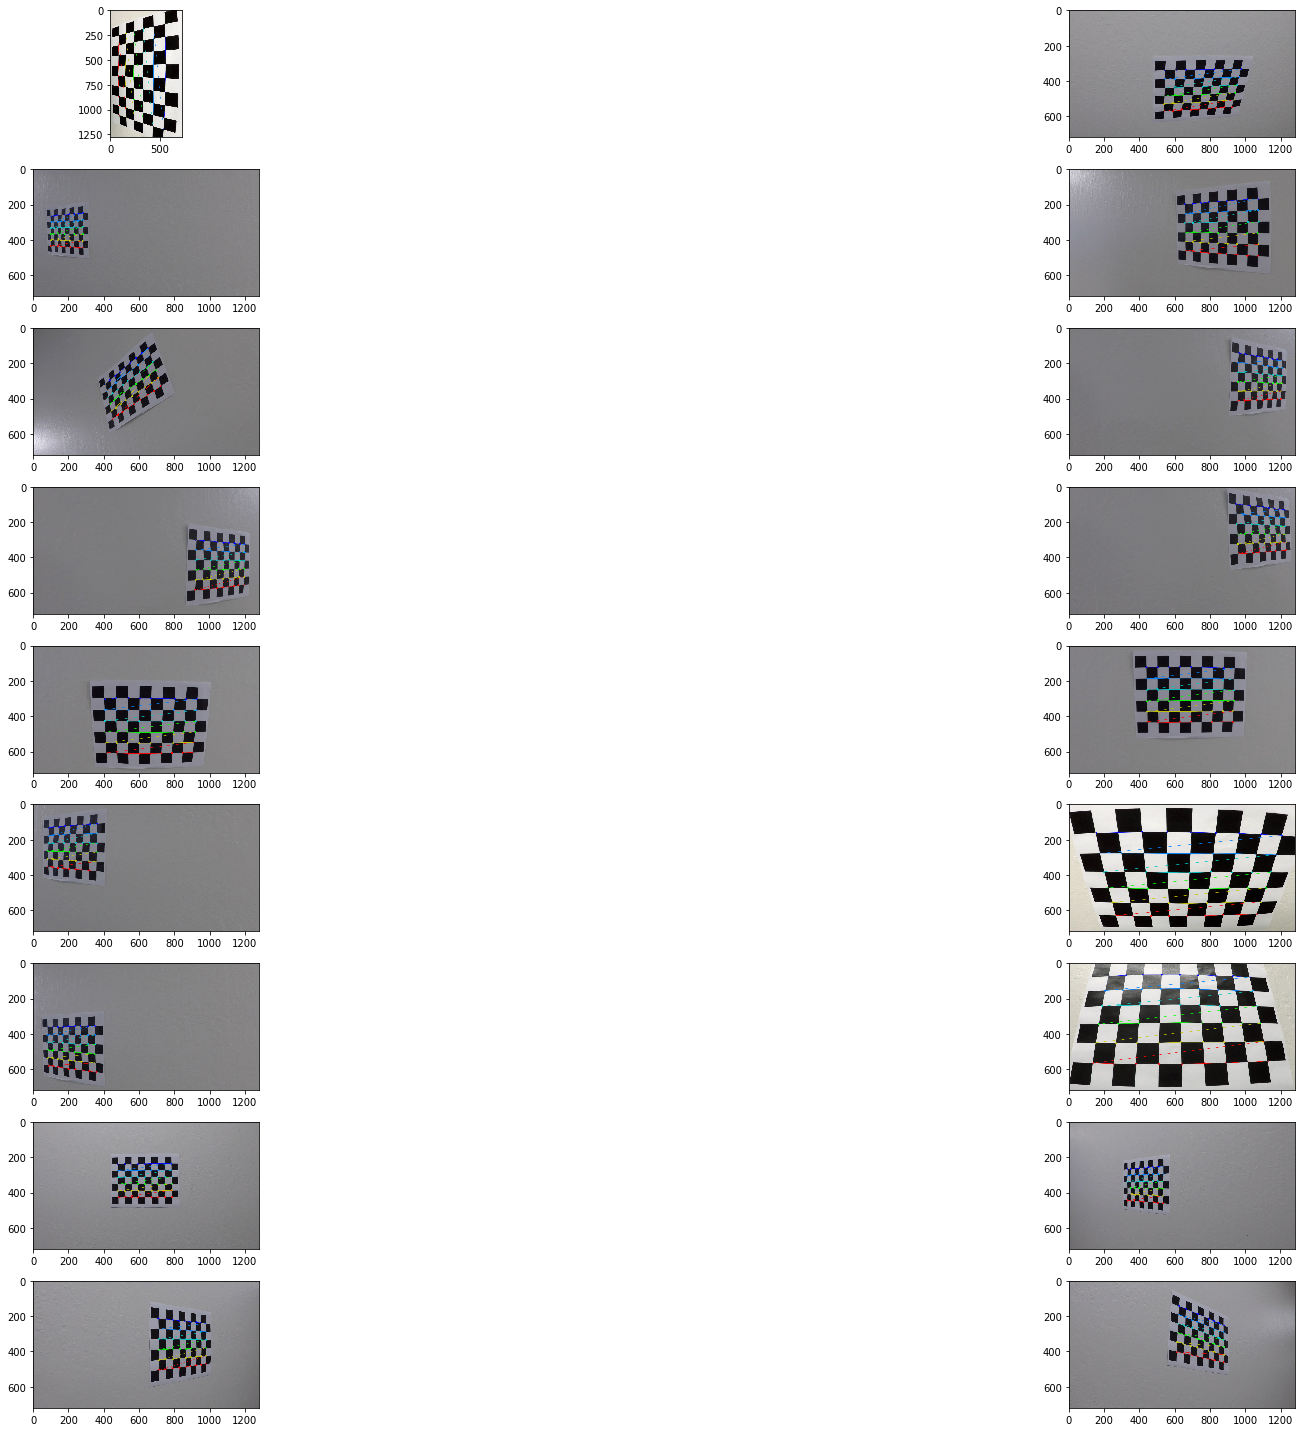

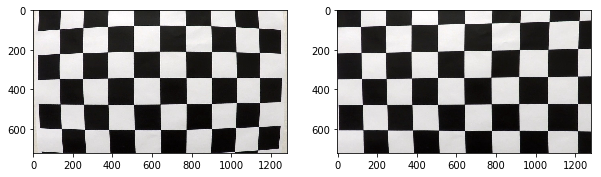

In [38]:
calib_images=load_files()
#original_images=calib_images.copy()
gray_images=gray_scale(calib_images)
#print(len(gray_images))
objectpoints,imagepoints=find_corners(gray_images)
test_image=mpimg.imread('calib_test/calibration_test.jpg')
corrected=undistort_image(test_image,objectpoints,imagepoints)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test_image)
#plt.set_title("DISTORTED IMAGE")
plt.subplot(1,2,2)
plt.imshow(corrected)
#plt.set_title("UNDISTORTED IMAGE")

plt.show()

In [40]:
#Now objectpoints and image points are there to undistort the image


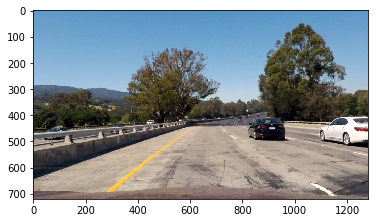

In [49]:
img=mpimg.imread("test1.jpg")
img=undistort_image(img,objectpoints,imagepoints)
plt.imshow(img)


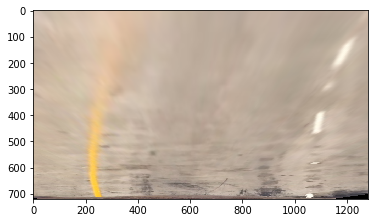

In [44]:
copy = np.copy(img)
bottom_px = copy.shape[0] - 1
src_pts = np.array([[200,bottom_pix],[600,450],[690,450], [1110, bottom_pix]], np.float32)
dest_pts=np.array([[200,bottom_pix],[200,0],[1000,0],[1000,bottom_pix]],np.float32)
transformed= perspective_transform(copy, src_pts, dest_pts)
plt.imshow(transformed)

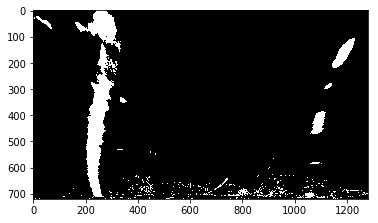

In [47]:

mask=combine_color_and_gradient_threshold(transformed)
plt.imshow(mask,cmap="gray")

In [11]:
def draw_hist(img):
    height=img.shape[0]
    width=img.shape[1]
    bottom_half = img[(height//2):,:]

    #axis=0 means vertically calculating sum of pixels and and its value represented as histogram
    hist = np.sum(bottom_half,axis=0)
    
    return hist

In [12]:
def find_peak(hist):
    mid_p=np.int(hist.shape[0]//2)
    left_lane=np.argmax(hist[:mid_p])
    right_lane=np.argmax(hist[mid_p:])+mid_p
    return left_lane,right_lane


In [13]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [14]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [15]:

class LaneLineHistory:
    def __init__(self, queue_depth=2):
        self.lane_lines = create_queue(queue_depth)
    
    def append(self, lane_line, force=False):
        self.lane_lines.append(lane_line)

In [20]:
class LaneDetection:
    
    def __init__(self, objectpoints, imagepoints,src_pts,dest_pts, window_no, 
                 margin, minpix,img_dimensions=(720, 1280)):
        
        self.objectpoints = objectpoints
        self.imagepoints = imagepoints
        
        (self.matrix, self.inverse_matrix) = compute_matrix(src_pts,dest_pts)

        self.window_no = window_no
        self.half_width = margin
        self.minpix = minpix
        self.img_dimensions = img_dimensions
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        
        #undistort the image using image points and object points
        undistorted_img = undistort_image(img, self.objectpoints, self.imagepoints)
        
        # Produce threshold image with color and gradient thresholding
        threshold_img = combine_color_and_gradient_threshold(undistorted_img)
        
        # Create the perspective transform
        img_size = (undistorted_img.shape[1], undistorted_img.shape[0])
        undist_img_perspective = cv2.warpPerspective(undistorted_img, self.matrix, img_size, flags=cv2.INTER_LINEAR)
        thresh_img_perspective = cv2.warpPerspective(threshold_img, self.matrix, img_size, flags=cv2.INTER_LINEAR)
        
        #do sliding window approach and fit the polynomial on warped image
        leftline, rightline = self.lane_fit(thresh_img_perspective)
        
        #compute curvature of road 
        lcr, rcr, lco = self.calculate_curvature(leftline, rightline)
        
        
        final_img=self.draw(thresh_img_perspective,leftline,rightline,undistorted_img,undist_img_perspective,lcr,rcr,lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = leftline
        self.previous_right_lane_line = rightline
        
        return final_img
    
    def draw(self,image,leftline,rightline,undistorted_img,undist_img_perspective,lcr,rcr,lco):
        drawn_lane_area = draw_area(image, undistorted_img, leftline, rightline,self.inverse_matrix)
        final_img=draw_text(drawn_lane_area, lcr, rcr, lco)
        return final_img        
    
   
    def calculate_curvature(self, left_line, right_line):
        
        #calculate curvature at max point of height i.e. from the bottom point to find curvature at that point
        max_y = self.img_dimensions[0]-1
        ploty=np.linspace(0,self.img_dimensions[0]-1,self.img_dimensions[0])
        
        #contains the polynomial fitted to both lines
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        #meteres per pixel
        #width of lane=3.7
        #width of lane in pixel space=800
        #length of lane in pixel space=720
        #length of lane in real space=32
        x_meters_per_pixel=3.7/800
        y_meters_per_pixel=32/720
        
        #polynomial fitting meter space 
        left_fit_m = np.polyfit(ploty *y_meters_per_pixel , leftx * x_meters_per_pixel, 2)
        right_fit_m = np.polyfit(ploty * y_meters_per_pixel, rightx * x_meters_per_pixel, 2)
        
        # radii of curvature
        single_der_left=2*left_fit_m[0]*max_y*y_meters_per_pixel+left_fit_m[1]
        double_der_left=2*abs(left_fit_m[0])
        left_rad = ((1+(single_der_left)**2)**(3/2))/double_der_left
        
        single_der_right=2*right_fit_m[0]*max_y*y_meters_per_pixel+right_fit_m[1]
        double_der_right=2*abs(right_fit_m[0])
        right_rad= ((1+(single_der_right)**2)**(3/2))/double_der_right
        
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * max_y**2 + left_fit[1] * max_y + left_fit[2]) + 
                   (right_fit[0] * max_y**2 + right_fit[1] * max_y + right_fit[2])) / 2) -600
        
        center_offset_real_world_m = center_offset_img_space * x_meters_per_pixel
        
        # Now our radius of curvature is in meters        
        #return left_curverad, right_curverad, center_offset_real_world_m   
        return left_rad , right_rad, center_offset_real_world_m
        
        
    def lane_fit(self, img):
        

        #draw histogram
        hist=draw_hist(img)
        
        #find peak of histogram
        left,right=find_peak(hist)
        
        #parameters defining sliding window
        height = np.int(img.shape[0]//self.window_no)
        margin = self.half_width
        min_pix_to_recenter = self.minpix
        
        #Number of non zero pixels in an image
        nonzero = img.nonzero()
        
        #get it x and y coordinates in different arrays
        non_zero_y = np.array(nonzero[0])
        non_zero_x = np.array(nonzero[1])
        
        # Initial high peak position for a histogram 
        left_lane_start=left
        right_lane_start=right 
        
        # List for obtaining pixels inside a sliding window approach
        left_lane_inds = []
        right_lane_inds = []
        
        #storing result of this computation for future sliding window calculation
        left_line = LaneLine()
        right_line = LaneLine()
        
        #Total Non zero pixel 
        total_non_zeros = len(non_zero_x)
        non_zero_found_per = 0.0
           
        #Not the first frame in video    
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            
            A=self.previous_left_lane_line.polynomial_coeff[0]
            B=self.previous_left_lane_line.polynomial_coeff[1]
            C=self.previous_left_lane_line.polynomial_coeff[2]
            left_fit_previous=A*(non_zero_y**2)+B*non_zero_y+C
            left_lane_inds = ((non_zero_x > (left_fit_previous - margin))  & (non_zero_x < (left_fit_previous + margin))) 
            A1=self.previous_right_lane_line.polynomial_coeff[0]
            B1=self.previous_right_lane_line.polynomial_coeff[1]
            C1=self.previous_right_lane_line.polynomial_coeff[2]
            right_fit_previous=A1*(non_zero_y**2)+B1*non_zero_y+C1
            right_lane_inds = ((non_zero_x > (right_fit_previous - margin))  & (non_zero_x < (right_fit_previous + margin)))

            
            found_left = np.sum(left_lane_inds)
            found_right = np.sum(right_lane_inds)
            non_zero_found_per = (found_left + found_right) / total_non_zeros
        
        #if not sufficient pixels are not found under sliding window discard this and start from starting
        if non_zero_found_per < 0.85:
            left_lane_inds = []
            right_lane_inds = []

            
            for w in range(self.window_no):
                
                #create boundaries dimension of sliding window
                win_y_bottom=img.shape[0]-w*height
                win_y_top=img.shape[0]-(w+1)*height
                
                #x coordinates
                win_left_low_x=left_lane_start-margin
                win_left_high_x=left_lane_start+margin
                win_right_low_x=right_lane_start-margin
                win_right_high_x=right_lane_start+margin
                
                
                #append to object of lane line that store information about current line
                left_line.windows.append([(win_left_low_x,win_y_top),(win_left_high_x,win_y_bottom)])
                right_line.windows.append([(win_right_low_x,win_y_top),(win_right_high_x,win_y_bottom)])
                
                
                #index of points in array coordinates non_zero_x and non_zero_y that comes under the sliding window
                sliding_left = ((non_zero_y >= win_y_top) & (non_zero_y <win_y_bottom ) & 
                (non_zero_x >= win_left_low_x) &  (non_zero_x <win_left_high_x)).nonzero()[0]  
                sliding_right = ((non_zero_y >=  win_y_top) & (non_zero_y <win_y_bottom) & 
                (non_zero_x >= win_right_low_x) &  (non_zero_x < win_right_high_x)).nonzero()[0]
                
                # Append these indices to the lists
                left_lane_inds.append(sliding_left)
                right_lane_inds.append(sliding_right)

                # This creates next sliding window starting point as mean of coordinates of non_zero pixels found under sliding window
                if len(sliding_left) > min_pix_to_recenter:
                    left_lane_start = np.int(np.mean(non_zero_x[sliding_left]))
                if len(sliding_right) > min_pix_to_recenter:        
                    right_lane_start = np.int(np.mean(non_zero_x[sliding_right]))

            #concatenate the list of list to create one list
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
        # Extract left and right line pixel positions inside sliding window
        x_left = non_zero_x[left_lane_inds]
        y_left = non_zero_y[left_lane_inds] 
        x_right = non_zero_x[right_lane_inds]
        y_right = non_zero_y[right_lane_inds] 
        
        
        #fit polygon to points found under sliding window 
        left_fit = np.polyfit(y_left, x_left, 2)
        right_fit = np.polyfit(y_right, x_right, 2)
        
        #save the coeff to line information object
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        self.previous_left_lane_lines.append(left_line)   
        self.previous_right_lane_lines.append(right_line)
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = x_left  
        left_line.non_zero_y = y_left

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = x_right
        right_line.non_zero_y = y_right

        
        return (left_line, right_line)

In [30]:
ld = LaneDetection(objectpoints, imagepoints, src_pts, dest_pts, 20, 100, 50)

In [31]:

proc_img = ld.process_image(img)

Left Curvature   Right Curvature  Center Alignment 
16810.3644m      773.1927m        0.1490m Right    


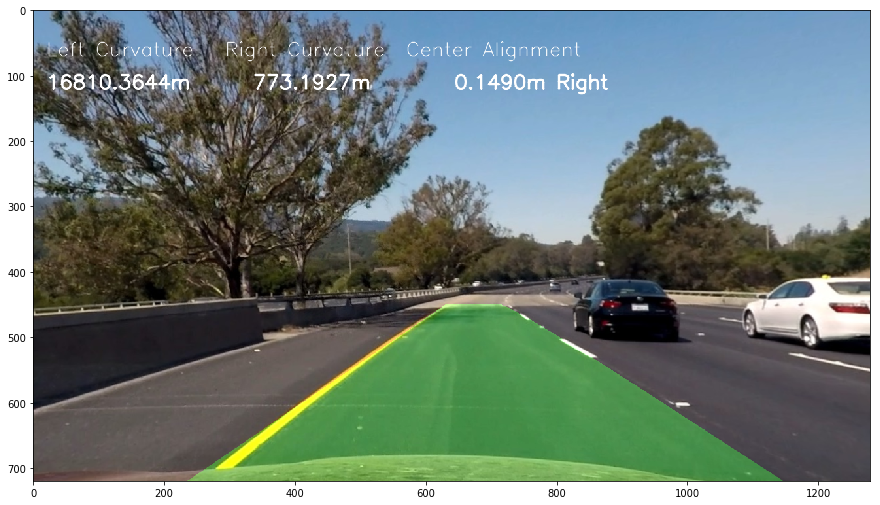

In [32]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

In [37]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
project_video_path = "advance_test_videos/project_video.mp4"
project_video_output_path = 'advance_output_videos/lanes_project_video.mp4'
project_video_sample_path = 'advance_test_videos/project_video_sample.mp4'
project_video_sample_output_path = 'advance_output_videos/lanes_project_video_sample.mp4'

In [22]:
detector = LaneDetection(objectpoints, imagepoints, src_pts, dest_pts, 20, 100, 50)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) 
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Left Curvature   Right Curvature  Center Alignment 
472.9715m        1003.7095m       0.4233m Right    
[MoviePy] >>>> Building video advance_output_videos/lanes_project_video.mp4
[MoviePy] Writing video advance_output_videos/lanes_project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

Left Curvature   Right Curvature  Center Alignment 
494.6872m        1019.7481m       0.4295m Right    


  0%|                                                                                 | 1/1261 [00:01<41:34,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
473.6578m        739.1736m        0.4107m Right    


  0%|▏                                                                                | 2/1261 [00:03<40:48,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
445.7818m        672.9250m        0.4040m Right    


  0%|▏                                                                                | 3/1261 [00:05<40:33,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
466.3936m        508.8695m        0.3991m Right    


  0%|▎                                                                                | 4/1261 [00:07<41:11,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
510.1904m        466.7325m        0.4042m Right    


  0%|▎                                                                                | 5/1261 [00:10<43:32,  2.08s/it]

Left Curvature   Right Curvature  Center Alignment 
494.3625m        428.2406m        0.4030m Right    


  0%|▍                                                                                | 6/1261 [00:12<44:51,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
537.9601m        456.6147m        0.4103m Right    


  1%|▍                                                                                | 7/1261 [00:14<44:03,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
525.2157m        598.6200m        0.4337m Right    


  1%|▌                                                                                | 8/1261 [00:16<42:44,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
592.5187m        641.5534m        0.4408m Right    


  1%|▌                                                                                | 9/1261 [00:18<41:31,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
619.1541m        816.1746m        0.4592m Right    


  1%|▋                                                                               | 10/1261 [00:20<40:37,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
636.2279m        1359.9969m       0.4791m Right    


  1%|▋                                                                               | 11/1261 [00:22<40:35,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
920.6573m        989.3383m        0.4681m Right    


  1%|▊                                                                               | 12/1261 [00:23<40:21,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
960.4674m        966.2169m        0.4619m Right    


  1%|▊                                                                               | 13/1261 [00:25<39:55,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
784.6285m        716.2280m        0.4357m Right    


  1%|▉                                                                               | 14/1261 [00:27<40:21,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
719.5318m        659.7908m        0.4250m Right    


  1%|▉                                                                               | 15/1261 [00:29<40:07,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
671.0053m        425.3265m        0.3917m Right    


  1%|█                                                                               | 16/1261 [00:31<39:59,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
595.8316m        368.3241m        0.3741m Right    


  1%|█                                                                               | 17/1261 [00:33<39:50,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
666.3000m        430.0523m        0.3850m Right    


  1%|█▏                                                                              | 18/1261 [00:35<39:31,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
653.0816m        407.5817m        0.3696m Right    


  2%|█▏                                                                              | 19/1261 [00:37<39:22,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
650.9214m        431.0448m        0.3578m Right    


  2%|█▎                                                                              | 20/1261 [00:39<38:57,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
702.6094m        389.5823m        0.3312m Right    


  2%|█▎                                                                              | 21/1261 [00:41<39:01,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
712.5144m        415.1008m        0.3341m Right    


  2%|█▍                                                                              | 22/1261 [00:43<39:57,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
856.4116m        451.2686m        0.3430m Right    


  2%|█▍                                                                              | 23/1261 [00:45<40:32,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
646.7214m        602.1978m        0.3602m Right    


  2%|█▌                                                                              | 24/1261 [00:47<40:48,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
594.5251m        812.2637m        0.3723m Right    


  2%|█▌                                                                              | 25/1261 [00:49<40:18,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
678.1796m        785.0221m        0.3653m Right    


  2%|█▋                                                                              | 26/1261 [00:50<40:05,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
614.6851m        806.5689m        0.3615m Right    


  2%|█▋                                                                              | 27/1261 [00:52<40:09,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
603.5520m        798.3497m        0.3542m Right    


  2%|█▊                                                                              | 28/1261 [00:54<40:24,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
539.3224m        600.4670m        0.3372m Right    


  2%|█▊                                                                              | 29/1261 [00:56<39:53,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
487.6870m        642.6812m        0.3370m Right    


  2%|█▉                                                                              | 30/1261 [00:58<39:33,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
447.2148m        391.3015m        0.3131m Right    


  2%|█▉                                                                              | 31/1261 [01:00<39:06,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
417.3996m        354.2541m        0.3042m Right    


  3%|██                                                                              | 32/1261 [01:02<38:39,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
377.3840m        323.7217m        0.2687m Right    


  3%|██                                                                              | 33/1261 [01:04<38:19,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
379.2880m        404.8489m        0.3122m Right    


  3%|██▏                                                                             | 34/1261 [01:06<38:02,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
375.1421m        489.6075m        0.3439m Right    


  3%|██▏                                                                             | 35/1261 [01:07<37:50,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
365.7212m        453.3112m        0.3401m Right    


  3%|██▎                                                                             | 36/1261 [01:09<37:44,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
351.9559m        434.8923m        0.3328m Right    


  3%|██▎                                                                             | 37/1261 [01:11<37:40,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
336.3705m        384.2689m        0.3263m Right    


  3%|██▍                                                                             | 38/1261 [01:13<37:40,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
336.3974m        303.8813m        0.3036m Right    


  3%|██▍                                                                             | 39/1261 [01:15<37:34,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
326.5094m        310.3027m        0.3090m Right    


  3%|██▌                                                                             | 40/1261 [01:17<37:24,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
335.0142m        287.9310m        0.3143m Right    


  3%|██▌                                                                             | 41/1261 [01:18<37:17,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
361.7610m        319.7798m        0.3385m Right    


  3%|██▋                                                                             | 42/1261 [01:20<37:23,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
391.1715m        325.9572m        0.3534m Right    


  3%|██▋                                                                             | 43/1261 [01:22<37:46,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
397.8528m        329.2471m        0.3491m Right    


  3%|██▊                                                                             | 44/1261 [01:24<37:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
423.5804m        346.7114m        0.3554m Right    


  4%|██▊                                                                             | 45/1261 [01:26<37:36,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
437.9188m        362.0013m        0.3467m Right    


  4%|██▉                                                                             | 46/1261 [01:28<37:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
458.6173m        414.7764m        0.3632m Right    


  4%|██▉                                                                             | 47/1261 [01:30<37:54,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
479.6425m        504.4290m        0.3872m Right    


  4%|███                                                                             | 48/1261 [01:32<38:00,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
543.3765m        528.3780m        0.3977m Right    


  4%|███                                                                             | 49/1261 [01:33<37:52,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
571.0682m        548.7546m        0.4022m Right    


  4%|███▏                                                                            | 50/1261 [01:35<37:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
656.2787m        537.1522m        0.4003m Right    


  4%|███▏                                                                            | 51/1261 [01:37<38:18,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
665.1914m        496.9720m        0.3902m Right    


  4%|███▎                                                                            | 52/1261 [01:39<38:56,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
658.3038m        439.5215m        0.3757m Right    


  4%|███▎                                                                            | 53/1261 [01:41<39:25,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
626.2327m        377.4421m        0.3614m Right    


  4%|███▍                                                                            | 54/1261 [01:43<39:57,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
688.0899m        386.8300m        0.3656m Right    


  4%|███▍                                                                            | 55/1261 [01:45<39:50,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
732.8043m        409.5883m        0.3642m Right    


  4%|███▌                                                                            | 56/1261 [01:47<40:00,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
700.5689m        448.2548m        0.3669m Right    


  5%|███▌                                                                            | 57/1261 [01:49<40:14,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
660.3725m        468.8987m        0.3565m Right    


  5%|███▋                                                                            | 58/1261 [01:51<40:08,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
616.9142m        798.8374m        0.3965m Right    


  5%|███▋                                                                            | 59/1261 [01:53<40:32,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
601.1434m        542.6968m        0.3491m Right    


  5%|███▊                                                                            | 60/1261 [01:56<41:07,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
619.8861m        423.1943m        0.3197m Right    


  5%|███▊                                                                            | 61/1261 [01:58<42:08,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
577.9952m        323.7339m        0.2874m Right    


  5%|███▉                                                                            | 62/1261 [02:00<43:50,  2.19s/it]

Left Curvature   Right Curvature  Center Alignment 
633.3589m        324.4404m        0.2801m Right    


  5%|███▉                                                                            | 63/1261 [02:02<41:46,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
616.1457m        330.3139m        0.2831m Right    


  5%|████                                                                            | 64/1261 [02:04<40:22,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
644.4424m        339.0596m        0.2794m Right    


  5%|████                                                                            | 65/1261 [02:06<39:22,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
630.2582m        394.1394m        0.2905m Right    


  5%|████▏                                                                           | 66/1261 [02:08<38:31,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
645.3107m        451.2197m        0.2946m Right    


  5%|████▎                                                                           | 67/1261 [02:09<37:49,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
699.2256m        456.3441m        0.2914m Right    


  5%|████▎                                                                           | 68/1261 [02:11<37:38,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
655.1687m        479.1117m        0.2883m Right    


  5%|████▍                                                                           | 69/1261 [02:13<37:12,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
762.0843m        513.9717m        0.2920m Right    


  6%|████▍                                                                           | 70/1261 [02:15<37:05,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
731.5425m        464.3044m        0.2708m Right    


  6%|████▌                                                                           | 71/1261 [02:17<36:54,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
770.4403m        487.3206m        0.2641m Right    


  6%|████▌                                                                           | 72/1261 [02:19<36:50,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
819.8667m        432.9725m        0.2513m Right    


  6%|████▋                                                                           | 73/1261 [02:21<36:40,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
788.5178m        435.9981m        0.2417m Right    


  6%|████▋                                                                           | 74/1261 [02:22<36:26,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
881.2928m        434.1986m        0.2426m Right    


  6%|████▊                                                                           | 75/1261 [02:24<36:25,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
861.4803m        384.4048m        0.2275m Right    


  6%|████▊                                                                           | 76/1261 [02:26<36:32,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1051.2996m       454.2452m        0.2406m Right    


  6%|████▉                                                                           | 77/1261 [02:28<36:27,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1105.1886m       459.7763m        0.2394m Right    


  6%|████▉                                                                           | 78/1261 [02:30<36:22,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1161.1555m       453.3185m        0.2356m Right    


  6%|█████                                                                           | 79/1261 [02:32<36:17,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1019.2511m       386.5863m        0.2165m Right    


  6%|█████                                                                           | 80/1261 [02:33<36:10,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
991.0972m        380.3903m        0.2097m Right    


  6%|█████▏                                                                          | 81/1261 [02:35<36:08,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
849.8053m        382.3937m        0.1943m Right    


  7%|█████▏                                                                          | 82/1261 [02:37<36:15,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
815.1275m        411.8931m        0.1917m Right    


  7%|█████▎                                                                          | 83/1261 [02:39<36:05,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
952.9249m        374.6763m        0.1729m Right    


  7%|█████▎                                                                          | 84/1261 [02:41<36:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
812.3011m        461.4805m        0.1897m Right    


  7%|█████▍                                                                          | 85/1261 [02:43<36:50,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
723.8119m        554.0980m        0.2103m Right    


  7%|█████▍                                                                          | 86/1261 [02:45<36:35,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
575.4795m        724.2559m        0.2188m Right    


  7%|█████▌                                                                          | 87/1261 [02:46<36:21,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
503.7204m        558.1035m        0.1971m Right    


  7%|█████▌                                                                          | 88/1261 [02:48<36:20,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
476.0627m        454.2411m        0.1784m Right    


  7%|█████▋                                                                          | 89/1261 [02:50<36:02,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
431.6697m        341.9545m        0.1617m Right    


  7%|█████▋                                                                          | 90/1261 [02:52<35:56,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
456.4557m        369.2953m        0.1722m Right    


  7%|█████▊                                                                          | 91/1261 [02:54<35:53,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
451.9448m        383.0382m        0.1788m Right    


  7%|█████▊                                                                          | 92/1261 [02:56<36:09,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
433.3661m        421.3665m        0.1912m Right    


  7%|█████▉                                                                          | 93/1261 [02:58<36:11,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
416.3639m        468.0907m        0.2003m Right    


  7%|█████▉                                                                          | 94/1261 [02:59<36:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
449.9592m        466.1848m        0.1971m Right    


  8%|██████                                                                          | 95/1261 [03:01<36:00,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
476.7050m        488.7670m        0.2009m Right    


  8%|██████                                                                          | 96/1261 [03:03<36:01,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
424.6698m        500.1576m        0.2024m Right    


  8%|██████▏                                                                         | 97/1261 [03:05<35:53,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
463.9123m        547.1436m        0.2099m Right    


  8%|██████▏                                                                         | 98/1261 [03:07<36:01,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
455.0053m        512.4026m        0.2064m Right    


  8%|██████▎                                                                         | 99/1261 [03:09<35:50,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
460.6399m        496.3681m        0.2012m Right    


  8%|██████▎                                                                        | 100/1261 [03:10<35:46,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
451.8812m        465.2309m        0.2042m Right    


  8%|██████▎                                                                        | 101/1261 [03:12<35:39,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
437.0512m        359.9859m        0.1785m Right    


  8%|██████▍                                                                        | 102/1261 [03:14<35:38,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
430.6531m        322.0837m        0.1763m Right    


  8%|██████▍                                                                        | 103/1261 [03:16<35:35,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
433.7682m        299.8117m        0.1805m Right    


  8%|██████▌                                                                        | 104/1261 [03:18<35:32,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
467.2048m        340.2511m        0.1993m Right    


  8%|██████▌                                                                        | 105/1261 [03:20<35:22,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
461.2532m        329.6428m        0.2036m Right    


  8%|██████▋                                                                        | 106/1261 [03:21<35:13,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
481.1467m        319.1114m        0.2022m Right    


  8%|██████▋                                                                        | 107/1261 [03:23<35:06,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
445.8609m        315.6238m        0.1997m Right    


  9%|██████▊                                                                        | 108/1261 [03:25<35:20,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
466.1447m        341.4486m        0.2103m Right    


  9%|██████▊                                                                        | 109/1261 [03:27<35:16,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
470.7749m        399.3601m        0.2443m Right    


  9%|██████▉                                                                        | 110/1261 [03:29<35:16,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
458.2449m        486.3012m        0.2744m Right    


  9%|██████▉                                                                        | 111/1261 [03:31<35:16,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
522.2363m        466.9276m        0.2754m Right    


  9%|███████                                                                        | 112/1261 [03:33<35:20,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
469.2329m        415.0484m        0.2689m Right    


  9%|███████                                                                        | 113/1261 [03:34<35:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
460.0524m        432.8281m        0.2755m Right    


  9%|███████▏                                                                       | 114/1261 [03:36<35:33,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
423.2891m        359.2646m        0.2613m Right    


  9%|███████▏                                                                       | 115/1261 [03:38<35:19,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
391.6434m        282.8538m        0.2426m Right    


  9%|███████▎                                                                       | 116/1261 [03:40<35:28,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
393.2637m        285.3393m        0.2532m Right    


  9%|███████▎                                                                       | 117/1261 [03:42<35:17,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
397.6176m        303.7346m        0.2690m Right    


  9%|███████▍                                                                       | 118/1261 [03:44<35:06,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
414.5610m        324.1751m        0.2815m Right    


  9%|███████▍                                                                       | 119/1261 [03:46<35:03,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
375.9364m        389.5557m        0.3118m Right    


 10%|███████▌                                                                       | 120/1261 [03:47<35:03,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
403.2495m        491.9020m        0.3456m Right    


 10%|███████▌                                                                       | 121/1261 [03:49<35:08,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
378.8853m        501.7013m        0.3532m Right    


 10%|███████▋                                                                       | 122/1261 [03:51<34:53,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
381.8432m        419.3823m        0.3297m Right    


 10%|███████▋                                                                       | 123/1261 [03:53<34:44,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
366.4440m        359.3773m        0.3118m Right    


 10%|███████▊                                                                       | 124/1261 [03:55<34:42,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
363.6282m        301.4011m        0.2950m Right    


 10%|███████▊                                                                       | 125/1261 [03:57<34:40,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
398.4013m        378.1442m        0.3258m Right    


 10%|███████▉                                                                       | 126/1261 [03:58<34:28,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
414.6246m        309.0629m        0.3151m Right    


 10%|███████▉                                                                       | 127/1261 [04:00<34:33,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
415.0212m        322.0774m        0.3216m Right    


 10%|████████                                                                       | 128/1261 [04:02<34:48,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
400.2329m        371.3916m        0.3445m Right    


 10%|████████                                                                       | 129/1261 [04:04<34:43,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
436.6729m        389.4840m        0.3479m Right    


 10%|████████▏                                                                      | 130/1261 [04:06<34:35,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
440.4827m        419.2515m        0.3601m Right    


 10%|████████▏                                                                      | 131/1261 [04:08<34:40,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
445.2432m        449.1433m        0.3723m Right    


 10%|████████▎                                                                      | 132/1261 [04:09<34:45,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
456.7371m        529.2863m        0.3915m Right    


 11%|████████▎                                                                      | 133/1261 [04:11<34:30,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
486.0871m        480.2803m        0.3906m Right    


 11%|████████▍                                                                      | 134/1261 [04:13<34:19,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
495.1464m        539.3674m        0.4016m Right    


 11%|████████▍                                                                      | 135/1261 [04:15<34:13,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
528.1057m        547.9760m        0.4041m Right    


 11%|████████▌                                                                      | 136/1261 [04:17<34:17,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
554.5678m        595.4952m        0.4061m Right    


 11%|████████▌                                                                      | 137/1261 [04:19<34:16,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
610.5378m        664.5929m        0.4128m Right    


 11%|████████▋                                                                      | 138/1261 [04:20<34:08,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
624.1900m        527.1442m        0.3899m Right    


 11%|████████▋                                                                      | 139/1261 [04:22<34:13,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
673.0081m        609.6831m        0.3950m Right    


 11%|████████▊                                                                      | 140/1261 [04:24<34:16,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
652.7488m        512.8746m        0.3814m Right    


 11%|████████▊                                                                      | 141/1261 [04:26<34:25,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
630.6566m        465.2411m        0.3701m Right    


 11%|████████▉                                                                      | 142/1261 [04:28<34:19,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
595.2687m        429.4330m        0.3698m Right    


 11%|████████▉                                                                      | 143/1261 [04:30<34:13,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
614.3341m        470.3639m        0.3683m Right    


 11%|█████████                                                                      | 144/1261 [04:31<34:15,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
663.7507m        511.1421m        0.3713m Right    


 11%|█████████                                                                      | 145/1261 [04:33<34:06,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
595.3679m        604.3469m        0.3766m Right    


 12%|█████████▏                                                                     | 146/1261 [04:35<33:58,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
593.3684m        628.2654m        0.3819m Right    


 12%|█████████▏                                                                     | 147/1261 [04:37<34:01,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
494.6737m        512.5276m        0.3623m Right    


 12%|█████████▎                                                                     | 148/1261 [04:39<34:07,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
482.0750m        392.7808m        0.3310m Right    


 12%|█████████▎                                                                     | 149/1261 [04:41<34:24,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
519.3416m        466.2121m        0.3493m Right    


 12%|█████████▍                                                                     | 150/1261 [04:43<34:31,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
543.4501m        467.0349m        0.3472m Right    


 12%|█████████▍                                                                     | 151/1261 [04:44<34:40,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
561.9961m        407.3102m        0.3305m Right    


 12%|█████████▌                                                                     | 152/1261 [04:46<34:35,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
522.2451m        352.2791m        0.3176m Right    


 12%|█████████▌                                                                     | 153/1261 [04:48<34:13,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
571.7467m        417.2521m        0.3337m Right    


 12%|█████████▋                                                                     | 154/1261 [04:50<34:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
563.4073m        408.5092m        0.3364m Right    


 12%|█████████▋                                                                     | 155/1261 [04:52<34:01,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
535.1661m        426.9323m        0.3317m Right    


 12%|█████████▊                                                                     | 156/1261 [04:54<34:09,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
554.1175m        456.6527m        0.3350m Right    


 12%|█████████▊                                                                     | 157/1261 [04:55<33:58,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
496.3092m        477.4270m        0.3260m Right    


 13%|█████████▉                                                                     | 158/1261 [04:57<33:59,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
512.4319m        484.1367m        0.3205m Right    


 13%|█████████▉                                                                     | 159/1261 [04:59<33:54,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
488.1016m        401.2739m        0.2959m Right    


 13%|██████████                                                                     | 160/1261 [05:01<34:12,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
497.3716m        465.7823m        0.3106m Right    


 13%|██████████                                                                     | 161/1261 [05:03<34:20,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
512.4224m        428.9416m        0.3016m Right    


 13%|██████████▏                                                                    | 162/1261 [05:05<34:18,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
529.1001m        434.6377m        0.3030m Right    


 13%|██████████▏                                                                    | 163/1261 [05:07<34:24,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
497.9799m        394.4016m        0.2918m Right    


 13%|██████████▎                                                                    | 164/1261 [05:09<34:52,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
486.8285m        293.5522m        0.2664m Right    


 13%|██████████▎                                                                    | 165/1261 [05:11<35:00,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
501.8539m        266.5917m        0.2621m Right    


 13%|██████████▍                                                                    | 166/1261 [05:12<34:30,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
464.3374m        296.5319m        0.2778m Right    


 13%|██████████▍                                                                    | 167/1261 [05:14<34:17,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
518.9652m        307.6395m        0.2858m Right    


 13%|██████████▌                                                                    | 168/1261 [05:16<34:23,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
671.5821m        316.1806m        0.2924m Right    


 13%|██████████▌                                                                    | 169/1261 [05:18<34:07,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
635.4822m        306.2481m        0.2703m Right    


 13%|██████████▋                                                                    | 170/1261 [05:20<34:11,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
594.3642m        286.4322m        0.2342m Right    


 14%|██████████▋                                                                    | 171/1261 [05:22<34:00,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
597.7862m        289.8670m        0.2343m Right    


 14%|██████████▊                                                                    | 172/1261 [05:24<33:49,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
566.4173m        265.8758m        0.2232m Right    


 14%|██████████▊                                                                    | 173/1261 [05:26<33:46,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
492.2850m        268.1011m        0.2281m Right    


 14%|██████████▉                                                                    | 174/1261 [05:27<33:34,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
463.1683m        227.7998m        0.2043m Right    


 14%|██████████▉                                                                    | 175/1261 [05:29<33:24,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
453.4449m        220.8620m        0.2031m Right    


 14%|███████████                                                                    | 176/1261 [05:31<33:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
494.7407m        238.8702m        0.2145m Right    


 14%|███████████                                                                    | 177/1261 [05:33<33:16,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
473.7294m        241.5660m        0.2230m Right    


 14%|███████████▏                                                                   | 178/1261 [05:35<33:13,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
478.0831m        260.1543m        0.2411m Right    


 14%|███████████▏                                                                   | 179/1261 [05:37<33:08,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
475.4634m        284.8708m        0.2571m Right    


 14%|███████████▎                                                                   | 180/1261 [05:38<33:10,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
415.8743m        309.1911m        0.2663m Right    


 14%|███████████▎                                                                   | 181/1261 [05:40<33:15,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
421.5562m        334.0229m        0.2723m Right    


 14%|███████████▍                                                                   | 182/1261 [05:42<33:10,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
375.2353m        373.4910m        0.2905m Right    


 15%|███████████▍                                                                   | 183/1261 [05:44<33:05,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
338.2247m        364.0049m        0.2924m Right    


 15%|███████████▌                                                                   | 184/1261 [05:46<33:06,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
317.2463m        348.5367m        0.2784m Right    


 15%|███████████▌                                                                   | 185/1261 [05:48<32:57,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
293.8451m        278.4196m        0.2528m Right    


 15%|███████████▋                                                                   | 186/1261 [05:49<32:53,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
295.4739m        270.6792m        0.2515m Right    


 15%|███████████▋                                                                   | 187/1261 [05:51<32:52,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
291.0928m        276.9992m        0.2638m Right    


 15%|███████████▊                                                                   | 188/1261 [05:53<32:52,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
300.1125m        295.8873m        0.2759m Right    


 15%|███████████▊                                                                   | 189/1261 [05:55<33:03,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
298.6328m        295.9151m        0.2810m Right    


 15%|███████████▉                                                                   | 190/1261 [05:57<32:56,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
303.4877m        294.2826m        0.2885m Right    


 15%|███████████▉                                                                   | 191/1261 [05:59<32:51,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
323.7811m        297.4377m        0.2992m Right    


 15%|████████████                                                                   | 192/1261 [06:01<33:04,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
323.2124m        261.9689m        0.2965m Right    


 15%|████████████                                                                   | 193/1261 [06:02<32:56,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
340.0693m        268.8964m        0.2943m Right    


 15%|████████████▏                                                                  | 194/1261 [06:04<33:00,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
344.4487m        272.0481m        0.2902m Right    


 15%|████████████▏                                                                  | 195/1261 [06:06<32:56,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
404.8450m        281.0847m        0.2751m Right    


 16%|████████████▎                                                                  | 196/1261 [06:08<33:02,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
472.9691m        337.5144m        0.3004m Right    


 16%|████████████▎                                                                  | 197/1261 [06:10<32:55,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
513.0081m        369.2368m        0.2978m Right    


 16%|████████████▍                                                                  | 198/1261 [06:12<32:37,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
673.2994m        384.6198m        0.3051m Right    


 16%|████████████▍                                                                  | 199/1261 [06:13<32:34,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
742.2883m        510.5238m        0.3340m Right    


 16%|████████████▌                                                                  | 200/1261 [06:15<32:53,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
845.1729m        599.3125m        0.3424m Right    


 16%|████████████▌                                                                  | 201/1261 [06:17<32:46,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
657.0548m        502.3792m        0.3153m Right    


 16%|████████████▋                                                                  | 202/1261 [06:19<32:37,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
581.1036m        501.6138m        0.3062m Right    


 16%|████████████▋                                                                  | 203/1261 [06:21<32:36,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
557.4423m        459.9668m        0.2971m Right    


 16%|████████████▊                                                                  | 204/1261 [06:23<32:40,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
524.8314m        353.5062m        0.2779m Right    


 16%|████████████▊                                                                  | 205/1261 [06:25<32:31,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
498.2579m        369.2934m        0.2816m Right    


 16%|████████████▉                                                                  | 206/1261 [06:26<32:35,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
423.6378m        488.0876m        0.3058m Right    


 16%|████████████▉                                                                  | 207/1261 [06:28<32:22,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
401.6360m        473.1813m        0.3074m Right    


 16%|█████████████                                                                  | 208/1261 [06:30<32:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
415.1239m        552.3792m        0.3216m Right    


 17%|█████████████                                                                  | 209/1261 [06:32<32:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
425.6194m        549.9672m        0.3116m Right    


 17%|█████████████▏                                                                 | 210/1261 [06:34<32:18,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
453.4232m        626.5286m        0.3155m Right    


 17%|█████████████▏                                                                 | 211/1261 [06:36<32:35,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
433.3764m        584.8871m        0.3050m Right    


 17%|█████████████▎                                                                 | 212/1261 [06:38<33:00,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
440.0462m        598.0843m        0.3041m Right    


 17%|█████████████▎                                                                 | 213/1261 [06:39<32:35,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
417.8629m        642.6737m        0.3038m Right    


 17%|█████████████▍                                                                 | 214/1261 [06:42<33:37,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
418.1555m        505.0222m        0.2771m Right    


 17%|█████████████▍                                                                 | 215/1261 [06:44<33:41,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
413.9631m        426.9519m        0.2581m Right    


 17%|█████████████▌                                                                 | 216/1261 [06:45<33:11,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
433.3017m        422.8037m        0.2590m Right    


 17%|█████████████▌                                                                 | 217/1261 [06:47<32:46,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
474.7113m        409.7779m        0.2512m Right    


 17%|█████████████▋                                                                 | 218/1261 [06:49<32:29,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
467.3730m        478.6721m        0.2603m Right    


 17%|█████████████▋                                                                 | 219/1261 [06:51<32:10,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
497.4756m        452.7112m        0.2403m Right    


 17%|█████████████▊                                                                 | 220/1261 [06:53<32:12,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
511.3580m        512.7195m        0.2480m Right    


 18%|█████████████▊                                                                 | 221/1261 [06:55<32:03,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
529.7680m        578.0773m        0.2589m Right    


 18%|█████████████▉                                                                 | 222/1261 [06:56<31:54,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
566.8152m        569.3870m        0.2553m Right    


 18%|█████████████▉                                                                 | 223/1261 [06:58<31:48,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
551.8819m        485.6854m        0.2464m Right    


 18%|██████████████                                                                 | 224/1261 [07:00<32:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
596.2305m        470.8469m        0.2419m Right    


 18%|██████████████                                                                 | 225/1261 [07:02<31:54,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
646.7784m        339.2019m        0.2118m Right    


 18%|██████████████▏                                                                | 226/1261 [07:04<31:45,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
664.7244m        342.6769m        0.2097m Right    


 18%|██████████████▏                                                                | 227/1261 [07:06<31:51,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
714.8303m        347.3135m        0.2094m Right    


 18%|██████████████▎                                                                | 228/1261 [07:07<31:51,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
705.2452m        345.3995m        0.2028m Right    


 18%|██████████████▎                                                                | 229/1261 [07:09<31:54,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
789.9755m        344.3827m        0.1918m Right    


 18%|██████████████▍                                                                | 230/1261 [07:11<31:39,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
751.0691m        352.4943m        0.1841m Right    


 18%|██████████████▍                                                                | 231/1261 [07:13<31:56,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
817.4426m        343.6677m        0.1612m Right    


 18%|██████████████▌                                                                | 232/1261 [07:15<31:47,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
847.9735m        340.1577m        0.1448m Right    


 18%|██████████████▌                                                                | 233/1261 [07:17<31:47,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
826.8216m        406.1420m        0.1671m Right    


 19%|██████████████▋                                                                | 234/1261 [07:19<31:44,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
808.7853m        403.1832m        0.1631m Right    


 19%|██████████████▋                                                                | 235/1261 [07:20<31:34,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
680.3115m        335.1017m        0.1437m Right    


 19%|██████████████▊                                                                | 236/1261 [07:22<31:37,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
704.2028m        285.5887m        0.1200m Right    


 19%|██████████████▊                                                                | 237/1261 [07:24<31:42,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
610.4630m        274.1229m        0.1169m Right    


 19%|██████████████▉                                                                | 238/1261 [07:26<31:34,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
582.1376m        288.5419m        0.1208m Right    


 19%|██████████████▉                                                                | 239/1261 [07:28<31:26,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
573.1329m        323.4183m        0.1322m Right    


 19%|███████████████                                                                | 240/1261 [07:30<31:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
580.5052m        338.3728m        0.1314m Right    


 19%|███████████████                                                                | 241/1261 [07:32<31:36,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
625.4010m        350.9550m        0.1321m Right    


 19%|███████████████▏                                                               | 242/1261 [07:33<31:31,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
545.9474m        351.6316m        0.1314m Right    


 19%|███████████████▏                                                               | 243/1261 [07:35<31:17,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
556.2684m        372.0829m        0.1295m Right    


 19%|███████████████▎                                                               | 244/1261 [07:37<31:28,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
515.2980m        294.3387m        0.0874m Right    


 19%|███████████████▎                                                               | 245/1261 [07:39<31:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
492.7695m        254.4620m        0.0554m Right    


 20%|███████████████▍                                                               | 246/1261 [07:41<31:28,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
536.9703m        272.8649m        0.0645m Right    


 20%|███████████████▍                                                               | 247/1261 [07:43<31:24,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
486.2771m        261.3957m        0.0700m Right    


 20%|███████████████▌                                                               | 248/1261 [07:45<31:28,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
523.0448m        278.7722m        0.0725m Right    


 20%|███████████████▌                                                               | 249/1261 [07:46<31:15,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
499.1437m        302.8892m        0.0858m Right    


 20%|███████████████▋                                                               | 250/1261 [07:48<31:07,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
552.1879m        312.9504m        0.0909m Right    


 20%|███████████████▋                                                               | 251/1261 [07:50<31:05,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
570.2973m        322.8895m        0.0926m Right    


 20%|███████████████▊                                                               | 252/1261 [07:52<31:08,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
577.5192m        365.3326m        0.1040m Right    


 20%|███████████████▊                                                               | 253/1261 [07:54<31:23,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
628.3928m        369.7004m        0.1049m Right    


 20%|███████████████▉                                                               | 254/1261 [07:56<31:25,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
620.7055m        376.2095m        0.1098m Right    


 20%|███████████████▉                                                               | 255/1261 [07:58<31:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
630.4572m        367.8534m        0.0968m Right    


 20%|████████████████                                                               | 256/1261 [07:59<31:04,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
558.4530m        315.1208m        0.0643m Right    


 20%|████████████████                                                               | 257/1261 [08:01<31:00,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
569.9010m        284.0140m        0.0494m Right    


 20%|████████████████▏                                                              | 258/1261 [08:03<30:57,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
552.6170m        292.4799m        0.0608m Right    


 21%|████████████████▏                                                              | 259/1261 [08:05<30:54,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
542.6098m        272.5907m        0.0595m Right    


 21%|████████████████▎                                                              | 260/1261 [08:07<30:58,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
588.0268m        307.8369m        0.0790m Right    


 21%|████████████████▎                                                              | 261/1261 [08:09<30:54,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
591.9589m        310.5193m        0.0890m Right    


 21%|████████████████▍                                                              | 262/1261 [08:11<30:47,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
612.2514m        344.5226m        0.1082m Right    


 21%|████████████████▍                                                              | 263/1261 [08:12<30:43,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
580.0282m        332.1765m        0.1026m Right    


 21%|████████████████▌                                                              | 264/1261 [08:14<30:46,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
593.3407m        375.8771m        0.1191m Right    


 21%|████████████████▌                                                              | 265/1261 [08:16<30:46,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
610.0983m        412.1736m        0.1272m Right    


 21%|████████████████▋                                                              | 266/1261 [08:18<30:45,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
582.0097m        459.7242m        0.1366m Right    


 21%|████████████████▋                                                              | 267/1261 [08:20<30:41,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
625.2949m        507.2993m        0.1452m Right    


 21%|████████████████▊                                                              | 268/1261 [08:22<30:42,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
653.6363m        523.4342m        0.1505m Right    


 21%|████████████████▊                                                              | 269/1261 [08:23<30:28,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
637.0327m        602.0670m        0.1593m Right    


 21%|████████████████▉                                                              | 270/1261 [08:25<30:28,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
631.6039m        623.0643m        0.1626m Right    


 21%|████████████████▉                                                              | 271/1261 [08:27<30:26,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
619.6092m        491.7733m        0.1486m Right    


 22%|█████████████████                                                              | 272/1261 [08:29<30:21,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
624.1358m        387.9700m        0.1282m Right    


 22%|█████████████████                                                              | 273/1261 [08:31<30:17,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
588.6323m        424.7652m        0.1449m Right    


 22%|█████████████████▏                                                             | 274/1261 [08:33<30:14,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
635.6883m        450.0718m        0.1514m Right    


 22%|█████████████████▏                                                             | 275/1261 [08:35<30:17,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
680.4678m        458.8417m        0.1602m Right    


 22%|█████████████████▎                                                             | 276/1261 [08:36<30:19,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
732.9777m        492.8239m        0.1687m Right    


 22%|█████████████████▎                                                             | 277/1261 [08:38<30:20,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
773.0297m        527.7904m        0.1767m Right    


 22%|█████████████████▍                                                             | 278/1261 [08:40<30:25,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
743.3269m        560.5131m        0.1795m Right    


 22%|█████████████████▍                                                             | 279/1261 [08:42<30:52,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
715.2971m        665.8818m        0.1872m Right    


 22%|█████████████████▌                                                             | 280/1261 [08:44<30:53,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
766.8225m        560.2567m        0.1809m Right    


 22%|█████████████████▌                                                             | 281/1261 [08:46<30:45,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
710.3937m        523.9446m        0.1746m Right    


 22%|█████████████████▋                                                             | 282/1261 [08:48<30:29,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
768.9827m        613.2029m        0.1918m Right    


 22%|█████████████████▋                                                             | 283/1261 [08:50<30:20,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
753.3712m        488.8851m        0.1835m Right    


 23%|█████████████████▊                                                             | 284/1261 [08:51<30:14,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
784.7895m        576.7746m        0.1954m Right    


 23%|█████████████████▊                                                             | 285/1261 [08:53<30:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
837.7731m        536.8994m        0.1972m Right    


 23%|█████████████████▉                                                             | 286/1261 [08:55<30:08,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
833.6227m        459.2221m        0.1896m Right    


 23%|█████████████████▉                                                             | 287/1261 [08:57<30:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
928.9947m        510.4379m        0.2060m Right    


 23%|██████████████████                                                             | 288/1261 [08:59<30:30,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
922.6037m        515.8759m        0.2185m Right    


 23%|██████████████████                                                             | 289/1261 [09:01<30:25,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
953.3597m        576.9114m        0.2286m Right    


 23%|██████████████████▏                                                            | 290/1261 [09:03<30:10,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
954.5635m        754.4593m        0.2449m Right    


 23%|██████████████████▏                                                            | 291/1261 [09:04<30:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
902.3565m        883.9388m        0.2513m Right    


 23%|██████████████████▎                                                            | 292/1261 [09:06<30:11,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
952.0019m        734.4692m        0.2433m Right    


 23%|██████████████████▎                                                            | 293/1261 [09:08<30:12,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
934.2853m        715.7453m        0.2465m Right    


 23%|██████████████████▍                                                            | 294/1261 [09:10<29:58,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
916.3726m        771.1586m        0.2504m Right    


 23%|██████████████████▍                                                            | 295/1261 [09:12<29:49,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1002.8993m       728.0301m        0.2570m Right    


 23%|██████████████████▌                                                            | 296/1261 [09:14<29:52,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1024.5708m       728.6756m        0.2504m Right    


 24%|██████████████████▌                                                            | 297/1261 [09:16<29:46,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1225.2644m       755.9319m        0.2579m Right    


 24%|██████████████████▋                                                            | 298/1261 [09:17<29:40,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1289.1601m       755.1276m        0.2543m Right    


 24%|██████████████████▋                                                            | 299/1261 [09:19<29:43,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1240.6353m       914.4025m        0.2628m Right    


 24%|██████████████████▊                                                            | 300/1261 [09:21<29:42,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1579.2889m       1050.3808m       0.2708m Right    


 24%|██████████████████▊                                                            | 301/1261 [09:23<29:46,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1592.4438m       1089.8428m       0.2691m Right    


 24%|██████████████████▉                                                            | 302/1261 [09:25<29:52,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1952.6805m       1395.1199m       0.2776m Right    


 24%|██████████████████▉                                                            | 303/1261 [09:27<29:43,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2207.9517m       3217.5001m       0.2918m Right    


 24%|███████████████████                                                            | 304/1261 [09:29<29:37,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2100.9909m       5060.3120m       0.3018m Right    


 24%|███████████████████                                                            | 305/1261 [09:30<29:31,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2595.1453m       9165.3093m       0.2989m Right    


 24%|███████████████████▏                                                           | 306/1261 [09:32<29:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3111.3486m       95403.5790m      0.3069m Right    


 24%|███████████████████▏                                                           | 307/1261 [09:34<29:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3420.9712m       1397.0325m       0.2737m Right    


 24%|███████████████████▎                                                           | 308/1261 [09:36<29:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
3470.7527m       1542.0514m       0.2755m Right    


 25%|███████████████████▎                                                           | 309/1261 [09:38<29:20,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
4451.5584m       1207.6156m       0.2701m Right    


 25%|███████████████████▍                                                           | 310/1261 [09:40<29:23,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
9433.2880m       1896.1493m       0.2828m Right    


 25%|███████████████████▍                                                           | 311/1261 [09:42<29:17,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
13920.7801m      2158.5749m       0.2829m Right    


 25%|███████████████████▌                                                           | 312/1261 [09:43<29:18,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
18536.6243m      1728.7294m       0.2748m Right    


 25%|███████████████████▌                                                           | 313/1261 [09:45<29:11,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
241170.7420m     1781.1033m       0.2808m Right    


 25%|███████████████████▋                                                           | 314/1261 [09:47<29:19,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
19602.7322m      1739.2663m       0.2793m Right    


 25%|███████████████████▋                                                           | 315/1261 [09:49<29:13,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
15459.1585m      1242.2529m       0.2647m Right    


 25%|███████████████████▊                                                           | 316/1261 [09:51<29:18,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
160434.9763m     1079.3446m       0.2414m Right    


 25%|███████████████████▊                                                           | 317/1261 [09:53<29:16,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
27062.8283m      748.1168m        0.2230m Right    


 25%|███████████████████▉                                                           | 318/1261 [09:55<29:24,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
9870.7198m       801.5403m        0.2309m Right    


 25%|███████████████████▉                                                           | 319/1261 [09:56<29:16,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
10322.2843m      1090.8323m       0.2542m Right    


 25%|████████████████████                                                           | 320/1261 [09:58<29:06,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5562.7071m       1139.3567m       0.2622m Right    


 25%|████████████████████                                                           | 321/1261 [10:00<29:14,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
3904.6990m       1191.1149m       0.2678m Right    


 26%|████████████████████▏                                                          | 322/1261 [10:02<29:10,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4787.1926m       1842.7588m       0.2739m Right    


 26%|████████████████████▏                                                          | 323/1261 [10:04<29:03,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
6740.3247m       1216.2530m       0.2657m Right    


 26%|████████████████████▎                                                          | 324/1261 [10:06<29:09,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4664.3031m       2461.3504m       0.2813m Right    


 26%|████████████████████▎                                                          | 325/1261 [10:08<29:09,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
3751.6547m       3074.6918m       0.2845m Right    


 26%|████████████████████▍                                                          | 326/1261 [10:10<29:04,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4601.1776m       2664.9702m       0.2838m Right    


 26%|████████████████████▍                                                          | 327/1261 [10:11<29:01,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5683.6549m       10041.5594m      0.2926m Right    


 26%|████████████████████▌                                                          | 328/1261 [10:13<28:58,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3968.4043m       14004.3849m      0.3124m Right    


 26%|████████████████████▌                                                          | 329/1261 [10:15<28:56,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4000.3159m       5512.6648m       0.3127m Right    


 26%|████████████████████▋                                                          | 330/1261 [10:17<28:59,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4594.7380m       3096.9547m       0.2815m Right    


 26%|████████████████████▋                                                          | 331/1261 [10:19<28:55,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
5018.9278m       2079.8397m       0.2707m Right    


 26%|████████████████████▊                                                          | 332/1261 [10:21<28:47,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
11003.8936m      4927.0570m       0.2757m Right    


 26%|████████████████████▊                                                          | 333/1261 [10:23<28:38,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
8977.7437m       5853.1819m       0.2750m Right    


 26%|████████████████████▉                                                          | 334/1261 [10:24<28:41,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
6584.6617m       47298.9498m      0.2870m Right    


 27%|████████████████████▉                                                          | 335/1261 [10:26<29:04,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
4454.6297m       2634.4660m       0.2809m Right    


 27%|█████████████████████                                                          | 336/1261 [10:28<28:54,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
7985.9140m       3312.0854m       0.2817m Right    


 27%|█████████████████████                                                          | 337/1261 [10:30<28:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4097.9767m       8451.5769m       0.2937m Right    


 27%|█████████████████████▏                                                         | 338/1261 [10:32<29:03,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
6198.0283m       74142.9708m      0.2946m Right    


 27%|█████████████████████▏                                                         | 339/1261 [10:34<28:50,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
7540.2029m       7196.2650m       0.2975m Right    


 27%|█████████████████████▎                                                         | 340/1261 [10:36<28:44,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
7227.8621m       45421.2666m      0.2900m Right    


 27%|█████████████████████▎                                                         | 341/1261 [10:38<28:40,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
33536.4238m      1279.4385m       0.2447m Right    


 27%|█████████████████████▍                                                         | 342/1261 [10:39<28:42,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
24917.4918m      1498.8588m       0.2488m Right    


 27%|█████████████████████▍                                                         | 343/1261 [10:41<29:27,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
8495.0785m       1600.8593m       0.2531m Right    


 27%|█████████████████████▌                                                         | 344/1261 [10:43<29:14,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
5035.3051m       1633.4173m       0.2533m Right    


 27%|█████████████████████▌                                                         | 345/1261 [10:45<28:56,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
4877.1842m       1612.2799m       0.2517m Right    


 27%|█████████████████████▋                                                         | 346/1261 [10:47<28:46,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
6024.8628m       1932.7665m       0.2629m Right    


 28%|█████████████████████▋                                                         | 347/1261 [10:49<28:33,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
6672.6566m       1789.7747m       0.2670m Right    


 28%|█████████████████████▊                                                         | 348/1261 [10:51<28:26,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
7679.7905m       2642.6721m       0.2743m Right    


 28%|█████████████████████▊                                                         | 349/1261 [10:53<28:19,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5885.3215m       2516.4336m       0.2753m Right    


 28%|█████████████████████▉                                                         | 350/1261 [10:55<28:20,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
8907.1542m       6611.9063m       0.2835m Right    


 28%|█████████████████████▉                                                         | 351/1261 [10:56<28:11,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
10560.3513m      10286.1554m      0.2882m Right    


 28%|██████████████████████                                                         | 352/1261 [10:58<28:08,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
8367.8876m       5794.0973m       0.2809m Right    


 28%|██████████████████████                                                         | 353/1261 [11:00<28:13,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
22093.5467m      38504.0529m      0.2923m Right    


 28%|██████████████████████▏                                                        | 354/1261 [11:02<28:10,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
6762.1735m       24352.7030m      0.2994m Right    


 28%|██████████████████████▏                                                        | 355/1261 [11:04<28:17,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
5165.1693m       7749.4180m       0.2911m Right    


 28%|██████████████████████▎                                                        | 356/1261 [11:06<28:12,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1997.0850m       1565.5676m       0.2798m Right    


 28%|██████████████████████▎                                                        | 357/1261 [11:08<28:16,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
2192.3184m       1776.8317m       0.2861m Right    


 28%|██████████████████████▍                                                        | 358/1261 [11:09<28:15,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1352.7545m       1684.3915m       0.2987m Right    


 28%|██████████████████████▍                                                        | 359/1261 [11:11<28:23,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
1176.3369m       2025.3913m       0.3067m Right    


 29%|██████████████████████▌                                                        | 360/1261 [11:13<28:16,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1108.4177m       3548.2184m       0.3163m Right    


 29%|██████████████████████▌                                                        | 361/1261 [11:15<28:01,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
963.9515m        144472.6518m     0.3249m Right    


 29%|██████████████████████▋                                                        | 362/1261 [11:17<27:58,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
908.9207m        69648.6548m      0.3316m Right    


 29%|██████████████████████▋                                                        | 363/1261 [11:19<27:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1065.9212m       4492.6992m       0.3152m Right    


 29%|██████████████████████▊                                                        | 364/1261 [11:21<27:39,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1082.3756m       8830.2992m       0.3310m Right    


 29%|██████████████████████▊                                                        | 365/1261 [11:22<27:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1051.7962m       9668.7158m       0.3183m Right    


 29%|██████████████████████▉                                                        | 366/1261 [11:24<27:39,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1128.0466m       11990.4886m      0.3197m Right    


 29%|██████████████████████▉                                                        | 367/1261 [11:26<27:38,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1199.6692m       33770.7755m      0.3057m Right    


 29%|███████████████████████                                                        | 368/1261 [11:28<27:34,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1364.7001m       3250.7374m       0.2875m Right    


 29%|███████████████████████                                                        | 369/1261 [11:30<27:35,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1405.0929m       2946.6186m       0.2817m Right    


 29%|███████████████████████▏                                                       | 370/1261 [11:32<27:36,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1808.6900m       4966.0688m       0.2791m Right    


 29%|███████████████████████▏                                                       | 371/1261 [11:34<27:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1902.8509m       8850.6530m       0.2733m Right    


 30%|███████████████████████▎                                                       | 372/1261 [11:35<27:29,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2177.9692m       6951.6498m       0.2684m Right    


 30%|███████████████████████▎                                                       | 373/1261 [11:37<27:21,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2926.1950m       25766.9964m      0.2634m Right    


 30%|███████████████████████▍                                                       | 374/1261 [11:39<27:41,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
5452.6723m       5809.2405m       0.2579m Right    


 30%|███████████████████████▍                                                       | 375/1261 [11:41<27:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
53621.1013m      4126.6937m       0.2483m Right    


 30%|███████████████████████▌                                                       | 376/1261 [11:43<27:22,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
7498.5358m       2527.0820m       0.2507m Right    


 30%|███████████████████████▌                                                       | 377/1261 [11:45<27:21,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3263.1378m       8229.1272m       0.2292m Right    


 30%|███████████████████████▋                                                       | 378/1261 [11:47<27:16,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
3292.6879m       5017.4464m       0.2362m Right    


 30%|███████████████████████▋                                                       | 379/1261 [11:48<27:17,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2605.6590m       3252.8924m       0.2435m Right    


 30%|███████████████████████▊                                                       | 380/1261 [11:50<27:12,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2855.2268m       4145.8952m       0.2490m Right    


 30%|███████████████████████▊                                                       | 381/1261 [11:52<27:12,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2478.9168m       6258.4915m       0.2418m Right    


 30%|███████████████████████▉                                                       | 382/1261 [11:54<27:08,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2217.9104m       8704.3711m       0.2341m Right    


 30%|███████████████████████▉                                                       | 383/1261 [11:56<27:01,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2168.2282m       4710.9562m       0.2325m Right    


 30%|████████████████████████                                                       | 384/1261 [11:58<27:02,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2315.5149m       14578.5464m      0.2476m Right    


 31%|████████████████████████                                                       | 385/1261 [12:00<26:59,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2782.8336m       112866.4463m     0.2533m Right    


 31%|████████████████████████▏                                                      | 386/1261 [12:01<27:04,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2444.1356m       4799.3035m       0.2505m Right    


 31%|████████████████████████▏                                                      | 387/1261 [12:03<27:04,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2786.3776m       56133.7675m      0.2602m Right    


 31%|████████████████████████▎                                                      | 388/1261 [12:05<27:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2934.2894m       19419.0875m      0.2519m Right    


 31%|████████████████████████▎                                                      | 389/1261 [12:07<27:10,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
2725.8136m       9870.0829m       0.2447m Right    


 31%|████████████████████████▍                                                      | 390/1261 [12:09<27:02,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3949.3886m       2976.2284m       0.2696m Right    


 31%|████████████████████████▍                                                      | 391/1261 [12:11<26:57,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4290.5239m       1657.3283m       0.2836m Right    


 31%|████████████████████████▌                                                      | 392/1261 [12:13<26:59,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3860.9898m       1205.6872m       0.2865m Right    


 31%|████████████████████████▌                                                      | 393/1261 [12:14<26:50,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3963.1768m       1338.9564m       0.2795m Right    


 31%|████████████████████████▋                                                      | 394/1261 [12:16<26:45,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
5566.7842m       1558.3516m       0.2713m Right    


 31%|████████████████████████▋                                                      | 395/1261 [12:18<26:42,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
5759.0408m       1707.6572m       0.2608m Right    


 31%|████████████████████████▊                                                      | 396/1261 [12:20<26:42,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
20946.2199m      1836.8997m       0.2620m Right    


 31%|████████████████████████▊                                                      | 397/1261 [12:22<26:38,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
38365.6897m      3341.9328m       0.2537m Right    


 32%|████████████████████████▉                                                      | 398/1261 [12:24<26:43,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
33233.0637m      2572.2259m       0.2515m Right    


 32%|████████████████████████▉                                                      | 399/1261 [12:26<26:44,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
26931.9914m      34915.4161m      0.2374m Right    


 32%|█████████████████████████                                                      | 400/1261 [12:27<26:32,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
7823.5435m       2082.5301m       0.2103m Right    


 32%|█████████████████████████                                                      | 401/1261 [12:29<26:29,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
10533.4437m      2129.5046m       0.2029m Right    


 32%|█████████████████████████▏                                                     | 402/1261 [12:31<26:30,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
8019.3670m       10665.9058m      0.2192m Right    


 32%|█████████████████████████▏                                                     | 403/1261 [12:33<26:23,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
7760.8166m       12899.2254m      0.2293m Right    


 32%|█████████████████████████▎                                                     | 404/1261 [12:35<26:20,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
11368.4112m      1888.2452m       0.2420m Right    


 32%|█████████████████████████▎                                                     | 405/1261 [12:37<26:22,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
7595.5201m       1974.2797m       0.2368m Right    


 32%|█████████████████████████▍                                                     | 406/1261 [12:39<26:28,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
7554.6190m       1612.3267m       0.2344m Right    


 32%|█████████████████████████▍                                                     | 407/1261 [12:40<26:34,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
7756.5982m       1937.6896m       0.2231m Right    


 32%|█████████████████████████▌                                                     | 408/1261 [12:42<26:56,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
16607.8980m      2887.5556m       0.2110m Right    


 32%|█████████████████████████▌                                                     | 409/1261 [12:44<26:48,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
17717.8188m      1869.6799m       0.2107m Right    


 33%|█████████████████████████▋                                                     | 410/1261 [12:46<26:42,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
28332.0753m      5414.0804m       0.1945m Right    


 33%|█████████████████████████▋                                                     | 411/1261 [12:48<26:30,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
87569.1283m      5866.4807m       0.1784m Right    


 33%|█████████████████████████▊                                                     | 412/1261 [12:50<26:17,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
31402.2823m      2144.0542m       0.1463m Right    


 33%|█████████████████████████▊                                                     | 413/1261 [12:52<26:16,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
10159.1123m      3815.2545m       0.1568m Right    


 33%|█████████████████████████▉                                                     | 414/1261 [12:54<26:15,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4731.1037m       6829.4537m       0.1690m Right    


 33%|█████████████████████████▉                                                     | 415/1261 [12:55<26:15,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3943.1500m       4154.4023m       0.1730m Right    


 33%|██████████████████████████                                                     | 416/1261 [12:57<26:09,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4822.3703m       1713.9624m       0.1843m Right    


 33%|██████████████████████████                                                     | 417/1261 [12:59<26:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3909.9201m       1530.6222m       0.1805m Right    


 33%|██████████████████████████▏                                                    | 418/1261 [13:01<26:19,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4682.4674m       4118.5484m       0.1665m Right    


 33%|██████████████████████████▏                                                    | 419/1261 [13:03<26:09,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2848.4785m       2512.2831m       0.1658m Right    


 33%|██████████████████████████▎                                                    | 420/1261 [13:05<26:06,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2635.3831m       5247.2752m       0.1550m Right    


 33%|██████████████████████████▍                                                    | 421/1261 [13:07<26:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3703.8046m       5553.8429m       0.1482m Right    


 33%|██████████████████████████▍                                                    | 422/1261 [13:08<26:11,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
3314.8780m       2889.6592m       0.1396m Right    


 34%|██████████████████████████▌                                                    | 423/1261 [13:10<26:02,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4579.6826m       3603.5157m       0.1323m Right    


 34%|██████████████████████████▌                                                    | 424/1261 [13:12<25:59,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
6243.2934m       2430.8333m       0.1115m Right    


 34%|██████████████████████████▋                                                    | 425/1261 [13:14<25:58,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
8322.7523m       2139.8607m       0.1034m Right    


 34%|██████████████████████████▋                                                    | 426/1261 [13:16<26:03,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
52305.8513m      5755.5448m       0.1251m Right    


 34%|██████████████████████████▊                                                    | 427/1261 [13:18<25:58,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
17304.0227m      8431.8230m       0.1373m Right    


 34%|██████████████████████████▊                                                    | 428/1261 [13:20<25:51,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5588.7192m       5345.5943m       0.1382m Right    


 34%|██████████████████████████▉                                                    | 429/1261 [13:22<25:53,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4585.6067m       25869.7185m      0.1252m Right    


 34%|██████████████████████████▉                                                    | 430/1261 [13:23<25:52,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
5366.5355m       35336.5527m      0.1232m Right    


 34%|███████████████████████████                                                    | 431/1261 [13:25<25:58,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
3155.8716m       90239.3873m      0.1244m Right    


 34%|███████████████████████████                                                    | 432/1261 [13:27<25:49,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
3439.7607m       22788.5933m      0.1230m Right    


 34%|███████████████████████████▏                                                   | 433/1261 [13:29<25:41,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2539.6277m       9215.0149m       0.1222m Right    


 34%|███████████████████████████▏                                                   | 434/1261 [13:31<25:44,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
2248.8053m       3002.8659m       0.1113m Right    


 34%|███████████████████████████▎                                                   | 435/1261 [13:33<25:47,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1779.9777m       1806.6006m       0.1008m Right    


 35%|███████████████████████████▎                                                   | 436/1261 [13:35<25:40,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1748.8288m       2975.4226m       0.0980m Right    


 35%|███████████████████████████▍                                                   | 437/1261 [13:36<25:36,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1818.2041m       3096.4283m       0.0946m Right    


 35%|███████████████████████████▍                                                   | 438/1261 [13:38<25:40,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1783.8113m       4261.6382m       0.0987m Right    


 35%|███████████████████████████▌                                                   | 439/1261 [13:40<25:29,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1855.9683m       3385.1150m       0.0896m Right    


 35%|███████████████████████████▌                                                   | 440/1261 [13:42<25:25,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1702.6202m       5018.0538m       0.0989m Right    


 35%|███████████████████████████▋                                                   | 441/1261 [13:44<25:22,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1772.4461m       3629.9511m       0.0915m Right    


 35%|███████████████████████████▋                                                   | 442/1261 [13:46<25:21,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1716.7529m       4921.0707m       0.0913m Right    


 35%|███████████████████████████▊                                                   | 443/1261 [13:48<25:10,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1859.1547m       4073.4873m       0.0837m Right    


 35%|███████████████████████████▊                                                   | 444/1261 [13:49<25:08,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1824.2665m       5192.2582m       0.0811m Right    


 35%|███████████████████████████▉                                                   | 445/1261 [13:51<25:06,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1909.8314m       1840.2936m       0.0691m Right    


 35%|███████████████████████████▉                                                   | 446/1261 [13:53<25:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1919.4229m       3488.5945m       0.0695m Right    


 35%|████████████████████████████                                                   | 447/1261 [13:55<25:02,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2541.1302m       3484.6019m       0.0605m Right    


 36%|████████████████████████████                                                   | 448/1261 [13:57<24:57,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
3188.1688m       35176.1405m      0.0657m Right    


 36%|████████████████████████████▏                                                  | 449/1261 [13:59<25:06,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
3200.2379m       23596.8548m      0.0667m Right    


 36%|████████████████████████████▏                                                  | 450/1261 [14:01<25:09,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
7812.0220m       8914.5634m       0.0612m Right    


 36%|████████████████████████████▎                                                  | 451/1261 [14:02<25:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
22384.1922m      3753.9364m       0.0667m Right    


 36%|████████████████████████████▎                                                  | 452/1261 [14:04<25:01,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
27038.0400m      3435.9509m       0.0681m Right    


 36%|████████████████████████████▍                                                  | 453/1261 [14:06<24:58,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
4750.5491m       4067.8175m       0.0637m Right    


 36%|████████████████████████████▍                                                  | 454/1261 [14:08<24:52,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
3811.2829m       6020.4317m       0.0619m Right    


 36%|████████████████████████████▌                                                  | 455/1261 [14:10<24:51,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
4163.4676m       26927.6786m      0.0594m Right    


 36%|████████████████████████████▌                                                  | 456/1261 [14:12<24:47,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
4819.2886m       14519.2473m      0.0624m Right    


 36%|████████████████████████████▋                                                  | 457/1261 [14:14<24:41,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
3483.4501m       8135.5405m       0.0689m Right    


 36%|████████████████████████████▋                                                  | 458/1261 [14:15<24:52,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2972.6208m       2381.1557m       0.0802m Right    


 36%|████████████████████████████▊                                                  | 459/1261 [14:17<24:42,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2935.6734m       2717.8448m       0.0799m Right    


 36%|████████████████████████████▊                                                  | 460/1261 [14:19<24:39,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
3713.6437m       1838.8919m       0.0947m Right    


 37%|████████████████████████████▉                                                  | 461/1261 [14:21<24:34,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
2910.2865m       1836.5039m       0.0937m Right    


 37%|████████████████████████████▉                                                  | 462/1261 [14:23<24:39,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2471.2955m       1802.7039m       0.0930m Right    


 37%|█████████████████████████████                                                  | 463/1261 [14:25<24:38,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2889.6382m       1262.0674m       0.1011m Right    


 37%|█████████████████████████████                                                  | 464/1261 [14:26<24:39,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3575.4889m       1158.0129m       0.1060m Right    


 37%|█████████████████████████████▏                                                 | 465/1261 [14:28<24:37,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3684.7822m       1529.7589m       0.0974m Right    


 37%|█████████████████████████████▏                                                 | 466/1261 [14:30<24:45,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4804.4975m       1691.5456m       0.0931m Right    


 37%|█████████████████████████████▎                                                 | 467/1261 [14:32<24:39,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
6692.9872m       2713.0285m       0.0917m Right    


 37%|█████████████████████████████▎                                                 | 468/1261 [14:34<24:29,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
15212.1367m      5191.5448m       0.0927m Right    


 37%|█████████████████████████████▍                                                 | 469/1261 [14:36<24:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
37276.1307m      4970.4564m       0.0962m Right    


 37%|█████████████████████████████▍                                                 | 470/1261 [14:38<24:32,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
18144.2969m      10400.2383m      0.0907m Right    


 37%|█████████████████████████████▌                                                 | 471/1261 [14:40<24:37,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
72321.0079m      19535.6655m      0.0776m Right    


 37%|█████████████████████████████▌                                                 | 472/1261 [14:42<25:25,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
29071.0692m      12723.9184m      0.0684m Right    


 38%|█████████████████████████████▋                                                 | 473/1261 [14:43<25:04,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
12620.8448m      3920.6072m       0.0895m Right    


 38%|█████████████████████████████▋                                                 | 474/1261 [14:45<24:55,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
12096.5182m      17755.2373m      0.0870m Right    


 38%|█████████████████████████████▊                                                 | 475/1261 [14:47<24:45,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
7148.6378m       3085.8310m       0.1045m Right    


 38%|█████████████████████████████▊                                                 | 476/1261 [14:49<24:27,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
5136.8729m       3013.2395m       0.1078m Right    


 38%|█████████████████████████████▉                                                 | 477/1261 [14:51<24:19,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4598.7298m       2335.2969m       0.1171m Right    


 38%|█████████████████████████████▉                                                 | 478/1261 [14:53<24:23,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4099.5928m       2729.9846m       0.1140m Right    


 38%|██████████████████████████████                                                 | 479/1261 [14:55<24:23,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
4584.9130m       2423.3251m       0.1149m Right    


 38%|██████████████████████████████                                                 | 480/1261 [14:56<24:10,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4532.3524m       6042.2888m       0.1101m Right    


 38%|██████████████████████████████▏                                                | 481/1261 [14:58<24:00,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
4089.1344m       6331.3986m       0.1107m Right    


 38%|██████████████████████████████▏                                                | 482/1261 [15:00<24:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4841.7740m       4032.2732m       0.1115m Right    


 38%|██████████████████████████████▎                                                | 483/1261 [15:02<24:05,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5695.7134m       2277.7042m       0.0829m Right    


 38%|██████████████████████████████▎                                                | 484/1261 [15:04<23:53,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
5243.5075m       1001.5641m       0.0463m Right    


 38%|██████████████████████████████▍                                                | 485/1261 [15:06<23:49,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
3913.7745m       1764.7591m       0.0765m Right    


 39%|██████████████████████████████▍                                                | 486/1261 [15:08<23:54,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
4911.4445m       3425.2495m       0.0997m Right    


 39%|██████████████████████████████▌                                                | 487/1261 [15:09<23:56,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
17641.9060m      5596.3778m       0.1182m Right    


 39%|██████████████████████████████▌                                                | 488/1261 [15:11<23:57,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
21563.4290m      10418.9759m      0.1153m Right    


 39%|██████████████████████████████▋                                                | 489/1261 [15:13<23:49,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
12216.7240m      7082.7231m       0.1171m Right    


 39%|██████████████████████████████▋                                                | 490/1261 [15:15<23:48,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
9838.9001m       10067.5787m      0.1108m Right    


 39%|██████████████████████████████▊                                                | 491/1261 [15:17<23:46,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
30145.0918m      17001.6729m      0.1177m Right    


 39%|██████████████████████████████▊                                                | 492/1261 [15:19<23:36,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
40664.8950m      5003.4804m       0.1136m Right    


 39%|██████████████████████████████▉                                                | 493/1261 [15:21<23:36,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
48672.9492m      6255.8942m       0.1168m Right    


 39%|██████████████████████████████▉                                                | 494/1261 [15:22<23:32,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
58121.8405m      2808.8693m       0.1075m Right    


 39%|███████████████████████████████                                                | 495/1261 [15:24<23:31,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
49270.5176m      1680.6784m       0.0933m Right    


 39%|███████████████████████████████                                                | 496/1261 [15:26<23:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
12130.2881m      2329.0091m       0.0936m Right    


 39%|███████████████████████████████▏                                               | 497/1261 [15:28<23:38,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
19784.2745m      288792.5837m     0.1201m Right    


 39%|███████████████████████████████▏                                               | 498/1261 [15:30<23:33,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
10120.9009m      21406.5512m      0.1151m Right    


 40%|███████████████████████████████▎                                               | 499/1261 [15:32<23:32,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
10889.1771m      41696.8053m      0.1184m Right    


 40%|███████████████████████████████▎                                               | 500/1261 [15:33<23:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
11182.4804m      8643.5195m       0.1299m Right    


 40%|███████████████████████████████▍                                               | 501/1261 [15:35<23:24,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
13836.3146m      7890.7934m       0.1390m Right    


 40%|███████████████████████████████▍                                               | 502/1261 [15:37<23:18,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
7436.4402m       1879.7052m       0.1548m Right    


 40%|███████████████████████████████▌                                               | 503/1261 [15:39<23:14,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
11565.2778m      2463.5970m       0.1496m Right    


 40%|███████████████████████████████▌                                               | 504/1261 [15:41<23:12,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
7156.0518m       3610.1005m       0.1468m Right    


 40%|███████████████████████████████▋                                               | 505/1261 [15:43<23:14,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
7775.6647m       3244.6940m       0.1485m Right    


 40%|███████████████████████████████▋                                               | 506/1261 [15:45<23:15,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
5794.6541m       3573.0297m       0.1462m Right    


 40%|███████████████████████████████▊                                               | 507/1261 [15:46<23:11,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
6836.8089m       14378.7331m      0.1317m Right    


 40%|███████████████████████████████▊                                               | 508/1261 [15:48<23:06,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
32265.2348m      1561.7966m       0.0890m Right    


 40%|███████████████████████████████▉                                               | 509/1261 [15:50<23:15,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
19624.3324m      896.2237m        0.0702m Right    


 40%|███████████████████████████████▉                                               | 510/1261 [15:52<23:22,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
10624.2018m      1208.3750m       0.0909m Right    


 41%|████████████████████████████████                                               | 511/1261 [15:54<23:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4661.9022m       2144.8205m       0.1149m Right    


 41%|████████████████████████████████                                               | 512/1261 [15:56<23:05,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
10243.8857m      24082.2199m      0.1285m Right    


 41%|████████████████████████████████▏                                              | 513/1261 [15:58<23:02,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
8318.5334m       5954.9949m       0.1373m Right    


 41%|████████████████████████████████▏                                              | 514/1261 [15:59<23:01,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
5829.6613m       4173.3602m       0.1248m Right    


 41%|████████████████████████████████▎                                              | 515/1261 [16:01<23:00,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
9429.7523m       6090.6622m       0.1267m Right    


 41%|████████████████████████████████▎                                              | 516/1261 [16:03<23:01,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
5074.7143m       2868.8465m       0.1277m Right    


 41%|████████████████████████████████▍                                              | 517/1261 [16:05<22:45,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
2380.4060m       1467.9736m       0.1219m Right    


 41%|████████████████████████████████▍                                              | 518/1261 [16:07<22:45,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
2235.5014m       1328.2056m       0.1194m Right    


 41%|████████████████████████████████▌                                              | 519/1261 [16:09<22:49,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
8962.9312m       3214.1786m       0.1243m Right    


 41%|████████████████████████████████▌                                              | 520/1261 [16:10<22:40,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
19134.8736m      873.2012m        0.0720m Right    


 41%|████████████████████████████████▋                                              | 521/1261 [16:12<22:44,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
6026.5606m       671.2863m        0.0638m Right    


 41%|████████████████████████████████▋                                              | 522/1261 [16:14<22:47,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
2176.3280m       452.4582m        0.0234m Right    


 41%|████████████████████████████████▊                                              | 523/1261 [16:16<22:44,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1507.7375m       381.7918m        0.0111m Right    


 42%|████████████████████████████████▊                                              | 524/1261 [16:18<22:37,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1527.7005m       343.3968m        0.0215m Right    


 42%|████████████████████████████████▉                                              | 525/1261 [16:20<22:27,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
2406.3083m       258.5457m        0.0248m Right    


 42%|████████████████████████████████▉                                              | 526/1261 [16:21<22:25,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
898.3838m        303.0116m        0.0832m Right    


 42%|█████████████████████████████████                                              | 527/1261 [16:23<22:28,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
713.6730m        277.0038m        0.0931m Right    


 42%|█████████████████████████████████                                              | 528/1261 [16:25<22:19,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
479.7884m        345.2874m        0.1431m Right    


 42%|█████████████████████████████████▏                                             | 529/1261 [16:27<22:12,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
483.7248m        9278.3132m       0.1964m Right    


 42%|█████████████████████████████████▏                                             | 530/1261 [16:29<22:16,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
533.8141m        885.6702m        0.2142m Right    


 42%|█████████████████████████████████▎                                             | 531/1261 [16:31<22:12,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
1199.0522m       820.0499m        0.1838m Right    


 42%|█████████████████████████████████▎                                             | 532/1261 [16:32<22:09,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
553.2946m        382.5192m        0.2950m Right    


 42%|█████████████████████████████████▍                                             | 533/1261 [16:34<22:03,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
1611.0908m       307.3541m        0.2987m Right    


 42%|█████████████████████████████████▍                                             | 534/1261 [16:36<22:04,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
969.0596m        245.8128m        0.3067m Right    


 42%|█████████████████████████████████▌                                             | 535/1261 [16:38<21:59,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
1209.1869m       203.0167m        0.3363m Right    


 43%|█████████████████████████████████▌                                             | 536/1261 [16:40<21:52,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
1116.6085m       253.9274m        0.2700m Right    


 43%|█████████████████████████████████▋                                             | 537/1261 [16:42<22:48,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
1897.6769m       352.0067m        0.2300m Right    


 43%|█████████████████████████████████▋                                             | 538/1261 [16:44<22:46,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
4050.1127m       826.7281m        0.1747m Right    


 43%|█████████████████████████████████▊                                             | 539/1261 [16:45<22:28,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
74194.5318m      4955.1831m       0.1499m Right    


 43%|█████████████████████████████████▊                                             | 540/1261 [16:47<22:12,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1692.6918m       8841.7549m       0.1387m Right    


 43%|█████████████████████████████████▉                                             | 541/1261 [16:49<22:01,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
2067.6516m       3249.3748m       0.1453m Right    


 43%|█████████████████████████████████▉                                             | 542/1261 [16:51<21:59,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
1962.8868m       3384.6523m       0.1480m Right    


 43%|██████████████████████████████████                                             | 543/1261 [16:53<22:05,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
3329.4766m       1835.3290m       0.1629m Right    


 43%|██████████████████████████████████                                             | 544/1261 [16:54<21:50,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
3045.4405m       2216.9484m       0.1632m Right    


 43%|██████████████████████████████████▏                                            | 545/1261 [16:56<21:52,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
8874.5635m       1278.6611m       0.1869m Right    


 43%|██████████████████████████████████▏                                            | 546/1261 [16:58<21:48,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
7755.2694m       1058.1323m       0.1855m Right    


 43%|██████████████████████████████████▎                                            | 547/1261 [17:00<21:40,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
9035.7752m       1027.9593m       0.1808m Right    


 43%|██████████████████████████████████▎                                            | 548/1261 [17:02<21:36,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
8234.4890m       952.6563m        0.1839m Right    


 44%|██████████████████████████████████▍                                            | 549/1261 [17:04<21:34,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
3832.7628m       1116.2212m       0.1804m Right    


 44%|██████████████████████████████████▍                                            | 550/1261 [17:05<21:26,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
3571.0314m       1000.4143m       0.1794m Right    


 44%|██████████████████████████████████▌                                            | 551/1261 [17:07<21:23,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
4976.6184m       934.0401m        0.1747m Right    


 44%|██████████████████████████████████▌                                            | 552/1261 [17:09<21:25,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
1946.6055m       947.2874m        0.1708m Right    


 44%|██████████████████████████████████▋                                            | 553/1261 [17:11<21:26,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
3120.0741m       727.1914m        0.1803m Right    


 44%|██████████████████████████████████▋                                            | 554/1261 [17:13<21:19,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
5118.5393m       2459.6931m       0.1516m Right    


 44%|██████████████████████████████████▊                                            | 555/1261 [17:14<21:23,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
5747.1056m       2937.1764m       0.1258m Right    


 44%|██████████████████████████████████▊                                            | 556/1261 [17:16<21:28,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
2772.4724m       2516.4388m       0.1123m Right    


 44%|██████████████████████████████████▉                                            | 557/1261 [17:18<21:27,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
2710.9823m       1833.1622m       0.0971m Right    


 44%|██████████████████████████████████▉                                            | 558/1261 [17:20<21:20,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
2644.7820m       1141.8976m       0.0878m Right    


 44%|███████████████████████████████████                                            | 559/1261 [17:22<21:23,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
4633.0723m       1575.2044m       0.1597m Right    


 44%|███████████████████████████████████                                            | 560/1261 [17:24<21:15,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
9761.8613m       681.6068m        0.1819m Right    


 44%|███████████████████████████████████▏                                           | 561/1261 [17:25<21:08,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
3884.2248m       1554.2345m       0.1779m Right    


 45%|███████████████████████████████████▏                                           | 562/1261 [17:27<21:02,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
2931.6244m       1790.8285m       0.1730m Right    


 45%|███████████████████████████████████▎                                           | 563/1261 [17:29<20:55,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
2066.7268m       1679.6397m       0.1786m Right    


 45%|███████████████████████████████████▎                                           | 564/1261 [17:31<20:56,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
1804.0498m       4023.9406m       0.1622m Right    


 45%|███████████████████████████████████▍                                           | 565/1261 [17:33<20:57,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
5838.5799m       2191.3619m       0.1525m Right    


 45%|███████████████████████████████████▍                                           | 566/1261 [17:34<20:54,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
2431.8984m       1333.1057m       0.1292m Right    


 45%|███████████████████████████████████▌                                           | 567/1261 [17:36<20:45,  1.79s/it]

Left Curvature   Right Curvature  Center Alignment 
2109.7562m       1242.8015m       0.1340m Right    


 45%|███████████████████████████████████▌                                           | 568/1261 [17:38<20:51,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
26954.5770m      1332.5948m       0.1540m Right    


 45%|███████████████████████████████████▋                                           | 569/1261 [17:40<20:53,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
15286.6873m      1401.4110m       0.1616m Right    


 45%|███████████████████████████████████▋                                           | 570/1261 [17:42<20:47,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
5309.1572m       1629.6528m       0.1684m Right    


 45%|███████████████████████████████████▊                                           | 571/1261 [17:43<20:43,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
2841.3824m       1684.5447m       0.1730m Right    


 45%|███████████████████████████████████▊                                           | 572/1261 [17:45<20:39,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
39307.9202m      1608.9389m       0.1719m Right    


 45%|███████████████████████████████████▉                                           | 573/1261 [17:47<20:36,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
11798.7518m      1850.8253m       0.1893m Right    


 46%|███████████████████████████████████▉                                           | 574/1261 [17:49<20:31,  1.79s/it]

Left Curvature   Right Curvature  Center Alignment 
2145.7813m       1835.6110m       0.2013m Right    


 46%|████████████████████████████████████                                           | 575/1261 [17:51<20:32,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
1805.8275m       3058.5374m       0.2207m Right    


 46%|████████████████████████████████████                                           | 576/1261 [17:52<20:35,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
735.1322m        1491.9133m       0.2685m Right    


 46%|████████████████████████████████████▏                                          | 577/1261 [17:54<20:32,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
732.4970m        921.2263m        0.2709m Right    


 46%|████████████████████████████████████▏                                          | 578/1261 [17:56<20:24,  1.79s/it]

Left Curvature   Right Curvature  Center Alignment 
1428.2420m       616.2406m        0.2714m Right    


 46%|████████████████████████████████████▎                                          | 579/1261 [17:58<20:20,  1.79s/it]

Left Curvature   Right Curvature  Center Alignment 
1399.1129m       554.5483m        0.2792m Right    


 46%|████████████████████████████████████▎                                          | 580/1261 [18:00<20:23,  1.80s/it]

Left Curvature   Right Curvature  Center Alignment 
1210.7003m       518.4145m        0.2863m Right    


 46%|████████████████████████████████████▍                                          | 581/1261 [18:01<20:31,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
984.2331m        536.0827m        0.2559m Right    


 46%|████████████████████████████████████▍                                          | 582/1261 [18:03<20:32,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
839.3965m        760.6008m        0.2122m Right    


 46%|████████████████████████████████████▌                                          | 583/1261 [18:05<20:28,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
999.7452m        869.4339m        0.2096m Right    


 46%|████████████████████████████████████▌                                          | 584/1261 [18:07<20:29,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
647.4607m        839.6233m        0.1880m Right    


 46%|████████████████████████████████████▋                                          | 585/1261 [18:09<20:26,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
1296.8310m       850.5105m        0.2135m Right    


 46%|████████████████████████████████████▋                                          | 586/1261 [18:10<20:22,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
1239.3028m       919.9070m        0.2062m Right    


 47%|████████████████████████████████████▊                                          | 587/1261 [18:12<20:21,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
2175.1144m       1282.1167m       0.1945m Right    


 47%|████████████████████████████████████▊                                          | 588/1261 [18:14<20:29,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
3782.1358m       1268.8060m       0.1889m Right    


 47%|████████████████████████████████████▉                                          | 589/1261 [18:16<20:35,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1078.6055m       2240.6940m       0.1292m Right    


 47%|████████████████████████████████████▉                                          | 590/1261 [18:18<20:29,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
926.6525m        177111.2518m     0.1145m Right    


 47%|█████████████████████████████████████                                          | 591/1261 [18:20<20:25,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
2545.6550m       2499.9257m       0.0669m Right    


 47%|█████████████████████████████████████                                          | 592/1261 [18:21<20:26,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
14751.5236m      4128.4027m       0.0725m Right    


 47%|█████████████████████████████████████▏                                         | 593/1261 [18:23<20:20,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
3164.8387m       37565.5852m      0.0816m Right    


 47%|█████████████████████████████████████▏                                         | 594/1261 [18:25<20:20,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
624.6655m        7011.0834m       0.0326m Right    


 47%|█████████████████████████████████████▎                                         | 595/1261 [18:27<20:18,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
607.6955m        1523.1932m       0.0165m Right    


 47%|█████████████████████████████████████▎                                         | 596/1261 [18:29<20:24,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1095.6901m       68855.8216m      0.0680m Right    


 47%|█████████████████████████████████████▍                                         | 597/1261 [18:31<20:18,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
1019.5919m       13760.6809m      0.0547m Right    


 47%|█████████████████████████████████████▍                                         | 598/1261 [18:32<20:14,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
732.9064m        895.9838m        0.0680m Right    


 48%|█████████████████████████████████████▌                                         | 599/1261 [18:34<20:12,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
1294.0575m       991.7858m        0.1487m Right    


 48%|█████████████████████████████████████▌                                         | 600/1261 [18:36<20:13,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1222.4117m       648.6301m        0.1862m Right    


 48%|█████████████████████████████████████▋                                         | 601/1261 [18:38<20:12,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1187.2435m       647.2237m        0.1948m Right    


 48%|█████████████████████████████████████▋                                         | 602/1261 [18:40<20:12,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1045.8498m       382.5213m        0.2083m Right    


 48%|█████████████████████████████████████▊                                         | 603/1261 [18:42<20:40,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
771.8360m        408.9018m        0.1994m Right    


 48%|█████████████████████████████████████▊                                         | 604/1261 [18:44<20:34,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
504.0931m        395.3078m        0.1823m Right    


 48%|█████████████████████████████████████▉                                         | 605/1261 [18:46<20:27,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
429.1197m        391.8555m        0.1583m Right    


 48%|█████████████████████████████████████▉                                         | 606/1261 [18:47<20:07,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
384.7191m        348.2781m        0.1438m Right    


 48%|██████████████████████████████████████                                         | 607/1261 [18:49<19:59,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
349.4678m        351.7719m        0.1310m Right    


 48%|██████████████████████████████████████                                         | 608/1261 [18:51<20:03,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
351.9517m        377.2448m        0.1138m Right    


 48%|██████████████████████████████████████▏                                        | 609/1261 [18:53<19:56,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
355.0329m        371.6934m        0.0944m Right    


 48%|██████████████████████████████████████▏                                        | 610/1261 [18:55<19:48,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
332.5428m        403.4652m        0.0740m Right    


 48%|██████████████████████████████████████▎                                        | 611/1261 [18:56<19:41,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
326.2756m        423.4766m        0.0520m Right    


 49%|██████████████████████████████████████▎                                        | 612/1261 [18:58<19:43,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
319.5790m        497.5419m        0.0173m Right    


 49%|██████████████████████████████████████▍                                        | 613/1261 [19:00<19:43,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
318.4407m        524.2669m        0.0032m Left     


 49%|██████████████████████████████████████▍                                        | 614/1261 [19:02<19:37,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
323.7490m        559.9958m        0.0181m Left     


 49%|██████████████████████████████████████▌                                        | 615/1261 [19:04<19:33,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
332.4966m        508.4334m        0.0522m Left     


 49%|██████████████████████████████████████▌                                        | 616/1261 [19:06<19:46,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
305.1008m        634.7214m        0.0959m Left     


 49%|██████████████████████████████████████▋                                        | 617/1261 [19:07<19:47,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
307.2654m        526.1897m        0.0667m Left     


 49%|██████████████████████████████████████▋                                        | 618/1261 [19:09<19:43,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
306.1354m        472.2450m        0.0730m Left     


 49%|██████████████████████████████████████▊                                        | 619/1261 [19:11<19:34,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
329.0515m        471.8159m        0.0724m Left     


 49%|██████████████████████████████████████▊                                        | 620/1261 [19:13<19:39,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
326.6032m        432.4539m        0.0636m Left     


 49%|██████████████████████████████████████▉                                        | 621/1261 [19:15<19:32,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
348.0722m        516.2923m        0.0588m Left     


 49%|██████████████████████████████████████▉                                        | 622/1261 [19:17<19:35,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
349.2882m        593.8451m        0.0448m Left     


 49%|███████████████████████████████████████                                        | 623/1261 [19:18<19:22,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
366.3012m        524.4573m        0.0347m Left     


 49%|███████████████████████████████████████                                        | 624/1261 [19:20<19:32,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
393.1089m        378.3544m        0.0182m Left     


 50%|███████████████████████████████████████▏                                       | 625/1261 [19:22<19:27,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
326.5021m        395.1247m        0.0030m Right    


 50%|███████████████████████████████████████▏                                       | 626/1261 [19:24<19:19,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
337.3128m        401.2297m        0.0119m Right    


 50%|███████████████████████████████████████▎                                       | 627/1261 [19:26<19:13,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
390.0916m        354.3920m        0.0161m Right    


 50%|███████████████████████████████████████▎                                       | 628/1261 [19:28<19:16,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
361.6807m        350.4003m        0.0591m Right    


 50%|███████████████████████████████████████▍                                       | 629/1261 [19:29<19:11,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
342.1648m        580.0390m        0.0507m Right    


 50%|███████████████████████████████████████▍                                       | 630/1261 [19:31<19:06,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
398.4251m        845.0285m        0.0363m Right    


 50%|███████████████████████████████████████▌                                       | 631/1261 [19:33<19:11,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
533.9208m        1293.5403m       0.0121m Right    


 50%|███████████████████████████████████████▌                                       | 632/1261 [19:35<19:12,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
618.7015m        1161.2216m       0.0047m Right    


 50%|███████████████████████████████████████▋                                       | 633/1261 [19:37<19:03,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
581.6446m        642.8701m        0.0226m Right    


 50%|███████████████████████████████████████▋                                       | 634/1261 [19:38<18:59,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
622.4686m        443.3013m        0.0275m Right    


 50%|███████████████████████████████████████▊                                       | 635/1261 [19:40<19:04,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
623.6988m        368.2850m        0.0337m Right    


 50%|███████████████████████████████████████▊                                       | 636/1261 [19:42<19:01,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
549.6418m        303.8179m        0.0535m Right    


 51%|███████████████████████████████████████▉                                       | 637/1261 [19:44<18:57,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
440.8232m        308.0193m        0.0846m Right    


 51%|███████████████████████████████████████▉                                       | 638/1261 [19:46<18:57,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
453.8672m        339.3985m        0.0991m Right    


 51%|████████████████████████████████████████                                       | 639/1261 [19:48<18:56,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
494.8912m        448.5179m        0.1049m Right    


 51%|████████████████████████████████████████                                       | 640/1261 [19:49<18:56,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
525.3414m        732.3062m        0.0966m Right    


 51%|████████████████████████████████████████▏                                      | 641/1261 [19:51<18:57,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
729.1249m        1003.0632m       0.0715m Right    


 51%|████████████████████████████████████████▏                                      | 642/1261 [19:53<18:48,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
709.8355m        812.8669m        0.0851m Right    


 51%|████████████████████████████████████████▎                                      | 643/1261 [19:55<18:46,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
580.9577m        554.4772m        0.1277m Right    


 51%|████████████████████████████████████████▎                                      | 644/1261 [19:57<18:40,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
538.3725m        528.6151m        0.1366m Right    


 51%|████████████████████████████████████████▍                                      | 645/1261 [19:59<18:38,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
449.2989m        495.9948m        0.1579m Right    


 51%|████████████████████████████████████████▍                                      | 646/1261 [20:00<18:36,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
442.2653m        565.2365m        0.1614m Right    


 51%|████████████████████████████████████████▌                                      | 647/1261 [20:02<18:34,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
437.4818m        565.8829m        0.1738m Right    


 51%|████████████████████████████████████████▌                                      | 648/1261 [20:04<18:31,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
422.9902m        594.2354m        0.1728m Right    


 51%|████████████████████████████████████████▋                                      | 649/1261 [20:06<18:37,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
447.4777m        566.3954m        0.1828m Right    


 52%|████████████████████████████████████████▋                                      | 650/1261 [20:08<18:35,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
434.5029m        598.7642m        0.1852m Right    


 52%|████████████████████████████████████████▊                                      | 651/1261 [20:09<18:25,  1.81s/it]

Left Curvature   Right Curvature  Center Alignment 
444.5989m        579.9681m        0.1817m Right    


 52%|████████████████████████████████████████▊                                      | 652/1261 [20:11<18:33,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
410.3620m        560.4454m        0.1873m Right    


 52%|████████████████████████████████████████▉                                      | 653/1261 [20:13<18:36,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
383.1871m        574.0501m        0.1856m Right    


 52%|████████████████████████████████████████▉                                      | 654/1261 [20:15<18:31,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
388.8171m        608.1965m        0.1841m Right    


 52%|█████████████████████████████████████████                                      | 655/1261 [20:17<18:28,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
384.1711m        582.8660m        0.1976m Right    


 52%|█████████████████████████████████████████                                      | 656/1261 [20:19<18:33,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
370.7908m        583.9688m        0.2038m Right    


 52%|█████████████████████████████████████████▏                                     | 657/1261 [20:21<18:35,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
388.7837m        589.2445m        0.2020m Right    


 52%|█████████████████████████████████████████▏                                     | 658/1261 [20:22<18:27,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
400.7909m        604.5854m        0.1999m Right    


 52%|█████████████████████████████████████████▎                                     | 659/1261 [20:24<18:23,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
417.3161m        631.2684m        0.1917m Right    


 52%|█████████████████████████████████████████▎                                     | 660/1261 [20:26<18:21,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
427.8374m        599.3101m        0.1979m Right    


 52%|█████████████████████████████████████████▍                                     | 661/1261 [20:28<18:22,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
452.2844m        669.4876m        0.1974m Right    


 52%|█████████████████████████████████████████▍                                     | 662/1261 [20:30<18:17,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
456.3095m        622.1691m        0.2008m Right    


 53%|█████████████████████████████████████████▌                                     | 663/1261 [20:32<18:12,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
486.2852m        642.0592m        0.1991m Right    


 53%|█████████████████████████████████████████▌                                     | 664/1261 [20:33<18:11,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
489.7703m        574.8057m        0.2046m Right    


 53%|█████████████████████████████████████████▋                                     | 665/1261 [20:35<18:06,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
475.4319m        530.6063m        0.2082m Right    


 53%|█████████████████████████████████████████▋                                     | 666/1261 [20:37<18:04,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
510.6251m        503.2642m        0.2115m Right    


 53%|█████████████████████████████████████████▊                                     | 667/1261 [20:39<18:00,  1.82s/it]

Left Curvature   Right Curvature  Center Alignment 
524.0853m        543.0502m        0.2136m Right    


 53%|█████████████████████████████████████████▊                                     | 668/1261 [20:41<18:09,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
542.1196m        543.8595m        0.2210m Right    


 53%|█████████████████████████████████████████▉                                     | 669/1261 [20:43<18:42,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
575.7819m        560.4032m        0.2213m Right    


 53%|█████████████████████████████████████████▉                                     | 670/1261 [20:45<18:26,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
607.8336m        526.7605m        0.2265m Right    


 53%|██████████████████████████████████████████                                     | 671/1261 [20:46<18:19,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
591.9689m        527.4520m        0.2237m Right    


 53%|██████████████████████████████████████████                                     | 672/1261 [20:48<18:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
638.7017m        547.8168m        0.2182m Right    


 53%|██████████████████████████████████████████▏                                    | 673/1261 [20:50<18:13,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
637.6083m        546.1775m        0.2219m Right    


 53%|██████████████████████████████████████████▏                                    | 674/1261 [20:52<18:07,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
624.3356m        515.3512m        0.2280m Right    


 54%|██████████████████████████████████████████▎                                    | 675/1261 [20:54<17:56,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
645.8623m        517.5109m        0.2291m Right    


 54%|██████████████████████████████████████████▎                                    | 676/1261 [20:56<17:50,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
571.7314m        517.5470m        0.2370m Right    


 54%|██████████████████████████████████████████▍                                    | 677/1261 [20:57<17:48,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
651.3898m        512.1334m        0.2377m Right    


 54%|██████████████████████████████████████████▍                                    | 678/1261 [20:59<17:44,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
542.1821m        505.7193m        0.2473m Right    


 54%|██████████████████████████████████████████▌                                    | 679/1261 [21:01<17:51,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
528.2320m        492.1379m        0.2493m Right    


 54%|██████████████████████████████████████████▌                                    | 680/1261 [21:03<17:49,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
495.1239m        507.5959m        0.2518m Right    


 54%|██████████████████████████████████████████▋                                    | 681/1261 [21:05<17:41,  1.83s/it]

Left Curvature   Right Curvature  Center Alignment 
491.8243m        531.0157m        0.2522m Right    


 54%|██████████████████████████████████████████▋                                    | 682/1261 [21:07<18:43,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
479.2110m        513.9241m        0.2571m Right    


 54%|██████████████████████████████████████████▊                                    | 683/1261 [21:09<18:39,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
468.1553m        525.6008m        0.2600m Right    


 54%|██████████████████████████████████████▌                                | 684/1261 [1:38:59<224:46:55, 1402.45s/it]

Left Curvature   Right Curvature  Center Alignment 
462.6029m        502.3070m        0.2663m Right    


 54%|███████████████████████████████████████                                 | 685/1261 [1:39:01<157:10:45, 982.37s/it]

Left Curvature   Right Curvature  Center Alignment 
453.7973m        498.4522m        0.2631m Right    


 54%|███████████████████████████████████████▏                                | 686/1261 [1:39:05<110:01:40, 688.87s/it]

Left Curvature   Right Curvature  Center Alignment 
441.1881m        489.3599m        0.2676m Right    


 54%|███████████████████████████████████████▊                                 | 687/1261 [1:39:07<76:59:15, 482.85s/it]

Left Curvature   Right Curvature  Center Alignment 
424.8974m        502.8348m        0.2691m Right    


 55%|███████████████████████████████████████▊                                 | 688/1261 [1:39:10<53:54:40, 338.71s/it]

Left Curvature   Right Curvature  Center Alignment 
438.1871m        559.8715m        0.2656m Right    


 55%|███████████████████████████████████████▉                                 | 689/1261 [1:39:12<37:46:16, 237.72s/it]

Left Curvature   Right Curvature  Center Alignment 
427.1387m        528.0622m        0.2680m Right    


 55%|███████████████████████████████████████▉                                 | 690/1261 [1:39:14<26:29:33, 167.03s/it]

Left Curvature   Right Curvature  Center Alignment 
395.5646m        501.5904m        0.2678m Right    


 55%|████████████████████████████████████████                                 | 691/1261 [1:39:16<18:36:24, 117.52s/it]

Left Curvature   Right Curvature  Center Alignment 
379.3856m        449.5810m        0.2766m Right    


 55%|████████████████████████████████████████▌                                 | 692/1261 [1:39:18<13:05:38, 82.84s/it]

Left Curvature   Right Curvature  Center Alignment 
364.9421m        461.3953m        0.2757m Right    


 55%|█████████████████████████████████████████▏                                 | 693/1261 [1:39:20<9:14:26, 58.57s/it]

Left Curvature   Right Curvature  Center Alignment 
373.4685m        486.1268m        0.2644m Right    


 55%|█████████████████████████████████████████▎                                 | 694/1261 [1:39:22<6:32:46, 41.56s/it]

Left Curvature   Right Curvature  Center Alignment 
370.0918m        456.2172m        0.2689m Right    


 55%|█████████████████████████████████████████▎                                 | 695/1261 [1:39:24<4:39:46, 29.66s/it]

Left Curvature   Right Curvature  Center Alignment 
385.3315m        471.0865m        0.2568m Right    


 55%|█████████████████████████████████████████▍                                 | 696/1261 [1:39:25<3:20:43, 21.32s/it]

Left Curvature   Right Curvature  Center Alignment 
384.3730m        460.3696m        0.2507m Right    


 55%|█████████████████████████████████████████▍                                 | 697/1261 [1:39:27<2:25:29, 15.48s/it]

Left Curvature   Right Curvature  Center Alignment 
363.8766m        451.7702m        0.2527m Right    


 55%|█████████████████████████████████████████▌                                 | 698/1261 [1:39:29<1:47:18, 11.44s/it]

Left Curvature   Right Curvature  Center Alignment 
387.7609m        434.1357m        0.2490m Right    


 55%|█████████████████████████████████████████▌                                 | 699/1261 [1:39:31<1:20:26,  8.59s/it]

Left Curvature   Right Curvature  Center Alignment 
359.1697m        392.4687m        0.2550m Right    


 56%|█████████████████████████████████████████▋                                 | 700/1261 [1:39:33<1:01:46,  6.61s/it]

Left Curvature   Right Curvature  Center Alignment 
373.1728m        391.2559m        0.2515m Right    


 56%|██████████████████████████████████████████▊                                  | 701/1261 [1:39:35<48:16,  5.17s/it]

Left Curvature   Right Curvature  Center Alignment 
393.4332m        394.4457m        0.2502m Right    


 56%|██████████████████████████████████████████▊                                  | 702/1261 [1:39:37<38:54,  4.18s/it]

Left Curvature   Right Curvature  Center Alignment 
393.9650m        380.4905m        0.2524m Right    


 56%|██████████████████████████████████████████▉                                  | 703/1261 [1:39:39<32:18,  3.47s/it]

Left Curvature   Right Curvature  Center Alignment 
401.0172m        379.8526m        0.2548m Right    


 56%|██████████████████████████████████████████▉                                  | 704/1261 [1:39:41<27:45,  2.99s/it]

Left Curvature   Right Curvature  Center Alignment 
383.4272m        372.4032m        0.2519m Right    


 56%|███████████████████████████████████████████                                  | 705/1261 [1:39:42<24:26,  2.64s/it]

Left Curvature   Right Curvature  Center Alignment 
423.1291m        372.2587m        0.2440m Right    


 56%|███████████████████████████████████████████                                  | 706/1261 [1:39:44<22:12,  2.40s/it]

Left Curvature   Right Curvature  Center Alignment 
422.0917m        396.2947m        0.2350m Right    


 56%|███████████████████████████████████████████▏                                 | 707/1261 [1:39:46<20:34,  2.23s/it]

Left Curvature   Right Curvature  Center Alignment 
432.2764m        397.7441m        0.2279m Right    


 56%|███████████████████████████████████████████▏                                 | 708/1261 [1:39:48<20:19,  2.20s/it]

Left Curvature   Right Curvature  Center Alignment 
425.1041m        391.5899m        0.2246m Right    


 56%|███████████████████████████████████████████▎                                 | 709/1261 [1:39:50<19:14,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
439.2504m        402.8589m        0.2180m Right    


 56%|███████████████████████████████████████████▎                                 | 710/1261 [1:39:52<18:35,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
430.9966m        402.5946m        0.2222m Right    


 56%|███████████████████████████████████████████▍                                 | 711/1261 [1:39:54<17:57,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
464.7060m        429.0348m        0.2164m Right    


 56%|███████████████████████████████████████████▍                                 | 712/1261 [1:39:56<17:41,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
481.5949m        442.0137m        0.2095m Right    


 57%|███████████████████████████████████████████▌                                 | 713/1261 [1:39:58<17:28,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
414.3845m        421.1391m        0.2183m Right    


 57%|███████████████████████████████████████████▌                                 | 714/1261 [1:39:59<17:13,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
378.5605m        393.5893m        0.2260m Right    


 57%|███████████████████████████████████████████▋                                 | 715/1261 [1:40:01<17:06,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
372.7656m        397.4191m        0.2356m Right    


 57%|███████████████████████████████████████████▋                                 | 716/1261 [1:40:03<16:57,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
394.3672m        436.1768m        0.2238m Right    


 57%|███████████████████████████████████████████▊                                 | 717/1261 [1:40:05<16:54,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
409.6875m        466.2917m        0.2283m Right    


 57%|███████████████████████████████████████████▊                                 | 718/1261 [1:40:07<17:11,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
421.2389m        469.3908m        0.2254m Right    


 57%|███████████████████████████████████████████▉                                 | 719/1261 [1:40:09<17:06,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
432.4195m        483.8945m        0.2263m Right    


 57%|███████████████████████████████████████████▉                                 | 720/1261 [1:40:11<17:12,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
425.3093m        511.9480m        0.2269m Right    


 57%|████████████████████████████████████████████                                 | 721/1261 [1:40:13<17:01,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
430.2179m        569.3885m        0.2271m Right    


 57%|████████████████████████████████████████████                                 | 722/1261 [1:40:14<16:55,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
444.0268m        541.6961m        0.2353m Right    


 57%|████████████████████████████████████████████▏                                | 723/1261 [1:40:16<16:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
437.0460m        580.3085m        0.2375m Right    


 57%|████████████████████████████████████████████▏                                | 724/1261 [1:40:18<16:51,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
435.7903m        645.6359m        0.2415m Right    


 57%|████████████████████████████████████████████▎                                | 725/1261 [1:40:20<16:42,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
442.5399m        658.9189m        0.2353m Right    


 58%|████████████████████████████████████████████▎                                | 726/1261 [1:40:22<16:32,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
447.2819m        711.1272m        0.2298m Right    


 58%|████████████████████████████████████████████▍                                | 727/1261 [1:40:24<16:28,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
431.4305m        893.1072m        0.2074m Right    


 58%|████████████████████████████████████████████▍                                | 728/1261 [1:40:26<16:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
429.0787m        866.8716m        0.2169m Right    


 58%|████████████████████████████████████████████▌                                | 729/1261 [1:40:27<16:19,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
432.2525m        761.0546m        0.2382m Right    


 58%|████████████████████████████████████████████▌                                | 730/1261 [1:40:29<16:18,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
425.3537m        635.5307m        0.2526m Right    


 58%|████████████████████████████████████████████▋                                | 731/1261 [1:40:31<17:02,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
425.0822m        495.6879m        0.2669m Right    


 58%|████████████████████████████████████████████▋                                | 732/1261 [1:40:33<17:26,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
407.0481m        438.0362m        0.2781m Right    


 58%|████████████████████████████████████████████▊                                | 733/1261 [1:40:35<17:08,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
410.1997m        448.7628m        0.2779m Right    


 58%|████████████████████████████████████████████▊                                | 734/1261 [1:40:37<16:57,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
416.8591m        482.1054m        0.2830m Right    


 58%|████████████████████████████████████████████▉                                | 735/1261 [1:40:39<16:49,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
415.7115m        461.2434m        0.2920m Right    


 58%|████████████████████████████████████████████▉                                | 736/1261 [1:40:41<17:03,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
433.1593m        522.9607m        0.2902m Right    


 58%|█████████████████████████████████████████████                                | 737/1261 [1:40:43<17:09,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
426.6997m        475.6684m        0.2966m Right    


 59%|█████████████████████████████████████████████                                | 738/1261 [1:40:45<17:18,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
423.4256m        531.0488m        0.2971m Right    


 59%|█████████████████████████████████████████████▏                               | 739/1261 [1:40:47<16:52,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
421.7586m        515.9113m        0.2930m Right    


 59%|█████████████████████████████████████████████▏                               | 740/1261 [1:40:49<17:13,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
419.0524m        516.7964m        0.2951m Right    


 59%|█████████████████████████████████████████████▏                               | 741/1261 [1:40:51<17:07,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
451.2659m        431.7442m        0.3069m Right    


 59%|█████████████████████████████████████████████▎                               | 742/1261 [1:40:53<16:44,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
433.9473m        426.3870m        0.3171m Right    


 59%|█████████████████████████████████████████████▎                               | 743/1261 [1:40:55<16:32,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
435.3500m        395.6346m        0.3214m Right    


 59%|█████████████████████████████████████████████▍                               | 744/1261 [1:40:57<16:42,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
472.4700m        413.3209m        0.3202m Right    


 59%|█████████████████████████████████████████████▍                               | 745/1261 [1:40:59<16:27,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
463.5157m        417.6288m        0.3290m Right    


 59%|█████████████████████████████████████████████▌                               | 746/1261 [1:41:01<17:00,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
469.1155m        419.0844m        0.3414m Right    


 59%|█████████████████████████████████████████████▌                               | 747/1261 [1:41:03<16:48,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
518.7498m        412.6367m        0.3453m Right    


 59%|█████████████████████████████████████████████▋                               | 748/1261 [1:41:05<16:44,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
531.3842m        420.7141m        0.3497m Right    


 59%|█████████████████████████████████████████████▋                               | 749/1261 [1:41:06<16:26,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
512.5299m        449.0396m        0.3534m Right    


 59%|█████████████████████████████████████████████▊                               | 750/1261 [1:41:08<16:19,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
508.3783m        538.2790m        0.3459m Right    


 60%|█████████████████████████████████████████████▊                               | 751/1261 [1:41:10<16:12,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
480.8764m        853.0707m        0.3217m Right    


 60%|█████████████████████████████████████████████▉                               | 752/1261 [1:41:12<16:09,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
445.7414m        940.4088m        0.3301m Right    


 60%|█████████████████████████████████████████████▉                               | 753/1261 [1:41:14<16:07,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
415.7337m        833.6089m        0.3531m Right    


 60%|██████████████████████████████████████████████                               | 754/1261 [1:41:16<16:24,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
405.4772m        617.8759m        0.3853m Right    


 60%|██████████████████████████████████████████████                               | 755/1261 [1:41:19<18:33,  2.20s/it]

Left Curvature   Right Curvature  Center Alignment 
409.2623m        881.2797m        0.3893m Right    


 60%|██████████████████████████████████████████████▏                              | 756/1261 [1:41:21<18:20,  2.18s/it]

Left Curvature   Right Curvature  Center Alignment 
415.4235m        942.1375m        0.3952m Right    


 60%|██████████████████████████████████████████████▏                              | 757/1261 [1:41:23<18:12,  2.17s/it]

Left Curvature   Right Curvature  Center Alignment 
421.4178m        863.4814m        0.4106m Right    


 60%|██████████████████████████████████████████████▎                              | 758/1261 [1:41:25<17:21,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
404.3557m        750.0426m        0.4310m Right    


 60%|██████████████████████████████████████████████▎                              | 759/1261 [1:41:27<17:20,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
408.6949m        623.2626m        0.4437m Right    


 60%|██████████████████████████████████████████████▍                              | 760/1261 [1:41:29<17:36,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
386.4162m        567.2202m        0.4530m Right    


 60%|██████████████████████████████████████████████▍                              | 761/1261 [1:41:31<17:10,  2.06s/it]

Left Curvature   Right Curvature  Center Alignment 
416.4435m        652.2464m        0.4510m Right    


 60%|██████████████████████████████████████████████▌                              | 762/1261 [1:41:33<17:42,  2.13s/it]

Left Curvature   Right Curvature  Center Alignment 
412.8410m        569.1600m        0.4552m Right    


 61%|██████████████████████████████████████████████▌                              | 763/1261 [1:41:36<18:06,  2.18s/it]

Left Curvature   Right Curvature  Center Alignment 
400.0229m        1101.0826m       0.4216m Right    


 61%|██████████████████████████████████████████████▋                              | 764/1261 [1:41:38<17:16,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
414.2185m        9722.8009m       0.3915m Right    


 61%|██████████████████████████████████████████████▋                              | 765/1261 [1:41:40<17:28,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
396.8821m        3746.3623m       0.4073m Right    


 61%|██████████████████████████████████████████████▊                              | 766/1261 [1:41:42<17:03,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
408.7052m        2903.1199m       0.4206m Right    


 61%|██████████████████████████████████████████████▊                              | 767/1261 [1:41:44<17:22,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
402.9891m        1405.5679m       0.4345m Right    


 61%|██████████████████████████████████████████████▉                              | 768/1261 [1:41:46<17:54,  2.18s/it]

Left Curvature   Right Curvature  Center Alignment 
406.8481m        918.3365m        0.4510m Right    


 61%|██████████████████████████████████████████████▉                              | 769/1261 [1:41:49<18:02,  2.20s/it]

Left Curvature   Right Curvature  Center Alignment 
404.0186m        695.6362m        0.4668m Right    


 61%|███████████████████████████████████████████████                              | 770/1261 [1:41:51<17:30,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
409.7913m        665.1979m        0.4765m Right    


 61%|███████████████████████████████████████████████                              | 771/1261 [1:41:52<16:45,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
421.6158m        731.8505m        0.4861m Right    


 61%|███████████████████████████████████████████████▏                             | 772/1261 [1:41:54<16:15,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
438.0985m        669.2628m        0.4864m Right    


 61%|███████████████████████████████████████████████▏                             | 773/1261 [1:41:56<16:03,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
462.4071m        664.5491m        0.4872m Right    


 61%|███████████████████████████████████████████████▎                             | 774/1261 [1:41:58<16:23,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
460.7047m        750.4339m        0.4819m Right    


 61%|███████████████████████████████████████████████▎                             | 775/1261 [1:42:00<16:04,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
449.4407m        1167.8637m       0.4555m Right    


 62%|███████████████████████████████████████████████▍                             | 776/1261 [1:42:02<15:55,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
445.0292m        865.2635m        0.4714m Right    


 62%|███████████████████████████████████████████████▍                             | 777/1261 [1:42:04<15:47,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
455.0624m        658.7820m        0.4786m Right    


 62%|███████████████████████████████████████████████▌                             | 778/1261 [1:42:06<15:48,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
473.7975m        560.4682m        0.4938m Right    


 62%|███████████████████████████████████████████████▌                             | 779/1261 [1:42:08<15:42,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
502.9237m        602.2067m        0.4869m Right    


 62%|███████████████████████████████████████████████▋                             | 780/1261 [1:42:10<15:33,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
540.8804m        574.1148m        0.4910m Right    


 62%|███████████████████████████████████████████████▋                             | 781/1261 [1:42:12<15:34,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
595.5281m        594.4887m        0.4897m Right    


 62%|███████████████████████████████████████████████▊                             | 782/1261 [1:42:14<15:25,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
592.0956m        643.0468m        0.4831m Right    


 62%|███████████████████████████████████████████████▊                             | 783/1261 [1:42:16<15:15,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
604.2832m        672.1640m        0.4872m Right    


 62%|███████████████████████████████████████████████▊                             | 784/1261 [1:42:18<15:14,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
664.1458m        703.2221m        0.4816m Right    


 62%|███████████████████████████████████████████████▉                             | 785/1261 [1:42:20<15:12,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
709.4545m        792.5585m        0.4775m Right    


 62%|███████████████████████████████████████████████▉                             | 786/1261 [1:42:21<15:11,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
735.4828m        944.8304m        0.4601m Right    


 62%|████████████████████████████████████████████████                             | 787/1261 [1:42:23<15:11,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
714.9152m        1335.4614m       0.4244m Right    


 62%|████████████████████████████████████████████████                             | 788/1261 [1:42:25<15:08,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
675.1762m        798.3309m        0.4569m Right    


 63%|████████████████████████████████████████████████▏                            | 789/1261 [1:42:27<15:00,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
724.8968m        856.4746m        0.4478m Right    


 63%|████████████████████████████████████████████████▏                            | 790/1261 [1:42:29<14:48,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
723.4268m        793.4816m        0.4648m Right    


 63%|████████████████████████████████████████████████▎                            | 791/1261 [1:42:31<14:41,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
827.7638m        885.7949m        0.4574m Right    


 63%|████████████████████████████████████████████████▎                            | 792/1261 [1:42:33<14:43,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
823.5677m        860.1475m        0.4560m Right    


 63%|████████████████████████████████████████████████▍                            | 793/1261 [1:42:35<14:42,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
774.9205m        978.0015m        0.4579m Right    


 63%|████████████████████████████████████████████████▍                            | 794/1261 [1:42:36<14:32,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
738.4853m        882.8590m        0.4672m Right    


 63%|████████████████████████████████████████████████▌                            | 795/1261 [1:42:38<14:30,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
651.8096m        682.8978m        0.4858m Right    


 63%|████████████████████████████████████████████████▌                            | 796/1261 [1:42:40<14:57,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
714.2955m        674.5606m        0.4870m Right    


 63%|████████████████████████████████████████████████▋                            | 797/1261 [1:42:43<15:27,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
657.5770m        658.2304m        0.4933m Right    


 63%|████████████████████████████████████████████████▋                            | 798/1261 [1:42:44<15:07,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
679.9049m        813.1415m        0.4850m Right    


 63%|████████████████████████████████████████████████▊                            | 799/1261 [1:42:46<14:46,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
674.9603m        903.8907m        0.4793m Right    


 63%|████████████████████████████████████████████████▊                            | 800/1261 [1:42:48<14:36,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
646.4843m        773.8660m        0.4964m Right    


 64%|████████████████████████████████████████████████▉                            | 801/1261 [1:42:51<16:06,  2.10s/it]

Left Curvature   Right Curvature  Center Alignment 
723.1341m        740.1974m        0.4907m Right    


 64%|████████████████████████████████████████████████▉                            | 802/1261 [1:42:53<15:52,  2.08s/it]

Left Curvature   Right Curvature  Center Alignment 
634.4656m        682.2514m        0.4985m Right    


 64%|█████████████████████████████████████████████████                            | 803/1261 [1:42:55<15:34,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
534.1390m        617.8693m        0.5085m Right    


 64%|█████████████████████████████████████████████████                            | 804/1261 [1:42:57<15:43,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
508.0043m        585.3432m        0.5032m Right    


 64%|█████████████████████████████████████████████████▏                           | 805/1261 [1:42:59<15:47,  2.08s/it]

Left Curvature   Right Curvature  Center Alignment 
497.2054m        538.7903m        0.5027m Right    


 64%|█████████████████████████████████████████████████▏                           | 806/1261 [1:43:01<16:14,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
488.6965m        516.6308m        0.5043m Right    


 64%|█████████████████████████████████████████████████▎                           | 807/1261 [1:43:03<15:48,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
469.4886m        468.2728m        0.5073m Right    


 64%|█████████████████████████████████████████████████▎                           | 808/1261 [1:43:05<16:16,  2.16s/it]

Left Curvature   Right Curvature  Center Alignment 
485.6568m        491.2886m        0.5075m Right    


 64%|█████████████████████████████████████████████████▍                           | 809/1261 [1:43:08<16:31,  2.19s/it]

Left Curvature   Right Curvature  Center Alignment 
498.5955m        505.0904m        0.5043m Right    


 64%|█████████████████████████████████████████████████▍                           | 810/1261 [1:43:10<16:41,  2.22s/it]

Left Curvature   Right Curvature  Center Alignment 
505.4076m        447.5468m        0.5211m Right    


 64%|█████████████████████████████████████████████████▌                           | 811/1261 [1:43:12<16:57,  2.26s/it]

Left Curvature   Right Curvature  Center Alignment 
540.1882m        465.7618m        0.5192m Right    


 64%|█████████████████████████████████████████████████▌                           | 812/1261 [1:43:14<16:30,  2.21s/it]

Left Curvature   Right Curvature  Center Alignment 
546.4063m        440.3852m        0.5122m Right    


 64%|█████████████████████████████████████████████████▋                           | 813/1261 [1:43:16<15:51,  2.12s/it]

Left Curvature   Right Curvature  Center Alignment 
546.6607m        420.7656m        0.5041m Right    


 65%|█████████████████████████████████████████████████▋                           | 814/1261 [1:43:18<15:14,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
538.5702m        393.1164m        0.4891m Right    


 65%|█████████████████████████████████████████████████▊                           | 815/1261 [1:43:20<14:45,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
558.3904m        367.4391m        0.4679m Right    


 65%|█████████████████████████████████████████████████▊                           | 816/1261 [1:43:22<14:40,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
511.7680m        356.8081m        0.4476m Right    


 65%|█████████████████████████████████████████████████▉                           | 817/1261 [1:43:24<14:27,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
500.4354m        358.3449m        0.4367m Right    


 65%|█████████████████████████████████████████████████▉                           | 818/1261 [1:43:26<14:21,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
538.6545m        379.5623m        0.4258m Right    


 65%|██████████████████████████████████████████████████                           | 819/1261 [1:43:28<14:20,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
574.7942m        398.0806m        0.4069m Right    


 65%|██████████████████████████████████████████████████                           | 820/1261 [1:43:30<14:02,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
583.1231m        409.9943m        0.3974m Right    


 65%|██████████████████████████████████████████████████▏                          | 821/1261 [1:43:32<14:06,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
631.2329m        442.9553m        0.3814m Right    


 65%|██████████████████████████████████████████████████▏                          | 822/1261 [1:43:34<14:00,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
649.8930m        464.9945m        0.3590m Right    


 65%|██████████████████████████████████████████████████▎                          | 823/1261 [1:43:35<13:51,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
612.0593m        451.2345m        0.3525m Right    


 65%|██████████████████████████████████████████████████▎                          | 824/1261 [1:43:37<13:39,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
564.8883m        424.0948m        0.3457m Right    


 65%|██████████████████████████████████████████████████▍                          | 825/1261 [1:43:39<13:31,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
525.5626m        403.7940m        0.3446m Right    


 66%|██████████████████████████████████████████████████▍                          | 826/1261 [1:43:41<13:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
494.3587m        385.7047m        0.3420m Right    


 66%|██████████████████████████████████████████████████▍                          | 827/1261 [1:43:43<13:25,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
481.3508m        408.2811m        0.3285m Right    


 66%|██████████████████████████████████████████████████▌                          | 828/1261 [1:43:45<13:23,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
447.8720m        384.4650m        0.3330m Right    


 66%|██████████████████████████████████████████████████▌                          | 829/1261 [1:43:46<13:16,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
450.4676m        395.6122m        0.3248m Right    


 66%|██████████████████████████████████████████████████▋                          | 830/1261 [1:43:48<13:17,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
438.2611m        419.2346m        0.3194m Right    


 66%|██████████████████████████████████████████████████▋                          | 831/1261 [1:43:50<13:16,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
440.1613m        426.9858m        0.3105m Right    


 66%|██████████████████████████████████████████████████▊                          | 832/1261 [1:43:52<13:30,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
432.5709m        448.9863m        0.3006m Right    


 66%|██████████████████████████████████████████████████▊                          | 833/1261 [1:43:54<14:20,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
437.1749m        510.4246m        0.2853m Right    


 66%|██████████████████████████████████████████████████▉                          | 834/1261 [1:43:57<14:42,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
443.7340m        591.7149m        0.2452m Right    


 66%|██████████████████████████████████████████████████▉                          | 835/1261 [1:43:59<14:59,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
444.9679m        657.6568m        0.2386m Right    


 66%|███████████████████████████████████████████████████                          | 836/1261 [1:44:02<16:36,  2.35s/it]

Left Curvature   Right Curvature  Center Alignment 
487.3716m        771.0875m        0.2184m Right    


 66%|███████████████████████████████████████████████████                          | 837/1261 [1:44:04<16:40,  2.36s/it]

Left Curvature   Right Curvature  Center Alignment 
456.7512m        597.3687m        0.2277m Right    


 66%|███████████████████████████████████████████████████▏                         | 838/1261 [1:44:06<16:10,  2.29s/it]

Left Curvature   Right Curvature  Center Alignment 
432.3925m        508.2911m        0.2334m Right    


 67%|███████████████████████████████████████████████████▏                         | 839/1261 [1:44:08<15:27,  2.20s/it]

Left Curvature   Right Curvature  Center Alignment 
426.9713m        453.6188m        0.2256m Right    


 67%|███████████████████████████████████████████████████▎                         | 840/1261 [1:44:10<14:46,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
408.4726m        484.7512m        0.2195m Right    


 67%|███████████████████████████████████████████████████▎                         | 841/1261 [1:44:12<14:15,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
421.2212m        508.2418m        0.2119m Right    


 67%|███████████████████████████████████████████████████▍                         | 842/1261 [1:44:15<17:01,  2.44s/it]

Left Curvature   Right Curvature  Center Alignment 
464.8963m        492.0282m        0.1951m Right    


 67%|███████████████████████████████████████████████████▍                         | 843/1261 [1:44:17<15:45,  2.26s/it]

Left Curvature   Right Curvature  Center Alignment 
503.0698m        528.6121m        0.1782m Right    


 67%|███████████████████████████████████████████████████▌                         | 844/1261 [1:44:19<15:12,  2.19s/it]

Left Curvature   Right Curvature  Center Alignment 
519.5620m        555.0839m        0.1615m Right    


 67%|███████████████████████████████████████████████████▌                         | 845/1261 [1:44:21<15:05,  2.18s/it]

Left Curvature   Right Curvature  Center Alignment 
526.2719m        625.7457m        0.1396m Right    


 67%|███████████████████████████████████████████████████▋                         | 846/1261 [1:44:23<14:28,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
573.2357m        851.4335m        0.1015m Right    


 67%|███████████████████████████████████████████████████▋                         | 847/1261 [1:44:25<14:26,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
623.0403m        993.0310m        0.0916m Right    


 67%|███████████████████████████████████████████████████▊                         | 848/1261 [1:44:27<14:07,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
653.7526m        947.0612m        0.0961m Right    


 67%|███████████████████████████████████████████████████▊                         | 849/1261 [1:44:30<14:31,  2.12s/it]

Left Curvature   Right Curvature  Center Alignment 
637.0197m        886.7003m        0.0999m Right    


 67%|███████████████████████████████████████████████████▉                         | 850/1261 [1:44:32<14:10,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
707.9471m        853.2541m        0.1001m Right    


 67%|███████████████████████████████████████████████████▉                         | 851/1261 [1:44:34<13:55,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
712.7612m        896.0119m        0.1069m Right    


 68%|████████████████████████████████████████████████████                         | 852/1261 [1:44:36<13:58,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
639.4113m        621.7743m        0.1298m Right    


 68%|████████████████████████████████████████████████████                         | 853/1261 [1:44:38<13:42,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
744.7074m        649.1276m        0.1293m Right    


 68%|████████████████████████████████████████████████████▏                        | 854/1261 [1:44:39<13:29,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
711.1166m        611.8435m        0.1349m Right    


 68%|████████████████████████████████████████████████████▏                        | 855/1261 [1:44:42<13:53,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
782.4151m        580.6159m        0.1340m Right    


 68%|████████████████████████████████████████████████████▎                        | 856/1261 [1:44:44<13:37,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
832.1588m        567.4795m        0.1329m Right    


 68%|████████████████████████████████████████████████████▎                        | 857/1261 [1:44:45<13:19,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
840.8756m        661.0666m        0.1173m Right    


 68%|████████████████████████████████████████████████████▍                        | 858/1261 [1:44:47<13:16,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
778.9901m        777.5149m        0.1019m Right    


 68%|████████████████████████████████████████████████████▍                        | 859/1261 [1:44:50<14:08,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
781.6620m        788.1918m        0.0992m Right    


 68%|████████████████████████████████████████████████████▌                        | 860/1261 [1:44:53<15:10,  2.27s/it]

Left Curvature   Right Curvature  Center Alignment 
735.7426m        726.6546m        0.1114m Right    


 68%|████████████████████████████████████████████████████▌                        | 861/1261 [1:44:54<14:27,  2.17s/it]

Left Curvature   Right Curvature  Center Alignment 
756.4116m        673.4057m        0.1252m Right    


 68%|████████████████████████████████████████████████████▋                        | 862/1261 [1:44:57<15:40,  2.36s/it]

Left Curvature   Right Curvature  Center Alignment 
838.5885m        694.0717m        0.1160m Right    


 68%|████████████████████████████████████████████████████▋                        | 863/1261 [1:44:59<15:23,  2.32s/it]

Left Curvature   Right Curvature  Center Alignment 
833.2257m        680.5592m        0.1300m Right    


 69%|████████████████████████████████████████████████████▊                        | 864/1261 [1:45:01<14:45,  2.23s/it]

Left Curvature   Right Curvature  Center Alignment 
763.2907m        708.9124m        0.1324m Right    


 69%|████████████████████████████████████████████████████▊                        | 865/1261 [1:45:04<14:31,  2.20s/it]

Left Curvature   Right Curvature  Center Alignment 
731.1206m        582.7431m        0.1416m Right    


 69%|████████████████████████████████████████████████████▉                        | 866/1261 [1:45:06<13:59,  2.12s/it]

Left Curvature   Right Curvature  Center Alignment 
712.0428m        618.4705m        0.1471m Right    


 69%|████████████████████████████████████████████████████▉                        | 867/1261 [1:45:07<13:24,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
716.4013m        517.7706m        0.1466m Right    


 69%|█████████████████████████████████████████████████████                        | 868/1261 [1:45:09<12:58,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
681.3443m        536.6396m        0.1408m Right    


 69%|█████████████████████████████████████████████████████                        | 869/1261 [1:45:11<12:40,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
698.7646m        603.9053m        0.1194m Right    


 69%|█████████████████████████████████████████████████████                        | 870/1261 [1:45:13<12:29,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
662.0199m        1308.7955m       0.0749m Right    


 69%|█████████████████████████████████████████████████████▏                       | 871/1261 [1:45:15<12:18,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
697.0421m        1063.2705m       0.0920m Right    


 69%|█████████████████████████████████████████████████████▏                       | 872/1261 [1:45:17<12:17,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
623.3826m        1592.7715m       0.0899m Right    


 69%|█████████████████████████████████████████████████████▎                       | 873/1261 [1:45:19<12:12,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
628.3640m        3046.7665m       0.0923m Right    


 69%|█████████████████████████████████████████████████████▎                       | 874/1261 [1:45:20<12:07,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
597.7760m        3192.2881m       0.0963m Right    


 69%|█████████████████████████████████████████████████████▍                       | 875/1261 [1:45:22<12:00,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
586.3021m        1880.8472m       0.1092m Right    


 69%|█████████████████████████████████████████████████████▍                       | 876/1261 [1:45:24<11:56,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
618.2287m        1925.9111m       0.1209m Right    


 70%|█████████████████████████████████████████████████████▌                       | 877/1261 [1:45:26<11:50,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
576.2838m        1374.7256m       0.1365m Right    


 70%|█████████████████████████████████████████████████████▌                       | 878/1261 [1:45:28<12:06,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
538.5788m        1040.9999m       0.1474m Right    


 70%|█████████████████████████████████████████████████████▋                       | 879/1261 [1:45:30<12:44,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
563.9124m        831.5214m        0.1483m Right    


 70%|█████████████████████████████████████████████████████▋                       | 880/1261 [1:45:33<13:17,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
605.8498m        702.9534m        0.1490m Right    


 70%|█████████████████████████████████████████████████████▊                       | 881/1261 [1:45:35<13:38,  2.16s/it]

Left Curvature   Right Curvature  Center Alignment 
667.8253m        635.7321m        0.1547m Right    


 70%|█████████████████████████████████████████████████████▊                       | 882/1261 [1:45:37<13:57,  2.21s/it]

Left Curvature   Right Curvature  Center Alignment 
740.2489m        1161.5332m       0.1015m Right    


 70%|█████████████████████████████████████████████████████▉                       | 883/1261 [1:45:39<14:06,  2.24s/it]

Left Curvature   Right Curvature  Center Alignment 
832.2895m        2161.0826m       0.0868m Right    


 70%|█████████████████████████████████████████████████████▉                       | 884/1261 [1:45:41<13:33,  2.16s/it]

Left Curvature   Right Curvature  Center Alignment 
924.3730m        1943.0791m       0.0903m Right    


 70%|██████████████████████████████████████████████████████                       | 885/1261 [1:45:43<13:08,  2.10s/it]

Left Curvature   Right Curvature  Center Alignment 
1005.8871m       1138.1010m       0.1023m Right    


 70%|██████████████████████████████████████████████████████                       | 886/1261 [1:45:45<12:42,  2.03s/it]

Left Curvature   Right Curvature  Center Alignment 
1105.9815m       1018.4081m       0.1147m Right    


 70%|██████████████████████████████████████████████████████▏                      | 887/1261 [1:45:47<12:30,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
972.5357m        706.5627m        0.1351m Right    


 70%|██████████████████████████████████████████████████████▏                      | 888/1261 [1:45:49<12:15,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
1067.2619m       637.1814m        0.1407m Right    


 70%|██████████████████████████████████████████████████████▎                      | 889/1261 [1:45:51<11:59,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
1066.5143m       710.1317m        0.1433m Right    


 71%|██████████████████████████████████████████████████████▎                      | 890/1261 [1:45:53<11:46,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
1164.8067m       709.9754m        0.1493m Right    


 71%|██████████████████████████████████████████████████████▍                      | 891/1261 [1:45:55<11:38,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
1249.6972m       811.0287m        0.1492m Right    


 71%|██████████████████████████████████████████████████████▍                      | 892/1261 [1:45:56<11:33,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1160.1382m       829.2850m        0.1479m Right    


 71%|██████████████████████████████████████████████████████▌                      | 893/1261 [1:45:58<11:28,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1085.7119m       1134.7535m       0.1318m Right    


 71%|██████████████████████████████████████████████████████▌                      | 894/1261 [1:46:00<11:28,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1016.2648m       932.5910m        0.1492m Right    


 71%|██████████████████████████████████████████████████████▋                      | 895/1261 [1:46:02<11:23,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
926.0350m        939.3943m        0.1617m Right    


 71%|██████████████████████████████████████████████████████▋                      | 896/1261 [1:46:04<11:16,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
973.7647m        923.6118m        0.1694m Right    


 71%|██████████████████████████████████████████████████████▊                      | 897/1261 [1:46:06<11:11,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
980.5094m        939.0637m        0.1745m Right    


 71%|██████████████████████████████████████████████████████▊                      | 898/1261 [1:46:08<11:14,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
984.2716m        846.1898m        0.1870m Right    


 71%|██████████████████████████████████████████████████████▉                      | 899/1261 [1:46:09<11:09,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
889.7955m        622.5289m        0.2005m Right    


 71%|██████████████████████████████████████████████████████▉                      | 900/1261 [1:46:11<11:06,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
793.8454m        510.7720m        0.2136m Right    


 71%|███████████████████████████████████████████████████████                      | 901/1261 [1:46:13<11:26,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
825.4821m        542.1504m        0.2147m Right    


 72%|███████████████████████████████████████████████████████                      | 902/1261 [1:46:16<12:35,  2.10s/it]

Left Curvature   Right Curvature  Center Alignment 
807.2557m        506.3165m        0.2203m Right    


 72%|███████████████████████████████████████████████████████▏                     | 903/1261 [1:46:18<12:48,  2.15s/it]

Left Curvature   Right Curvature  Center Alignment 
814.2340m        504.9142m        0.2263m Right    


 72%|███████████████████████████████████████████████████████▏                     | 904/1261 [1:46:20<12:46,  2.15s/it]

Left Curvature   Right Curvature  Center Alignment 
863.2953m        501.0809m        0.2202m Right    


 72%|███████████████████████████████████████████████████████▎                     | 905/1261 [1:46:22<12:25,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
753.1254m        601.5545m        0.2042m Right    


 72%|███████████████████████████████████████████████████████▎                     | 906/1261 [1:46:24<11:58,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
784.6677m        686.8208m        0.1925m Right    


 72%|███████████████████████████████████████████████████████▍                     | 907/1261 [1:46:26<11:47,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
633.2477m        822.3387m        0.1780m Right    


 72%|███████████████████████████████████████████████████████▍                     | 908/1261 [1:46:28<11:28,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
617.2858m        739.3038m        0.1866m Right    


 72%|███████████████████████████████████████████████████████▌                     | 909/1261 [1:46:30<11:14,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
552.3195m        672.4079m        0.1870m Right    


 72%|███████████████████████████████████████████████████████▌                     | 910/1261 [1:46:32<11:06,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
514.3019m        587.4114m        0.1993m Right    


 72%|███████████████████████████████████████████████████████▋                     | 911/1261 [1:46:33<10:59,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
485.3712m        561.7961m        0.2089m Right    


 72%|███████████████████████████████████████████████████████▋                     | 912/1261 [1:46:35<10:49,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
455.8507m        488.3277m        0.2082m Right    


 72%|███████████████████████████████████████████████████████▊                     | 913/1261 [1:46:37<10:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
451.1943m        487.3087m        0.2073m Right    


 72%|███████████████████████████████████████████████████████▊                     | 914/1261 [1:46:39<10:42,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
467.4144m        530.2193m        0.1977m Right    


 73%|███████████████████████████████████████████████████████▊                     | 915/1261 [1:46:41<10:54,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
451.8762m        561.0041m        0.1878m Right    


 73%|███████████████████████████████████████████████████████▉                     | 916/1261 [1:46:43<11:12,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
503.1994m        843.6695m        0.1469m Right    


 73%|███████████████████████████████████████████████████████▉                     | 917/1261 [1:46:45<10:58,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
495.1997m        1642.3960m       0.0999m Right    


 73%|████████████████████████████████████████████████████████                     | 918/1261 [1:46:47<10:52,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
524.1939m        2034.1678m       0.0968m Right    


 73%|████████████████████████████████████████████████████████                     | 919/1261 [1:46:49<10:43,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
523.1197m        1765.7695m       0.0972m Right    


 73%|████████████████████████████████████████████████████████▏                    | 920/1261 [1:46:50<10:36,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
575.0619m        1074.2241m       0.1123m Right    


 73%|████████████████████████████████████████████████████████▏                    | 921/1261 [1:46:52<10:31,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
602.1801m        971.3700m        0.1149m Right    


 73%|████████████████████████████████████████████████████████▎                    | 922/1261 [1:46:54<10:28,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
576.4886m        681.8571m        0.1346m Right    


 73%|████████████████████████████████████████████████████████▎                    | 923/1261 [1:46:56<10:58,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
634.2600m        666.1724m        0.1327m Right    


 73%|████████████████████████████████████████████████████████▍                    | 924/1261 [1:46:59<11:40,  2.08s/it]

Left Curvature   Right Curvature  Center Alignment 
616.5521m        590.6055m        0.1335m Right    


 73%|████████████████████████████████████████████████████████▍                    | 925/1261 [1:47:01<11:25,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
683.8049m        548.8268m        0.1341m Right    


 73%|████████████████████████████████████████████████████████▌                    | 926/1261 [1:47:03<11:54,  2.13s/it]

Left Curvature   Right Curvature  Center Alignment 
705.9151m        561.1269m        0.1360m Right    


 74%|████████████████████████████████████████████████████████▌                    | 927/1261 [1:47:05<11:53,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
728.4594m        587.1441m        0.1317m Right    


 74%|████████████████████████████████████████████████████████▋                    | 928/1261 [1:47:07<11:20,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
778.4695m        665.9200m        0.1205m Right    


 74%|████████████████████████████████████████████████████████▋                    | 929/1261 [1:47:10<12:20,  2.23s/it]

Left Curvature   Right Curvature  Center Alignment 
765.1863m        727.9254m        0.1093m Right    


 74%|████████████████████████████████████████████████████████▊                    | 930/1261 [1:47:12<12:35,  2.28s/it]

Left Curvature   Right Curvature  Center Alignment 
716.0158m        635.3605m        0.1276m Right    


 74%|████████████████████████████████████████████████████████▊                    | 931/1261 [1:47:14<12:30,  2.27s/it]

Left Curvature   Right Curvature  Center Alignment 
724.7846m        612.0366m        0.1401m Right    


 74%|████████████████████████████████████████████████████████▉                    | 932/1261 [1:47:16<12:18,  2.24s/it]

Left Curvature   Right Curvature  Center Alignment 
629.1588m        521.0195m        0.1610m Right    


 74%|████████████████████████████████████████████████████████▉                    | 933/1261 [1:47:19<12:22,  2.26s/it]

Left Curvature   Right Curvature  Center Alignment 
587.6511m        559.2737m        0.1683m Right    


 74%|█████████████████████████████████████████████████████████                    | 934/1261 [1:47:21<12:03,  2.21s/it]

Left Curvature   Right Curvature  Center Alignment 
572.2202m        435.2517m        0.1839m Right    


 74%|█████████████████████████████████████████████████████████                    | 935/1261 [1:47:23<12:41,  2.34s/it]

Left Curvature   Right Curvature  Center Alignment 
562.5909m        419.7225m        0.1923m Right    


 74%|█████████████████████████████████████████████████████████▏                   | 936/1261 [1:47:26<12:44,  2.35s/it]

Left Curvature   Right Curvature  Center Alignment 
529.4996m        413.5309m        0.1992m Right    


 74%|█████████████████████████████████████████████████████████▏                   | 937/1261 [1:47:29<13:19,  2.47s/it]

Left Curvature   Right Curvature  Center Alignment 
509.9976m        407.1360m        0.2022m Right    


 74%|█████████████████████████████████████████████████████████▎                   | 938/1261 [1:47:31<12:59,  2.41s/it]

Left Curvature   Right Curvature  Center Alignment 
497.5142m        434.9950m        0.1973m Right    


 74%|█████████████████████████████████████████████████████████▎                   | 939/1261 [1:47:33<12:45,  2.38s/it]

Left Curvature   Right Curvature  Center Alignment 
483.4517m        490.9938m        0.1842m Right    


 75%|█████████████████████████████████████████████████████████▍                   | 940/1261 [1:47:35<12:41,  2.37s/it]

Left Curvature   Right Curvature  Center Alignment 
483.5109m        755.9228m        0.1311m Right    


 75%|█████████████████████████████████████████████████████████▍                   | 941/1261 [1:47:38<12:44,  2.39s/it]

Left Curvature   Right Curvature  Center Alignment 
481.1867m        1036.5981m       0.1175m Right    


 75%|█████████████████████████████████████████████████████████▌                   | 942/1261 [1:47:40<12:34,  2.36s/it]

Left Curvature   Right Curvature  Center Alignment 
486.1251m        974.4775m        0.1196m Right    


 75%|█████████████████████████████████████████████████████████▌                   | 943/1261 [1:47:42<12:04,  2.28s/it]

Left Curvature   Right Curvature  Center Alignment 
523.3110m        1129.8266m       0.1239m Right    


 75%|█████████████████████████████████████████████████████████▋                   | 944/1261 [1:47:45<12:50,  2.43s/it]

Left Curvature   Right Curvature  Center Alignment 
544.8184m        823.4871m        0.1305m Right    


 75%|█████████████████████████████████████████████████████████▋                   | 945/1261 [1:47:48<14:06,  2.68s/it]

Left Curvature   Right Curvature  Center Alignment 
572.5203m        912.6353m        0.1319m Right    


 75%|█████████████████████████████████████████████████████████▊                   | 946/1261 [1:47:51<14:02,  2.67s/it]

Left Curvature   Right Curvature  Center Alignment 
662.3715m        820.5499m        0.1383m Right    


 75%|█████████████████████████████████████████████████████████▊                   | 947/1261 [1:47:53<13:43,  2.62s/it]

Left Curvature   Right Curvature  Center Alignment 
663.7512m        611.3063m        0.1508m Right    


 75%|█████████████████████████████████████████████████████████▉                   | 948/1261 [1:47:55<12:37,  2.42s/it]

Left Curvature   Right Curvature  Center Alignment 
663.0165m        579.6061m        0.1636m Right    


 75%|█████████████████████████████████████████████████████████▉                   | 949/1261 [1:47:57<11:43,  2.26s/it]

Left Curvature   Right Curvature  Center Alignment 
690.8543m        559.0969m        0.1600m Right    


 75%|██████████████████████████████████████████████████████████                   | 950/1261 [1:47:59<11:26,  2.21s/it]

Left Curvature   Right Curvature  Center Alignment 
673.2155m        678.6969m        0.1569m Right    


 75%|██████████████████████████████████████████████████████████                   | 951/1261 [1:48:01<11:10,  2.16s/it]

Left Curvature   Right Curvature  Center Alignment 
705.9683m        711.2180m        0.1555m Right    


 75%|██████████████████████████████████████████████████████████▏                  | 952/1261 [1:48:04<11:44,  2.28s/it]

Left Curvature   Right Curvature  Center Alignment 
731.9518m        5721.1955m       0.0877m Right    


 76%|██████████████████████████████████████████████████████████▏                  | 953/1261 [1:48:06<11:19,  2.21s/it]

Left Curvature   Right Curvature  Center Alignment 
739.8033m        11722.4373m      0.0904m Right    


 76%|██████████████████████████████████████████████████████████▎                  | 954/1261 [1:48:08<10:57,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
750.7914m        25596.0867m      0.1049m Right    


 76%|██████████████████████████████████████████████████████████▎                  | 955/1261 [1:48:10<10:49,  2.12s/it]

Left Curvature   Right Curvature  Center Alignment 
686.9994m        3765.5579m       0.1287m Right    


 76%|██████████████████████████████████████████████████████████▍                  | 956/1261 [1:48:12<10:36,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
659.8436m        3272.9055m       0.1474m Right    


 76%|██████████████████████████████████████████████████████████▍                  | 957/1261 [1:48:14<10:23,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
673.8078m        1645.8840m       0.1696m Right    


 76%|██████████████████████████████████████████████████████████▍                  | 958/1261 [1:48:16<10:31,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
655.6068m        1895.5100m       0.1897m Right    


 76%|██████████████████████████████████████████████████████████▌                  | 959/1261 [1:48:18<10:22,  2.06s/it]

Left Curvature   Right Curvature  Center Alignment 
646.4092m        911.5333m        0.2075m Right    


 76%|██████████████████████████████████████████████████████████▌                  | 960/1261 [1:48:20<10:13,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
725.5231m        899.2684m        0.2172m Right    


 76%|██████████████████████████████████████████████████████████▋                  | 961/1261 [1:48:22<10:02,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
745.5512m        805.7128m        0.2316m Right    


 76%|██████████████████████████████████████████████████████████▋                  | 962/1261 [1:48:24<10:05,  2.03s/it]

Left Curvature   Right Curvature  Center Alignment 
1132.7570m       3254.7312m       0.2038m Right    


 76%|██████████████████████████████████████████████████████████▊                  | 963/1261 [1:48:26<09:50,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
1200.6834m       2184.4872m       0.1737m Right    


 76%|██████████████████████████████████████████████████████████▊                  | 964/1261 [1:48:28<09:38,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
1344.3753m       736.8038m        0.1123m Right    


 77%|██████████████████████████████████████████████████████████▉                  | 965/1261 [1:48:30<09:29,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
9608.3287m       797.8381m        0.1175m Right    


 77%|██████████████████████████████████████████████████████████▉                  | 966/1261 [1:48:32<09:23,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
950.2732m        816.2732m        0.1711m Right    


 77%|███████████████████████████████████████████████████████████                  | 967/1261 [1:48:34<09:20,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
858.0653m        1031.9289m       0.2066m Right    


 77%|███████████████████████████████████████████████████████████                  | 968/1261 [1:48:36<09:21,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
6485.8294m       1445.1588m       0.2071m Right    


 77%|███████████████████████████████████████████████████████████▏                 | 969/1261 [1:48:38<09:20,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
1993.6958m       1400.2331m       0.2350m Right    


 77%|███████████████████████████████████████████████████████████▏                 | 970/1261 [1:48:39<09:21,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
865.7549m        2726.2224m       0.2771m Right    


 77%|███████████████████████████████████████████████████████████▎                 | 971/1261 [1:48:42<09:38,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
475.0155m        4044.5473m       0.3109m Right    


 77%|███████████████████████████████████████████████████████████▎                 | 972/1261 [1:48:44<09:43,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
841.1181m        6609.3324m       0.3106m Right    


 77%|███████████████████████████████████████████████████████████▍                 | 973/1261 [1:48:46<09:31,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
1115.5543m       7631.7763m       0.3090m Right    


 77%|███████████████████████████████████████████████████████████▍                 | 974/1261 [1:48:48<09:24,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
1107.9631m       57238.1656m      0.3097m Right    


 77%|███████████████████████████████████████████████████████████▌                 | 975/1261 [1:48:50<09:26,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
1359.4394m       548.0441m        0.3855m Right    


 77%|███████████████████████████████████████████████████████████▌                 | 976/1261 [1:48:51<09:15,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
1019.0561m       444.4852m        0.2210m Right    


 77%|███████████████████████████████████████████████████████████▋                 | 977/1261 [1:48:53<09:06,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
847.3810m        368.5374m        0.4182m Right    


 78%|███████████████████████████████████████████████████████████▋                 | 978/1261 [1:48:55<09:03,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
894.0410m        365.0200m        0.4158m Right    


 78%|███████████████████████████████████████████████████████████▊                 | 979/1261 [1:48:57<09:00,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
808.7535m        330.9095m        0.4161m Right    


 78%|███████████████████████████████████████████████████████████▊                 | 980/1261 [1:48:59<08:58,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
1148.7851m       346.7638m        0.3966m Right    


 78%|███████████████████████████████████████████████████████████▉                 | 981/1261 [1:49:01<08:55,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
1596.1216m       376.6248m        0.3793m Right    


 78%|███████████████████████████████████████████████████████████▉                 | 982/1261 [1:49:03<08:55,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
1192.5458m       410.8049m        0.3754m Right    


 78%|████████████████████████████████████████████████████████████                 | 983/1261 [1:49:05<08:58,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
1233.4960m       365.3664m        0.3841m Right    


 78%|████████████████████████████████████████████████████████████                 | 984/1261 [1:49:07<09:00,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
1383.0251m       385.4662m        0.3680m Right    


 78%|████████████████████████████████████████████████████████████▏                | 985/1261 [1:49:09<08:57,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
911.5430m        394.1013m        0.3768m Right    


 78%|████████████████████████████████████████████████████████████▏                | 986/1261 [1:49:11<09:34,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
767.9788m        379.3496m        0.3793m Right    


 78%|████████████████████████████████████████████████████████████▎                | 987/1261 [1:49:13<09:49,  2.15s/it]

Left Curvature   Right Curvature  Center Alignment 
592.0972m        358.0489m        0.3762m Right    


 78%|████████████████████████████████████████████████████████████▎                | 988/1261 [1:49:16<10:14,  2.25s/it]

Left Curvature   Right Curvature  Center Alignment 
841.4020m        297.9306m        0.3882m Right    


 78%|████████████████████████████████████████████████████████████▍                | 989/1261 [1:49:18<09:54,  2.19s/it]

Left Curvature   Right Curvature  Center Alignment 
1323.4797m       334.0256m        0.3490m Right    


 79%|████████████████████████████████████████████████████████████▍                | 990/1261 [1:49:20<09:38,  2.13s/it]

Left Curvature   Right Curvature  Center Alignment 
534.5505m        481.7698m        0.3247m Right    


 79%|████████████████████████████████████████████████████████████▌                | 991/1261 [1:49:22<09:27,  2.10s/it]

Left Curvature   Right Curvature  Center Alignment 
520.3480m        665.2141m        0.3046m Right    


 79%|████████████████████████████████████████████████████████████▌                | 992/1261 [1:49:24<09:41,  2.16s/it]

Left Curvature   Right Curvature  Center Alignment 
501.6318m        522.1268m        0.3122m Right    


 79%|████████████████████████████████████████████████████████████▋                | 993/1261 [1:49:26<09:24,  2.10s/it]

Left Curvature   Right Curvature  Center Alignment 
694.6764m        483.9265m        0.2922m Right    


 79%|████████████████████████████████████████████████████████████▋                | 994/1261 [1:49:28<09:10,  2.06s/it]

Left Curvature   Right Curvature  Center Alignment 
698.0147m        412.1506m        0.2897m Right    


 79%|████████████████████████████████████████████████████████████▊                | 995/1261 [1:49:30<09:23,  2.12s/it]

Left Curvature   Right Curvature  Center Alignment 
696.4830m        405.8854m        0.2855m Right    


 79%|████████████████████████████████████████████████████████████▊                | 996/1261 [1:49:33<09:26,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
724.9425m        414.2177m        0.2785m Right    


 79%|████████████████████████████████████████████████████████████▉                | 997/1261 [1:49:35<09:15,  2.10s/it]

Left Curvature   Right Curvature  Center Alignment 
799.9296m        421.6600m        0.2559m Right    


 79%|████████████████████████████████████████████████████████████▉                | 998/1261 [1:49:37<09:40,  2.21s/it]

Left Curvature   Right Curvature  Center Alignment 
872.8526m        470.5438m        0.2340m Right    


 79%|█████████████████████████████████████████████████████████████                | 999/1261 [1:49:39<09:23,  2.15s/it]

Left Curvature   Right Curvature  Center Alignment 
1449.2511m       409.4762m        0.2220m Right    


 79%|████████████████████████████████████████████████████████████▎               | 1000/1261 [1:49:41<09:05,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
12569.3437m      360.6762m        0.2210m Right    


 79%|████████████████████████████████████████████████████████████▎               | 1001/1261 [1:49:43<08:59,  2.07s/it]

Left Curvature   Right Curvature  Center Alignment 
4986.3937m       381.0278m        0.2180m Right    


 79%|████████████████████████████████████████████████████████████▍               | 1002/1261 [1:49:45<08:42,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
13545.8741m      441.6412m        0.1964m Right    


 80%|████████████████████████████████████████████████████████████▍               | 1003/1261 [1:49:47<08:29,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
12143.5031m      496.3189m        0.1937m Right    


 80%|████████████████████████████████████████████████████████████▌               | 1004/1261 [1:49:49<08:17,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
1584.2101m       407.8096m        0.1827m Right    


 80%|████████████████████████████████████████████████████████████▌               | 1005/1261 [1:49:51<08:19,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
643.6002m        564.9291m        0.1372m Right    


 80%|████████████████████████████████████████████████████████████▋               | 1006/1261 [1:49:53<08:22,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
823.2453m        682.2128m        0.1386m Right    


 80%|████████████████████████████████████████████████████████████▋               | 1007/1261 [1:49:55<08:21,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
633.7011m        406.1216m        0.1974m Right    


 80%|████████████████████████████████████████████████████████████▊               | 1008/1261 [1:49:57<08:15,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
620.8283m        414.9709m        0.1936m Right    


 80%|████████████████████████████████████████████████████████████▊               | 1009/1261 [1:49:59<08:12,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
363.7946m        441.5619m        0.1894m Right    


 80%|████████████████████████████████████████████████████████████▊               | 1010/1261 [1:50:01<08:21,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
631.7239m        630.7883m        0.1277m Right    


 80%|████████████████████████████████████████████████████████████▉               | 1011/1261 [1:50:03<08:14,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
1938.0735m       520.3933m        0.1158m Right    


 80%|████████████████████████████████████████████████████████████▉               | 1012/1261 [1:50:05<08:08,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
858.4446m        465.0964m        0.1204m Right    


 80%|█████████████████████████████████████████████████████████████               | 1013/1261 [1:50:06<08:03,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
659.3579m        1665.8356m       0.0841m Right    


 80%|█████████████████████████████████████████████████████████████               | 1014/1261 [1:50:08<08:00,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
580.5006m        665.0952m        0.0482m Left     


 80%|█████████████████████████████████████████████████████████████▏              | 1015/1261 [1:50:10<07:58,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
829.0777m        588.1183m        0.0755m Left     


 81%|█████████████████████████████████████████████████████████████▏              | 1016/1261 [1:50:12<07:58,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
959.9275m        767.1854m        0.0582m Left     


 81%|█████████████████████████████████████████████████████████████▎              | 1017/1261 [1:50:15<08:41,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
778.3211m        811.9766m        0.0764m Right    


 81%|█████████████████████████████████████████████████████████████▎              | 1018/1261 [1:50:17<08:39,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
792.5195m        559.9844m        0.0953m Right    


 81%|█████████████████████████████████████████████████████████████▍              | 1019/1261 [1:50:19<08:23,  2.08s/it]

Left Curvature   Right Curvature  Center Alignment 
932.7912m        790.6086m        0.0733m Right    


 81%|█████████████████████████████████████████████████████████████▍              | 1020/1261 [1:50:21<08:29,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
610.3239m        436.3520m        0.1125m Right    


 81%|█████████████████████████████████████████████████████████████▌              | 1021/1261 [1:50:23<08:32,  2.14s/it]

Left Curvature   Right Curvature  Center Alignment 
576.7360m        520.5794m        0.0975m Right    


 81%|█████████████████████████████████████████████████████████████▌              | 1022/1261 [1:50:25<08:23,  2.11s/it]

Left Curvature   Right Curvature  Center Alignment 
694.8886m        592.9206m        0.0681m Right    


 81%|█████████████████████████████████████████████████████████████▋              | 1023/1261 [1:50:27<08:09,  2.06s/it]

Left Curvature   Right Curvature  Center Alignment 
567.2278m        557.1924m        0.0793m Right    


 81%|█████████████████████████████████████████████████████████████▋              | 1024/1261 [1:50:29<08:03,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
557.5437m        528.7212m        0.0836m Right    


 81%|█████████████████████████████████████████████████████████████▊              | 1025/1261 [1:50:31<07:59,  2.03s/it]

Left Curvature   Right Curvature  Center Alignment 
370.3597m        920.1618m        0.0607m Right    


 81%|█████████████████████████████████████████████████████████████▊              | 1026/1261 [1:50:33<07:58,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
368.9151m        562.3264m        0.0676m Right    


 81%|█████████████████████████████████████████████████████████████▉              | 1027/1261 [1:50:35<07:58,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
459.5033m        405.6408m        0.0655m Right    


 82%|█████████████████████████████████████████████████████████████▉              | 1028/1261 [1:50:37<07:47,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
467.7163m        369.9474m        0.0632m Right    


 82%|██████████████████████████████████████████████████████████████              | 1029/1261 [1:50:39<07:37,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
557.7841m        391.1033m        0.0422m Right    


 82%|██████████████████████████████████████████████████████████████              | 1030/1261 [1:50:41<07:45,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
499.9700m        341.6981m        0.0484m Right    


 82%|██████████████████████████████████████████████████████████████▏             | 1031/1261 [1:50:43<07:46,  2.03s/it]

Left Curvature   Right Curvature  Center Alignment 
606.0435m        348.6434m        0.0317m Right    


 82%|██████████████████████████████████████████████████████████████▏             | 1032/1261 [1:50:45<07:38,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
611.0487m        365.6274m        0.0261m Right    


 82%|██████████████████████████████████████████████████████████████▎             | 1033/1261 [1:50:47<07:28,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
570.8425m        392.6760m        0.0192m Right    


 82%|██████████████████████████████████████████████████████████████▎             | 1034/1261 [1:50:49<07:25,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
414.5341m        374.9274m        0.0457m Right    


 82%|██████████████████████████████████████████████████████████████▍             | 1035/1261 [1:50:51<07:23,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
381.9744m        375.3409m        0.0310m Right    


 82%|██████████████████████████████████████████████████████████████▍             | 1036/1261 [1:50:53<07:19,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
352.3154m        407.5711m        0.0230m Right    


 82%|██████████████████████████████████████████████████████████████▍             | 1037/1261 [1:50:55<07:26,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
349.6856m        490.7822m        0.0043m Left     


 82%|██████████████████████████████████████████████████████████████▌             | 1038/1261 [1:50:57<07:28,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
344.8630m        467.4104m        0.0130m Left     


 82%|██████████████████████████████████████████████████████████████▌             | 1039/1261 [1:50:59<07:18,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
356.0713m        622.4394m        0.0156m Left     


 82%|██████████████████████████████████████████████████████████████▋             | 1040/1261 [1:51:01<07:20,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
386.2776m        637.5787m        0.0159m Left     


 83%|██████████████████████████████████████████████████████████████▋             | 1041/1261 [1:51:03<07:14,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
364.8457m        513.6681m        0.0057m Left     


 83%|██████████████████████████████████████████████████████████████▊             | 1042/1261 [1:51:05<07:19,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
379.4479m        522.6190m        0.0066m Left     


 83%|██████████████████████████████████████████████████████████████▊             | 1043/1261 [1:51:07<07:20,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
385.4658m        538.7356m        0.0102m Left     


 83%|██████████████████████████████████████████████████████████████▉             | 1044/1261 [1:51:09<07:11,  1.99s/it]

Left Curvature   Right Curvature  Center Alignment 
409.0263m        719.0502m        0.0113m Right    


 83%|██████████████████████████████████████████████████████████████▉             | 1045/1261 [1:51:11<07:13,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
470.1253m        670.5111m        0.0566m Left     


 83%|███████████████████████████████████████████████████████████████             | 1046/1261 [1:51:13<07:13,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
543.3155m        867.9007m        0.0752m Left     


 83%|███████████████████████████████████████████████████████████████             | 1047/1261 [1:51:15<07:18,  2.05s/it]

Left Curvature   Right Curvature  Center Alignment 
547.3860m        903.8734m        0.0933m Left     


 83%|███████████████████████████████████████████████████████████████▏            | 1048/1261 [1:51:18<07:25,  2.09s/it]

Left Curvature   Right Curvature  Center Alignment 
622.3483m        1732.0420m       0.1199m Left     


 83%|███████████████████████████████████████████████████████████████▏            | 1049/1261 [1:51:20<07:17,  2.06s/it]

Left Curvature   Right Curvature  Center Alignment 
692.5671m        1393.2661m       0.1036m Left     


 83%|███████████████████████████████████████████████████████████████▎            | 1050/1261 [1:51:22<07:11,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
755.5894m        4822.1367m       0.1270m Left     


 83%|███████████████████████████████████████████████████████████████▎            | 1051/1261 [1:51:24<07:01,  2.01s/it]

Left Curvature   Right Curvature  Center Alignment 
1099.1220m       3320.5635m       0.1215m Left     


 83%|███████████████████████████████████████████████████████████████▍            | 1052/1261 [1:51:25<06:58,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
905.2254m        5701.6237m       0.1037m Left     


 84%|███████████████████████████████████████████████████████████████▍            | 1053/1261 [1:51:27<06:50,  1.97s/it]

Left Curvature   Right Curvature  Center Alignment 
1210.1305m       837.1112m        0.0566m Left     


 84%|███████████████████████████████████████████████████████████████▌            | 1054/1261 [1:51:29<06:54,  2.00s/it]

Left Curvature   Right Curvature  Center Alignment 
730.6065m        594.4772m        0.0121m Left     


 84%|███████████████████████████████████████████████████████████████▌            | 1055/1261 [1:51:32<06:59,  2.04s/it]

Left Curvature   Right Curvature  Center Alignment 
731.9869m        590.2352m        0.0025m Left     


 84%|███████████████████████████████████████████████████████████████▋            | 1056/1261 [1:51:34<06:54,  2.02s/it]

Left Curvature   Right Curvature  Center Alignment 
784.9212m        526.5517m        0.0085m Right    


 84%|███████████████████████████████████████████████████████████████▋            | 1057/1261 [1:51:35<06:43,  1.98s/it]

Left Curvature   Right Curvature  Center Alignment 
684.9575m        504.0636m        0.0308m Right    


 84%|███████████████████████████████████████████████████████████████▊            | 1058/1261 [1:51:37<06:33,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
644.1141m        416.7523m        0.0572m Right    


 84%|███████████████████████████████████████████████████████████████▊            | 1059/1261 [1:51:39<06:25,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
570.1213m        405.2305m        0.0752m Right    


 84%|███████████████████████████████████████████████████████████████▉            | 1060/1261 [1:51:41<06:21,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
526.0986m        362.8520m        0.0980m Right    


 84%|███████████████████████████████████████████████████████████████▉            | 1061/1261 [1:51:43<06:18,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
580.2448m        384.8542m        0.1054m Right    


 84%|████████████████████████████████████████████████████████████████            | 1062/1261 [1:51:45<06:14,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
550.7247m        464.0981m        0.1247m Right    


 84%|████████████████████████████████████████████████████████████████            | 1063/1261 [1:51:47<06:11,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
792.6626m        530.0176m        0.1202m Right    


 84%|████████████████████████████████████████████████████████████████▏           | 1064/1261 [1:51:48<06:09,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
959.3171m        770.8345m        0.1125m Right    


 84%|████████████████████████████████████████████████████████████████▏           | 1065/1261 [1:51:50<06:08,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
959.2612m        909.4951m        0.1209m Right    


 85%|████████████████████████████████████████████████████████████████▏           | 1066/1261 [1:51:52<06:16,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
948.1507m        713.5980m        0.1353m Right    


 85%|████████████████████████████████████████████████████████████████▎           | 1067/1261 [1:51:54<06:15,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
987.4366m        699.7612m        0.1450m Right    


 85%|████████████████████████████████████████████████████████████████▎           | 1068/1261 [1:51:56<06:17,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
1020.1363m       556.5462m        0.1506m Right    


 85%|████████████████████████████████████████████████████████████████▍           | 1069/1261 [1:51:58<06:13,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
919.7799m        541.5344m        0.1550m Right    


 85%|████████████████████████████████████████████████████████████████▍           | 1070/1261 [1:52:00<06:14,  1.96s/it]

Left Curvature   Right Curvature  Center Alignment 
987.0733m        531.9223m        0.1594m Right    


 85%|████████████████████████████████████████████████████████████████▌           | 1071/1261 [1:52:02<06:07,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
881.3314m        1394.2139m       0.0930m Right    


 85%|████████████████████████████████████████████████████████████████▌           | 1072/1261 [1:52:04<06:04,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
847.6998m        2863.2426m       0.0950m Right    


 85%|████████████████████████████████████████████████████████████████▋           | 1073/1261 [1:52:06<05:59,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
887.5013m        2337.9095m       0.1090m Right    


 85%|████████████████████████████████████████████████████████████████▋           | 1074/1261 [1:52:08<05:54,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
845.2870m        1455.8941m       0.1360m Right    


 85%|████████████████████████████████████████████████████████████████▊           | 1075/1261 [1:52:10<05:49,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
812.0045m        2015.8929m       0.1468m Right    


 85%|████████████████████████████████████████████████████████████████▊           | 1076/1261 [1:52:12<05:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
653.6676m        813.3443m        0.1837m Right    


 85%|████████████████████████████████████████████████████████████████▉           | 1077/1261 [1:52:13<05:44,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
666.4154m        691.0965m        0.2036m Right    


 85%|████████████████████████████████████████████████████████████████▉           | 1078/1261 [1:52:15<05:41,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
665.5115m        683.8244m        0.2160m Right    


 86%|█████████████████████████████████████████████████████████████████           | 1079/1261 [1:52:17<05:37,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
651.1824m        675.7127m        0.2311m Right    


 86%|█████████████████████████████████████████████████████████████████           | 1080/1261 [1:52:19<05:35,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
777.0998m        911.3122m        0.2327m Right    


 86%|█████████████████████████████████████████████████████████████████▏          | 1081/1261 [1:52:21<05:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
717.7213m        663.7712m        0.2431m Right    


 86%|█████████████████████████████████████████████████████████████████▏          | 1082/1261 [1:52:23<05:31,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
738.8246m        629.5538m        0.2473m Right    


 86%|█████████████████████████████████████████████████████████████████▎          | 1083/1261 [1:52:24<05:29,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
755.8037m        530.1195m        0.2628m Right    


 86%|█████████████████████████████████████████████████████████████████▎          | 1084/1261 [1:52:26<05:29,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
819.8016m        600.5675m        0.2445m Right    


 86%|█████████████████████████████████████████████████████████████████▍          | 1085/1261 [1:52:28<05:26,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
896.7398m        550.4837m        0.2545m Right    


 86%|█████████████████████████████████████████████████████████████████▍          | 1086/1261 [1:52:30<05:25,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
847.1054m        830.1835m        0.2366m Right    


 86%|█████████████████████████████████████████████████████████████████▌          | 1087/1261 [1:52:32<05:24,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
823.3304m        958.3142m        0.2329m Right    


 86%|█████████████████████████████████████████████████████████████████▌          | 1088/1261 [1:52:34<05:21,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
892.5079m        892.0543m        0.2388m Right    


 86%|█████████████████████████████████████████████████████████████████▋          | 1089/1261 [1:52:36<05:19,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1049.4403m       696.9861m        0.2403m Right    


 86%|█████████████████████████████████████████████████████████████████▋          | 1090/1261 [1:52:37<05:17,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1114.7048m       647.7113m        0.2469m Right    


 87%|█████████████████████████████████████████████████████████████████▊          | 1091/1261 [1:52:39<05:17,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1391.8478m       637.1901m        0.2460m Right    


 87%|█████████████████████████████████████████████████████████████████▊          | 1092/1261 [1:52:41<05:24,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
1324.4542m       673.1070m        0.2489m Right    


 87%|█████████████████████████████████████████████████████████████████▊          | 1093/1261 [1:52:43<05:26,  1.94s/it]

Left Curvature   Right Curvature  Center Alignment 
1628.6627m       705.8970m        0.2400m Right    


 87%|█████████████████████████████████████████████████████████████████▉          | 1094/1261 [1:52:45<05:19,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
1295.5891m       3624.4461m       0.1670m Right    


 87%|█████████████████████████████████████████████████████████████████▉          | 1095/1261 [1:52:47<05:16,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
1407.2499m       7859.5040m       0.1667m Right    


 87%|██████████████████████████████████████████████████████████████████          | 1096/1261 [1:52:49<05:18,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
1102.6571m       2413.2512m       0.1997m Right    


 87%|██████████████████████████████████████████████████████████████████          | 1097/1261 [1:52:51<05:13,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
1067.8596m       1793.6913m       0.2187m Right    


 87%|██████████████████████████████████████████████████████████████████▏         | 1098/1261 [1:52:53<05:07,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
975.9759m        1609.0466m       0.2377m Right    


 87%|██████████████████████████████████████████████████████████████████▏         | 1099/1261 [1:52:55<05:04,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
938.5732m        1080.4455m       0.2607m Right    


 87%|██████████████████████████████████████████████████████████████████▎         | 1100/1261 [1:52:57<05:02,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
980.8128m        815.6262m        0.2815m Right    


 87%|██████████████████████████████████████████████████████████████████▎         | 1101/1261 [1:52:58<04:59,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1052.8268m       1855.5716m       0.2887m Right    


 87%|██████████████████████████████████████████████████████████████████▍         | 1102/1261 [1:53:00<04:57,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
965.4743m        1033.6496m       0.3114m Right    


 87%|██████████████████████████████████████████████████████████████████▍         | 1103/1261 [1:53:02<04:56,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1022.3369m       1044.0826m       0.3213m Right    


 88%|██████████████████████████████████████████████████████████████████▌         | 1104/1261 [1:53:04<04:54,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
950.4797m        785.2597m        0.3401m Right    


 88%|██████████████████████████████████████████████████████████████████▌         | 1105/1261 [1:53:06<04:52,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
961.2543m        637.3506m        0.3403m Right    


 88%|██████████████████████████████████████████████████████████████████▋         | 1106/1261 [1:53:08<04:48,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
917.8264m        518.8299m        0.3781m Right    


 88%|██████████████████████████████████████████████████████████████████▋         | 1107/1261 [1:53:10<04:46,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
942.3918m        662.5447m        0.3467m Right    


 88%|██████████████████████████████████████████████████████████████████▊         | 1108/1261 [1:53:11<04:44,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
974.7768m        636.0694m        0.3563m Right    


 88%|██████████████████████████████████████████████████████████████████▊         | 1109/1261 [1:53:13<04:42,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1017.3271m       677.9549m        0.3439m Right    


 88%|██████████████████████████████████████████████████████████████████▉         | 1110/1261 [1:53:15<04:39,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1018.5210m       526.3783m        0.3414m Right    


 88%|██████████████████████████████████████████████████████████████████▉         | 1111/1261 [1:53:17<04:40,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1075.4407m       504.2103m        0.3386m Right    


 88%|███████████████████████████████████████████████████████████████████         | 1112/1261 [1:53:19<04:36,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1160.7946m       414.4451m        0.3331m Right    


 88%|███████████████████████████████████████████████████████████████████         | 1113/1261 [1:53:21<04:33,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1203.6110m       406.9666m        0.3246m Right    


 88%|███████████████████████████████████████████████████████████████████▏        | 1114/1261 [1:53:23<04:32,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1421.3664m       416.1380m        0.3176m Right    


 88%|███████████████████████████████████████████████████████████████████▏        | 1115/1261 [1:53:24<04:30,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1141.7120m       435.3292m        0.3039m Right    


 89%|███████████████████████████████████████████████████████████████████▎        | 1116/1261 [1:53:26<04:28,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1065.0966m       546.5344m        0.2722m Right    


 89%|███████████████████████████████████████████████████████████████████▎        | 1117/1261 [1:53:28<04:26,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
983.3136m        895.4583m        0.2123m Right    


 89%|███████████████████████████████████████████████████████████████████▍        | 1118/1261 [1:53:30<04:23,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1022.8607m       860.9639m        0.2210m Right    


 89%|███████████████████████████████████████████████████████████████████▍        | 1119/1261 [1:53:32<04:22,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
975.3355m        1320.0432m       0.2191m Right    


 89%|███████████████████████████████████████████████████████████████████▌        | 1120/1261 [1:53:34<04:21,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
848.5056m        1205.6815m       0.2413m Right    


 89%|███████████████████████████████████████████████████████████████████▌        | 1121/1261 [1:53:36<04:19,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
967.4057m        1333.6424m       0.2424m Right    


 89%|███████████████████████████████████████████████████████████████████▌        | 1122/1261 [1:53:37<04:17,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1003.0867m       1452.7916m       0.2539m Right    


 89%|███████████████████████████████████████████████████████████████████▋        | 1123/1261 [1:53:39<04:17,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
834.0115m        1286.9020m       0.2659m Right    


 89%|███████████████████████████████████████████████████████████████████▋        | 1124/1261 [1:53:41<04:14,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
735.1733m        1246.1468m       0.2838m Right    


 89%|███████████████████████████████████████████████████████████████████▊        | 1125/1261 [1:53:43<04:12,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
688.4864m        1027.6925m       0.2947m Right    


 89%|███████████████████████████████████████████████████████████████████▊        | 1126/1261 [1:53:45<04:09,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
674.4052m        811.7473m        0.2877m Right    


 89%|███████████████████████████████████████████████████████████████████▉        | 1127/1261 [1:53:47<04:08,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
709.6144m        815.3863m        0.2867m Right    


 89%|███████████████████████████████████████████████████████████████████▉        | 1128/1261 [1:53:49<04:06,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
703.8410m        1157.5152m       0.2323m Right    


 90%|████████████████████████████████████████████████████████████████████        | 1129/1261 [1:53:50<04:04,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
752.0709m        1274.4837m       0.2233m Right    


 90%|████████████████████████████████████████████████████████████████████        | 1130/1261 [1:53:52<04:02,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
819.7630m        1734.3479m       0.2159m Right    


 90%|████████████████████████████████████████████████████████████████████▏       | 1131/1261 [1:53:54<04:00,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
797.6935m        1087.2325m       0.2227m Right    


 90%|████████████████████████████████████████████████████████████████████▏       | 1132/1261 [1:53:56<03:58,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
895.7680m        1514.1669m       0.2192m Right    


 90%|████████████████████████████████████████████████████████████████████▎       | 1133/1261 [1:53:58<03:56,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
939.9276m        1121.4366m       0.2220m Right    


 90%|████████████████████████████████████████████████████████████████████▎       | 1134/1261 [1:54:00<03:54,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
901.7913m        820.2233m        0.2336m Right    


 90%|████████████████████████████████████████████████████████████████████▍       | 1135/1261 [1:54:02<03:54,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
956.4000m        611.2135m        0.2408m Right    


 90%|████████████████████████████████████████████████████████████████████▍       | 1136/1261 [1:54:03<03:52,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1057.6474m       564.5435m        0.2438m Right    


 90%|████████████████████████████████████████████████████████████████████▌       | 1137/1261 [1:54:05<03:49,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1110.9032m       621.4822m        0.2428m Right    


 90%|████████████████████████████████████████████████████████████████████▌       | 1138/1261 [1:54:07<03:48,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1073.2169m       629.5681m        0.2421m Right    


 90%|████████████████████████████████████████████████████████████████████▋       | 1139/1261 [1:54:09<03:47,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1050.2796m       729.9844m        0.2227m Right    


 90%|████████████████████████████████████████████████████████████████████▋       | 1140/1261 [1:54:11<03:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1112.0215m       886.5942m        0.2204m Right    


 90%|████████████████████████████████████████████████████████████████████▊       | 1141/1261 [1:54:13<03:44,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1164.4664m       1001.8779m       0.2147m Right    


 91%|████████████████████████████████████████████████████████████████████▊       | 1142/1261 [1:54:15<03:41,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1061.5589m       823.1745m        0.2307m Right    


 91%|████████████████████████████████████████████████████████████████████▉       | 1143/1261 [1:54:16<03:39,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1032.2104m       745.3033m        0.2423m Right    


 91%|████████████████████████████████████████████████████████████████████▉       | 1144/1261 [1:54:18<03:36,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
981.0063m        529.2264m        0.2582m Right    


 91%|█████████████████████████████████████████████████████████████████████       | 1145/1261 [1:54:20<03:34,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
950.6681m        570.9057m        0.2673m Right    


 91%|█████████████████████████████████████████████████████████████████████       | 1146/1261 [1:54:22<03:31,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
937.3994m        481.5473m        0.2732m Right    


 91%|█████████████████████████████████████████████████████████████████████▏      | 1147/1261 [1:54:24<03:31,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
974.3426m        475.0465m        0.2679m Right    


 91%|█████████████████████████████████████████████████████████████████████▏      | 1148/1261 [1:54:26<03:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1026.9215m       505.1646m        0.2741m Right    


 91%|█████████████████████████████████████████████████████████████████████▏      | 1149/1261 [1:54:28<03:27,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
718.3090m        502.4136m        0.2779m Right    


 91%|█████████████████████████████████████████████████████████████████████▎      | 1150/1261 [1:54:29<03:26,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
675.5763m        562.2601m        0.2662m Right    


 91%|█████████████████████████████████████████████████████████████████████▎      | 1151/1261 [1:54:31<03:25,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
625.6099m        652.3063m        0.2411m Right    


 91%|█████████████████████████████████████████████████████████████████████▍      | 1152/1261 [1:54:33<03:23,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
599.8278m        745.7650m        0.2298m Right    


 91%|█████████████████████████████████████████████████████████████████████▍      | 1153/1261 [1:54:35<03:21,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
659.6111m        878.9431m        0.2296m Right    


 92%|█████████████████████████████████████████████████████████████████████▌      | 1154/1261 [1:54:37<03:18,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
591.5421m        789.5669m        0.2346m Right    


 92%|█████████████████████████████████████████████████████████████████████▌      | 1155/1261 [1:54:39<03:17,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
566.4565m        888.1983m        0.2279m Right    


 92%|█████████████████████████████████████████████████████████████████████▋      | 1156/1261 [1:54:41<03:19,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
561.3198m        856.2484m        0.2443m Right    


 92%|█████████████████████████████████████████████████████████████████████▋      | 1157/1261 [1:54:43<03:22,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
525.8048m        762.2330m        0.2489m Right    


 92%|█████████████████████████████████████████████████████████████████████▊      | 1158/1261 [1:54:45<03:17,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
553.1509m        681.7508m        0.2491m Right    


 92%|█████████████████████████████████████████████████████████████████████▊      | 1159/1261 [1:54:46<03:14,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
569.8794m        557.0158m        0.2456m Right    


 92%|█████████████████████████████████████████████████████████████████████▉      | 1160/1261 [1:54:48<03:10,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
561.4725m        446.8335m        0.2410m Right    


 92%|█████████████████████████████████████████████████████████████████████▉      | 1161/1261 [1:54:50<03:08,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
558.1677m        424.3334m        0.2457m Right    


 92%|██████████████████████████████████████████████████████████████████████      | 1162/1261 [1:54:52<03:04,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
606.8897m        567.0495m        0.1954m Right    


 92%|██████████████████████████████████████████████████████████████████████      | 1163/1261 [1:54:54<03:02,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
656.1352m        795.5574m        0.1578m Right    


 92%|██████████████████████████████████████████████████████████████████████▏     | 1164/1261 [1:54:56<03:00,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
727.2986m        672.3087m        0.1756m Right    


 92%|██████████████████████████████████████████████████████████████████████▏     | 1165/1261 [1:54:58<02:58,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
778.6534m        875.1472m        0.1589m Right    


 92%|██████████████████████████████████████████████████████████████████████▎     | 1166/1261 [1:54:59<02:57,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
911.3494m        927.0031m        0.1571m Right    


 93%|██████████████████████████████████████████████████████████████████████▎     | 1167/1261 [1:55:01<02:56,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1025.1559m       932.5090m        0.1563m Right    


 93%|██████████████████████████████████████████████████████████████████████▍     | 1168/1261 [1:55:03<02:53,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
941.7811m        750.0716m        0.1645m Right    


 93%|██████████████████████████████████████████████████████████████████████▍     | 1169/1261 [1:55:05<02:51,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1027.7087m       634.9939m        0.1805m Right    


 93%|██████████████████████████████████████████████████████████████████████▌     | 1170/1261 [1:55:07<02:49,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
999.6870m        525.6901m        0.1864m Right    


 93%|██████████████████████████████████████████████████████████████████████▌     | 1171/1261 [1:55:09<02:48,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1080.6232m       481.7831m        0.1895m Right    


 93%|██████████████████████████████████████████████████████████████████████▋     | 1172/1261 [1:55:11<02:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1182.7129m       539.2834m        0.1892m Right    


 93%|██████████████████████████████████████████████████████████████████████▋     | 1173/1261 [1:55:13<02:43,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1130.3208m       803.8565m        0.1558m Right    


 93%|██████████████████████████████████████████████████████████████████████▊     | 1174/1261 [1:55:14<02:41,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1241.7207m       1375.3210m       0.1350m Right    


 93%|██████████████████████████████████████████████████████████████████████▊     | 1175/1261 [1:55:16<02:41,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1284.9619m       1334.4053m       0.1531m Right    


 93%|██████████████████████████████████████████████████████████████████████▉     | 1176/1261 [1:55:18<02:38,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1265.9880m       1213.9150m       0.1742m Right    


 93%|██████████████████████████████████████████████████████████████████████▉     | 1177/1261 [1:55:20<02:35,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1395.4341m       1188.9448m       0.1942m Right    


 93%|██████████████████████████████████████████████████████████████████████▉     | 1178/1261 [1:55:22<02:33,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1144.8526m       1272.2842m       0.2042m Right    


 93%|███████████████████████████████████████████████████████████████████████     | 1179/1261 [1:55:24<02:31,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
1038.9826m       1061.2382m       0.2263m Right    


 94%|███████████████████████████████████████████████████████████████████████     | 1180/1261 [1:55:26<02:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1208.8796m       995.4740m        0.2440m Right    


 94%|███████████████████████████████████████████████████████████████████████▏    | 1181/1261 [1:55:27<02:27,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
974.7402m        734.1581m        0.2684m Right    


 94%|███████████████████████████████████████████████████████████████████████▏    | 1182/1261 [1:55:29<02:25,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
945.3312m        718.5919m        0.2836m Right    


 94%|███████████████████████████████████████████████████████████████████████▎    | 1183/1261 [1:55:31<02:24,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
842.1622m        601.5097m        0.3031m Right    


 94%|███████████████████████████████████████████████████████████████████████▎    | 1184/1261 [1:55:33<02:22,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
746.3814m        501.7225m        0.3116m Right    


 94%|███████████████████████████████████████████████████████████████████████▍    | 1185/1261 [1:55:35<02:20,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
807.8907m        499.9834m        0.3146m Right    


 94%|███████████████████████████████████████████████████████████████████████▍    | 1186/1261 [1:55:37<02:18,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
688.1356m        988.3063m        0.2854m Right    


 94%|███████████████████████████████████████████████████████████████████████▌    | 1187/1261 [1:55:38<02:17,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
704.8898m        805.6615m        0.3002m Right    


 94%|███████████████████████████████████████████████████████████████████████▌    | 1188/1261 [1:55:40<02:14,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
713.8634m        961.8302m        0.3034m Right    


 94%|███████████████████████████████████████████████████████████████████████▋    | 1189/1261 [1:55:42<02:13,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
685.2881m        905.4112m        0.3057m Right    


 94%|███████████████████████████████████████████████████████████████████████▋    | 1190/1261 [1:55:44<02:11,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
666.5026m        1071.5817m       0.3057m Right    


 94%|███████████████████████████████████████████████████████████████████████▊    | 1191/1261 [1:55:46<02:09,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
647.5101m        682.9365m        0.3205m Right    


 95%|███████████████████████████████████████████████████████████████████████▊    | 1192/1261 [1:55:48<02:08,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
624.9922m        513.7093m        0.3334m Right    


 95%|███████████████████████████████████████████████████████████████████████▉    | 1193/1261 [1:55:50<02:05,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
644.1913m        526.2362m        0.3390m Right    


 95%|███████████████████████████████████████████████████████████████████████▉    | 1194/1261 [1:55:51<02:03,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
561.9950m        512.3077m        0.3351m Right    


 95%|████████████████████████████████████████████████████████████████████████    | 1195/1261 [1:55:53<02:02,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
541.8640m        517.7979m        0.3277m Right    


 95%|████████████████████████████████████████████████████████████████████████    | 1196/1261 [1:55:55<02:00,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
550.4226m        560.8350m        0.3202m Right    


 95%|████████████████████████████████████████████████████████████████████████▏   | 1197/1261 [1:55:57<01:58,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
595.4563m        635.9316m        0.3205m Right    


 95%|████████████████████████████████████████████████████████████████████████▏   | 1198/1261 [1:55:59<01:56,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
722.4063m        698.1935m        0.3265m Right    


 95%|████████████████████████████████████████████████████████████████████████▎   | 1199/1261 [1:56:01<01:55,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
730.0503m        755.6905m        0.3403m Right    


 95%|████████████████████████████████████████████████████████████████████████▎   | 1200/1261 [1:56:03<01:53,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
745.3495m        596.5333m        0.3452m Right    


 95%|████████████████████████████████████████████████████████████████████████▍   | 1201/1261 [1:56:04<01:51,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
674.9402m        674.3519m        0.3547m Right    


 95%|████████████████████████████████████████████████████████████████████████▍   | 1202/1261 [1:56:06<01:48,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
599.4439m        582.3525m        0.3698m Right    


 95%|████████████████████████████████████████████████████████████████████████▌   | 1203/1261 [1:56:08<01:46,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
601.3248m        576.9454m        0.3703m Right    


 95%|████████████████████████████████████████████████████████████████████████▌   | 1204/1261 [1:56:10<01:45,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
639.2323m        519.4083m        0.3760m Right    


 96%|████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [1:56:12<01:44,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
619.7197m        388.8363m        0.3854m Right    


 96%|████████████████████████████████████████████████████████████████████████▋   | 1206/1261 [1:56:14<01:43,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
582.7981m        335.3636m        0.3874m Right    


 96%|████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [1:56:16<01:41,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
599.8574m        353.6130m        0.3729m Right    


 96%|████████████████████████████████████████████████████████████████████████▊   | 1208/1261 [1:56:17<01:38,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
535.3693m        475.0631m        0.3422m Right    


 96%|████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [1:56:19<01:36,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
612.7301m        438.2304m        0.3484m Right    


 96%|████████████████████████████████████████████████████████████████████████▉   | 1210/1261 [1:56:21<01:34,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
605.7243m        444.0766m        0.3534m Right    


 96%|████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [1:56:23<01:32,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
642.8694m        739.1102m        0.3263m Right    


 96%|█████████████████████████████████████████████████████████████████████████   | 1212/1261 [1:56:25<01:30,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
656.0684m        638.3019m        0.3517m Right    


 96%|█████████████████████████████████████████████████████████████████████████   | 1213/1261 [1:56:27<01:29,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
745.0416m        575.5761m        0.3576m Right    


 96%|█████████████████████████████████████████████████████████████████████████▏  | 1214/1261 [1:56:29<01:27,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
848.4286m        859.2671m        0.3463m Right    


 96%|█████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [1:56:30<01:25,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
877.7364m        864.6897m        0.3614m Right    


 96%|█████████████████████████████████████████████████████████████████████████▎  | 1216/1261 [1:56:32<01:23,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
903.2199m        760.1801m        0.3676m Right    


 97%|█████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [1:56:34<01:21,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
999.2299m        809.1706m        0.3684m Right    


 97%|█████████████████████████████████████████████████████████████████████████▍  | 1218/1261 [1:56:36<01:19,  1.84s/it]

Left Curvature   Right Curvature  Center Alignment 
1013.0912m       1358.9826m       0.3468m Right    


 97%|█████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [1:56:38<01:18,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
961.5609m        1131.2378m       0.3418m Right    


 97%|█████████████████████████████████████████████████████████████████████████▌  | 1220/1261 [1:56:40<01:16,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1042.4311m       1208.1312m       0.3571m Right    


 97%|█████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [1:56:42<01:16,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
828.9248m        637.5908m        0.3908m Right    


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1222/1261 [1:56:44<01:16,  1.95s/it]

Left Curvature   Right Curvature  Center Alignment 
841.6254m        625.7369m        0.3930m Right    


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [1:56:46<01:13,  1.93s/it]

Left Curvature   Right Curvature  Center Alignment 
892.6435m        621.2697m        0.4018m Right    


 97%|█████████████████████████████████████████████████████████████████████████▊  | 1224/1261 [1:56:48<01:10,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
1001.8081m       857.9955m        0.3953m Right    


 97%|█████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [1:56:49<01:08,  1.91s/it]

Left Curvature   Right Curvature  Center Alignment 
1087.9276m       772.6067m        0.4104m Right    


 97%|█████████████████████████████████████████████████████████████████████████▉  | 1226/1261 [1:56:51<01:07,  1.92s/it]

Left Curvature   Right Curvature  Center Alignment 
1277.0227m       720.6938m        0.4234m Right    


 97%|█████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [1:56:53<01:04,  1.90s/it]

Left Curvature   Right Curvature  Center Alignment 
1255.4201m       833.3342m        0.4217m Right    


 97%|██████████████████████████████████████████████████████████████████████████  | 1228/1261 [1:56:55<01:02,  1.89s/it]

Left Curvature   Right Curvature  Center Alignment 
1480.6847m       846.6187m        0.4231m Right    


 97%|██████████████████████████████████████████████████████████████████████████  | 1229/1261 [1:56:57<01:00,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1721.9789m       1818.2775m       0.3930m Right    


 98%|██████████████████████████████████████████████████████████████████████████▏ | 1230/1261 [1:56:59<00:58,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1875.9194m       5004.6745m       0.3561m Right    


 98%|██████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [1:57:01<00:56,  1.88s/it]

Left Curvature   Right Curvature  Center Alignment 
1868.1292m       3309.7070m       0.3722m Right    


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1232/1261 [1:57:03<00:54,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
2015.9519m       2256.6020m       0.3503m Right    


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [1:57:04<00:52,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
1930.4045m       2899.4792m       0.3780m Right    


 98%|██████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [1:57:06<00:50,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
1796.9027m       1639.9540m       0.3874m Right    


 98%|██████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [1:57:08<00:48,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2164.2581m       3064.0709m       0.4091m Right    


 98%|██████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [1:57:10<00:46,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
2747.2844m       3371.4761m       0.4274m Right    


 98%|██████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [1:57:12<00:44,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3565.2445m       12540.7978m      0.4465m Right    


 98%|██████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [1:57:14<00:42,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3145.6772m       4100.8811m       0.4534m Right    


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [1:57:16<00:41,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
3025.3671m       3616.1773m       0.4644m Right    


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [1:57:17<00:39,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3769.0383m       34180.2647m      0.4441m Right    


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [1:57:19<00:37,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2767.8737m       1926.7470m       0.4127m Right    


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [1:57:21<00:35,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
3680.8463m       1606.7129m       0.4233m Right    


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [1:57:23<00:33,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2874.2922m       3598.9626m       0.4556m Right    


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [1:57:25<00:31,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2567.7687m       9594.3319m       0.4768m Right    


 99%|███████████████████████████████████████████████████████████████████████████ | 1245/1261 [1:57:27<00:29,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
2328.1521m       4810.5987m       0.5032m Right    


 99%|███████████████████████████████████████████████████████████████████████████ | 1246/1261 [1:57:29<00:27,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
2547.2541m       1374.9484m       0.5198m Right    


 99%|███████████████████████████████████████████████████████████████████████████▏| 1247/1261 [1:57:31<00:26,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
2709.2238m       1319.3895m       0.5285m Right    


 99%|███████████████████████████████████████████████████████████████████████████▏| 1248/1261 [1:57:32<00:24,  1.87s/it]

Left Curvature   Right Curvature  Center Alignment 
3773.7518m       1432.0910m       0.5274m Right    


 99%|███████████████████████████████████████████████████████████████████████████▎| 1249/1261 [1:57:34<00:22,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
4394.5583m       2032.2799m       0.5151m Right    


 99%|███████████████████████████████████████████████████████████████████████████▎| 1250/1261 [1:57:36<00:20,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5418.2057m       1079.6221m       0.5325m Right    


 99%|███████████████████████████████████████████████████████████████████████████▍| 1251/1261 [1:57:38<00:18,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
5287.6932m       2460.9490m       0.5153m Right    


 99%|███████████████████████████████████████████████████████████████████████████▍| 1252/1261 [1:57:40<00:16,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
10985.8408m      3455.9396m       0.4656m Right    


 99%|███████████████████████████████████████████████████████████████████████████▌| 1253/1261 [1:57:42<00:14,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
20949.9437m      2057.8546m       0.4602m Right    


 99%|███████████████████████████████████████████████████████████████████████████▌| 1254/1261 [1:57:43<00:12,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
12321.3651m      137160.6672m     0.4873m Right    


100%|███████████████████████████████████████████████████████████████████████████▋| 1255/1261 [1:57:45<00:11,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
20604.8098m      4893.0098m       0.4909m Right    


100%|███████████████████████████████████████████████████████████████████████████▋| 1256/1261 [1:57:47<00:09,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
93649.3885m      1959.5852m       0.4985m Right    


100%|███████████████████████████████████████████████████████████████████████████▊| 1257/1261 [1:57:49<00:07,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
35955.6533m      1036.7080m       0.5066m Right    


100%|███████████████████████████████████████████████████████████████████████████▊| 1258/1261 [1:57:51<00:05,  1.85s/it]

Left Curvature   Right Curvature  Center Alignment 
18549.7957m      990.8014m        0.4989m Right    


100%|███████████████████████████████████████████████████████████████████████████▉| 1259/1261 [1:57:53<00:03,  1.86s/it]

Left Curvature   Right Curvature  Center Alignment 
8913.7364m       953.8599m        0.4920m Right    


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:57:55<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: advance_output_videos/lanes_project_video.mp4 

Wall time: 1h 57min 57s


In [23]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))